In [8]:
# Cell 1: Import libraries and define stock details
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, skew, kurtosis
from scipy.signal import periodogram
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define stock symbols and date range
stock_symbols = ['BBVA.MC', 'SAN.MC', 'BNP.PA', 'INGA.AS', 'ISP.MI', 'NDA-FI.HE', 'UCG.MI']
start_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2023, 12, 31)

# Constants & Hyperparameters
BATCH_SIZE = 64
DATA_DIM = 1
NOISE_DIM = 100
NUM_STOCKS = len(stock_symbols)
NUM_CONDITIONS = 1
GEN_IN_CHANNELS = NOISE_DIM + NUM_CONDITIONS
DISC_IN_CHANNELS = DATA_DIM + NUM_CONDITIONS

In [9]:
# Cell 2: Define functions for data fetching and preprocessing

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def fetch_stock_data(ticker_symbols, start_date, end_date):
    data = yf.download(ticker_symbols, start=start_date, end=end_date)
    return data['Close']

def preprocess_data_for_cgan(stock_data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_stock_data = pd.DataFrame(
        scaler.fit_transform(stock_data),
        columns=stock_data.columns,
        index=stock_data.index
    )
    
    log_returns = np.log(stock_data / stock_data.shift(1)).dropna()
    volatility = log_returns.rolling(window=20).std().dropna()
    
    volatility_scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_volatilities = pd.DataFrame(
        volatility_scaler.fit_transform(volatility),
        columns=volatility.columns,
        index=volatility.index
    )
    
    # Align the data
    common_index = scaled_stock_data.index.intersection(scaled_volatilities.index)
    aligned_stock_data = scaled_stock_data.loc[common_index]
    aligned_volatilities = scaled_volatilities.loc[common_index]
    
    return aligned_stock_data, aligned_volatilities, scaler, volatility_scaler



In [10]:
# Cell 3: Define CGAN model
class CGAN(tf.keras.Model):
    def __init__(self, num_stocks):
        super(CGAN, self).__init__()
        self.num_stocks = num_stocks
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
def build_generator(num_stocks):
    noise_input = Input(shape=(NOISE_DIM,))
    condition_input = Input(shape=(num_stocks,))
    
    x = Concatenate()([noise_input, condition_input])
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(128)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    output = Dense(num_stocks, activation='tanh')(x)
    
    return Model(inputs=[noise_input, condition_input], outputs=output)

def build_discriminator(num_stocks):
    stock_input = Input(shape=(num_stocks,))
    condition_input = Input(shape=(num_stocks,))
    
    x = Concatenate()([stock_input, condition_input])
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    
    output = Dense(1)(x)
    
    return Model(inputs=[stock_input, condition_input], outputs=output)

In [11]:
# Cell 4: Define loss functions and training step
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-5,  # Lower initial learning rate
    decay_steps=10000,
    decay_rate=0.9
)

# Optimizers
generator_optimizer = Adam(learning_rate=lr_schedule)
discriminator_optimizer = Adam(learning_rate=lr_schedule)

@tf.function
def train_step(generator, discriminator, stock_data, volatilities):
    batch_size = tf.shape(stock_data)[0]
    noise = tf.random.normal([batch_size, NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_stocks = generator([noise, volatilities], training=True)
        
        real_output = discriminator([stock_data, volatilities], training=True)
        fake_output = discriminator([generated_stocks, volatilities], training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradient clipping
    gradients_of_generator = [tf.clip_by_norm(g, 1.0) for g in gradients_of_generator]
    gradients_of_discriminator = [tf.clip_by_norm(g, 1.0) for g in gradients_of_discriminator]
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


In [12]:
# Cell 5: Define training loop and data generation functions
def train(generator, discriminator, dataset, epochs):
    for epoch in range(epochs):
        for stock_batch, volatility_batch in dataset:
            g_loss, d_loss = train_step(generator, discriminator, stock_batch, volatility_batch)
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}, Gen Loss: {g_loss.numpy():.4f}, Disc Loss: {d_loss.numpy():.4f}')
    
    return generator, discriminator


def generate_synthetic_data(model, volatilities, num_samples):
    noise = tf.random.normal([num_samples, NOISE_DIM])
    return model.generator([noise, volatilities], training=False)

def postprocess_synthetic_data(synthetic_data, scaler, original_data):
    # Ensure synthetic_data is within the (-1, 1) range
    synthetic_data = np.clip(synthetic_data, -1, 1)
    
    # Inverse transform the synthetic data
    rescaled_data = scaler.inverse_transform(synthetic_data)
    
    # Create a DataFrame with the same structure as the original data
    rescaled_synthetic_data = pd.DataFrame(
        rescaled_data,
        columns=original_data.columns,
        index=original_data.index[-len(rescaled_data):]
    )
    
    return rescaled_synthetic_data


In [13]:
# Cell 6: Define analysis functions
def plot_comparison(original_data, synthetic_data, title):
    plt.figure(figsize=(15, 6))
    for column in original_data.columns:
        plt.plot(original_data.index, original_data[column], label=f'Original {column}')
        plt.plot(synthetic_data.index, synthetic_data[column], label=f'Synthetic {column}', linestyle='dashed')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

def compute_statistics(data):
    return pd.DataFrame({
        'mean': data.mean(),
        'std': data.std(),
        '25%': data.quantile(0.25),
        '50%': data.quantile(0.50),
        '75%': data.quantile(0.75)
    })

def plot_distribution(original_data, synthetic_data, title):
    plt.figure(figsize=(15, 6))
    for column in original_data.columns:
        sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
        sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)
    plt.title(title)
    plt.xlabel('Close Price')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def analyze_volatility(original_data, synthetic_data, window=20):
    original_volatility = original_data.rolling(window=window).std()
    synthetic_volatility = synthetic_data.rolling(window=window).std()
    
    plt.figure(figsize=(14, 7))
    for column in original_data.columns:
        plt.plot(original_volatility.index, original_volatility[column], label=f'Original {column}')
        plt.plot(synthetic_volatility.index, synthetic_volatility[column], label=f'Synthetic {column}', linestyle='dashed')
    plt.title('Volatility Comparison')
    plt.xlabel('Date')
    plt.ylabel(f'Rolling Volatility ({window}-day)')
    plt.legend()
    plt.show()
    
    print("Original Volatility - Descriptive Statistics:")
    print(original_volatility.describe())
    print("\nSynthetic Volatility - Descriptive Statistics:")
    print(synthetic_volatility.describe())

def compute_var_cvar(returns, alpha=0.05):
    sorted_returns = returns.sort_values()
    var = sorted_returns.quantile(alpha)
    cvar = sorted_returns[sorted_returns <= var].mean()
    return var, cvar

def analyze_risk_metrics(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()
    
    original_var, original_cvar = compute_var_cvar(original_returns)
    synthetic_var, synthetic_cvar = compute_var_cvar(synthetic_returns)
    
    print("Risk Metrics:")
    print("Original Data:")
    print(f"VaR: {original_var}\nCVaR: {original_cvar}")
    print("\nSynthetic Data:")
    print(f"VaR: {synthetic_var}\nCVaR: {synthetic_cvar}")

def analyze_distribution(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()
    
    for column in original_returns.columns:
        ks_statistic, ks_pvalue = ks_2samp(original_returns[column], synthetic_returns[column])
        original_skewness = skew(original_returns[column])
        synthetic_skewness = skew(synthetic_returns[column])
        original_kurtosis = kurtosis(original_returns[column])
        synthetic_kurtosis = kurtosis(synthetic_returns[column])
        
        print(f"\nDistribution Analysis for {column}:")
        print(f"K-S Statistic: {ks_statistic:.4f}")
        print(f"K-S P-value: {ks_pvalue:.4f}")
        print(f"Original Skewness: {original_skewness:.4f}")
        print(f"Synthetic Skewness: {synthetic_skewness:.4f}")
        print(f"Original Kurtosis: {original_kurtosis:.4f}")
        print(f"Synthetic Kurtosis: {synthetic_kurtosis:.4f}")

def analyze_spectrum(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()
    
    fig, axs = plt.subplots(len(original_returns.columns), 2, figsize=(14, 6*len(original_returns.columns)))
    
    for i, column in enumerate(original_returns.columns):
        f_original, Pxx_original = periodogram(original_returns[column])
        f_synthetic, Pxx_synthetic = periodogram(synthetic_returns[column])
        
        axs[i, 0].plot(f_original, Pxx_original)
        axs[i, 0].set_title(f'Spectral Density: Original Returns - {column}')
        axs[i, 0].set_xlabel('Frequency')
        axs[i, 0].set_ylabel('Spectral Density')
        
        axs[i, 1].plot(f_synthetic, Pxx_synthetic)
        axs[i, 1].set_title(f'Spectral Density: Synthetic Returns - {column}')
        axs[i, 1].set_xlabel('Frequency')
        axs[i, 1].set_ylabel('Spectral Density')
    
    plt.tight_layout()
    plt.show()
    
    for column in original_returns.columns:
        _, Pxx_original = periodogram(original_returns[column])
        _, Pxx_synthetic = periodogram(synthetic_returns[column])
        
        print(f"\nSpectral Analysis for {column}:")
        print("Original Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_original):.5f}")
        print(f"Min: {np.min(Pxx_original):.5f}")
        print(f"Mean: {np.mean(Pxx_original):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_original):.5f}")
        
        print("\nSynthetic Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_synthetic):.5f}")
        print(f"Min: {np.min(Pxx_synthetic):.5f}")
        print(f"Mean: {np.mean(Pxx_synthetic):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_synthetic):.5f}")


In [14]:
# Cell 7: Main execution
# Fetch and preprocess data
stock_data = fetch_stock_data(stock_symbols, start_date, end_date)
scaled_stock_data, scaled_volatilities, stock_scaler, volatility_scaler = preprocess_data_for_cgan(stock_data)

# Prepare dataset
dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(scaled_stock_data.values, tf.float32),
    tf.cast(scaled_volatilities.values, tf.float32)
)).batch(BATCH_SIZE, drop_remainder=True)

# Initialize models
generator = build_generator(NUM_STOCKS)
discriminator = build_discriminator(NUM_STOCKS)

# Train the model
trained_generator, trained_discriminator = train(generator, discriminator, dataset, epochs=5000)


[*********************100%%**********************]  7 of 7 completed


Epoch 100, Gen Loss: 1.3052, Disc Loss: 1.5432
Epoch 200, Gen Loss: 1.7461, Disc Loss: 0.9678
Epoch 300, Gen Loss: 2.1858, Disc Loss: 0.9896
Epoch 400, Gen Loss: 2.3320, Disc Loss: 1.0864
Epoch 500, Gen Loss: 2.1805, Disc Loss: 1.2424
Epoch 600, Gen Loss: 2.0056, Disc Loss: 1.3305
Epoch 700, Gen Loss: 2.0235, Disc Loss: 1.1692
Epoch 800, Gen Loss: 2.0936, Disc Loss: 0.9701
Epoch 900, Gen Loss: 2.0085, Disc Loss: 0.7795
Epoch 1000, Gen Loss: 2.1808, Disc Loss: 0.5983
Epoch 1100, Gen Loss: 1.7203, Disc Loss: 0.6568
Epoch 1200, Gen Loss: 1.5340, Disc Loss: 0.6302
Epoch 1300, Gen Loss: 1.5874, Disc Loss: 0.6530
Epoch 1400, Gen Loss: 1.5248, Disc Loss: 0.6358
Epoch 1500, Gen Loss: 1.4417, Disc Loss: 0.6745
Epoch 1600, Gen Loss: 1.5644, Disc Loss: 0.6842
Epoch 1700, Gen Loss: 1.4797, Disc Loss: 0.7484
Epoch 1800, Gen Loss: 1.3135, Disc Loss: 0.8604
Epoch 1900, Gen Loss: 1.4106, Disc Loss: 0.8974
Epoch 2000, Gen Loss: 1.4519, Disc Loss: 0.8883
Epoch 2100, Gen Loss: 1.3358, Disc Loss: 1.0111
E

In [15]:
# Cell 7: Generate and postprocess synthetic data
def generate_synthetic_data(generator, volatilities, num_samples):
    noise = tf.random.normal([num_samples, NOISE_DIM])
    return generator([noise, volatilities], training=False)

synthetic_data = generate_synthetic_data(
    trained_generator, 
    tf.cast(scaled_volatilities.values, tf.float32), 
    scaled_stock_data.shape[0]
)
rescaled_synthetic_data = postprocess_synthetic_data(synthetic_data, stock_scaler, stock_data)

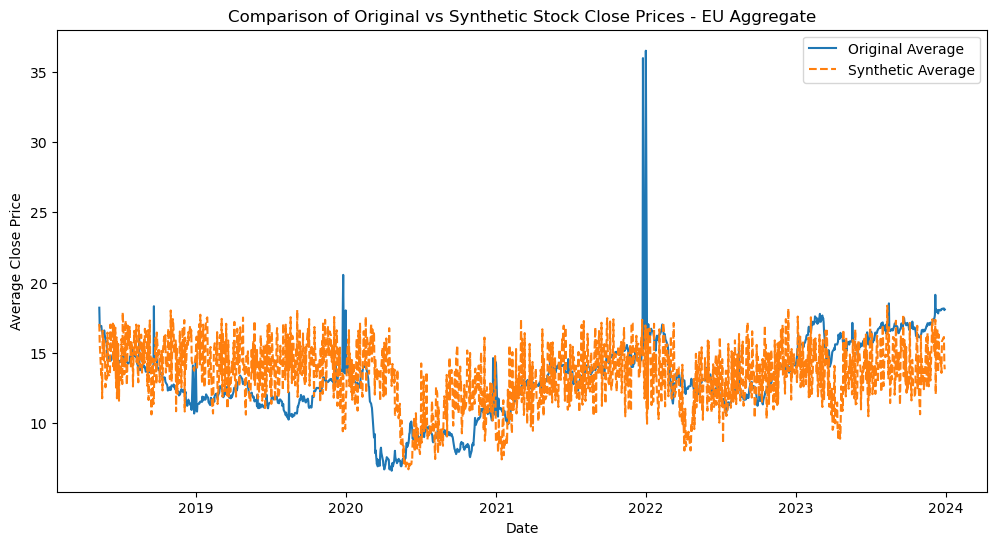

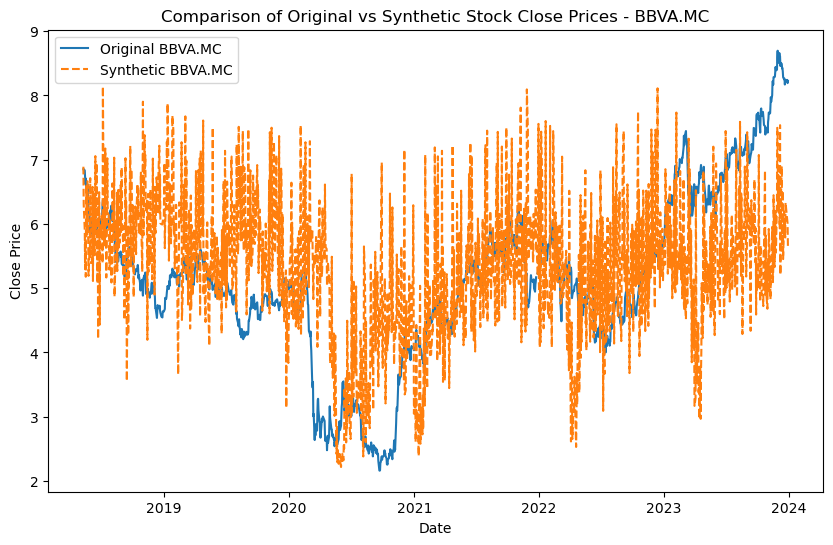

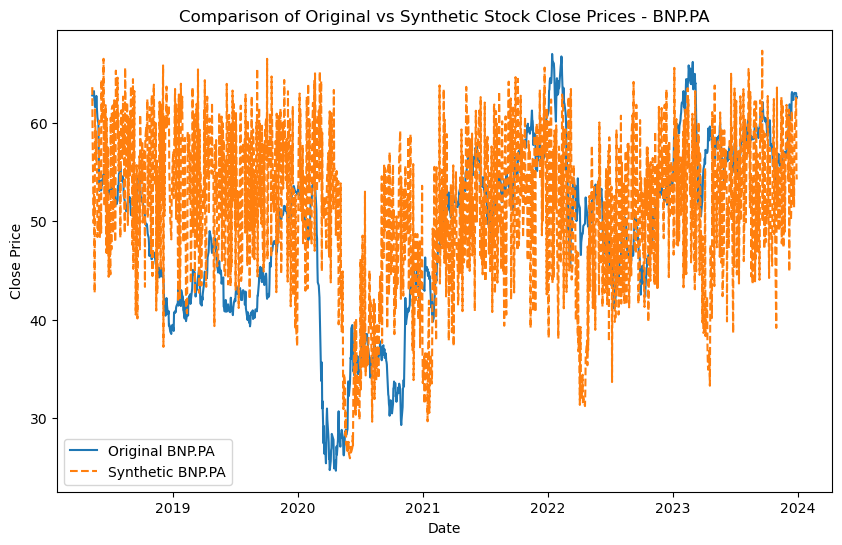

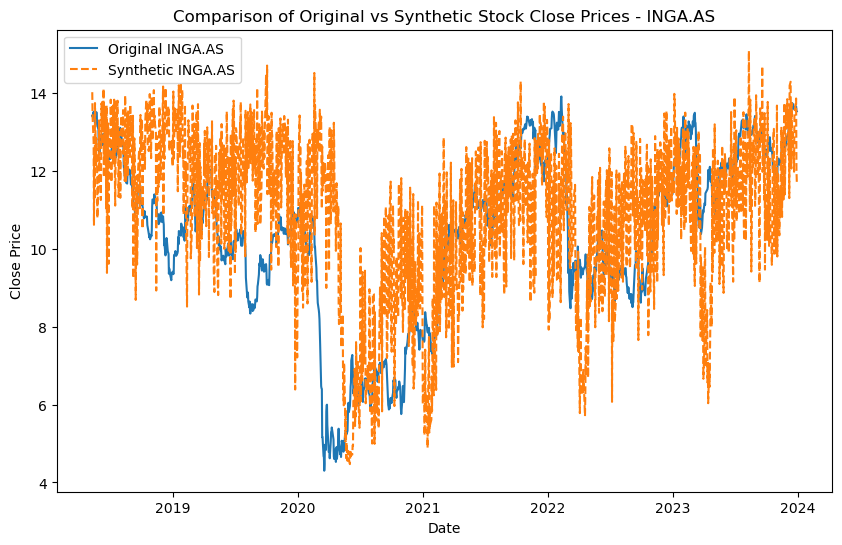

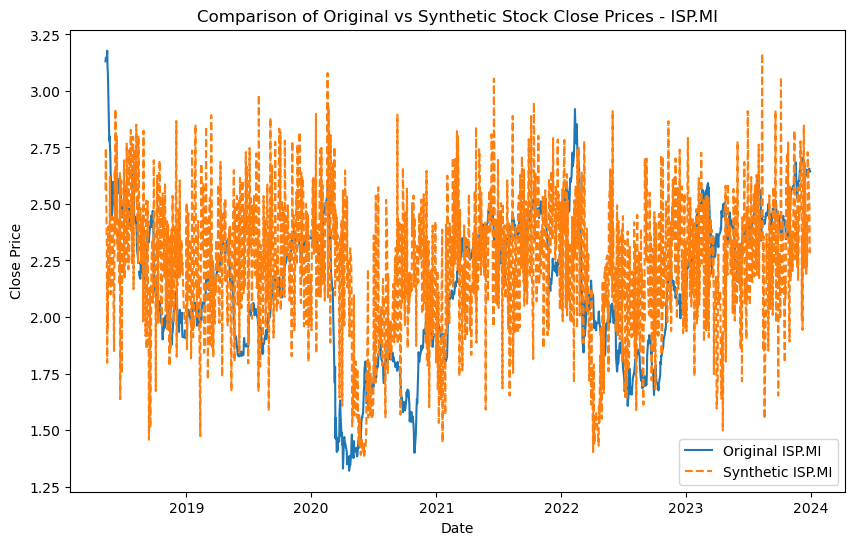

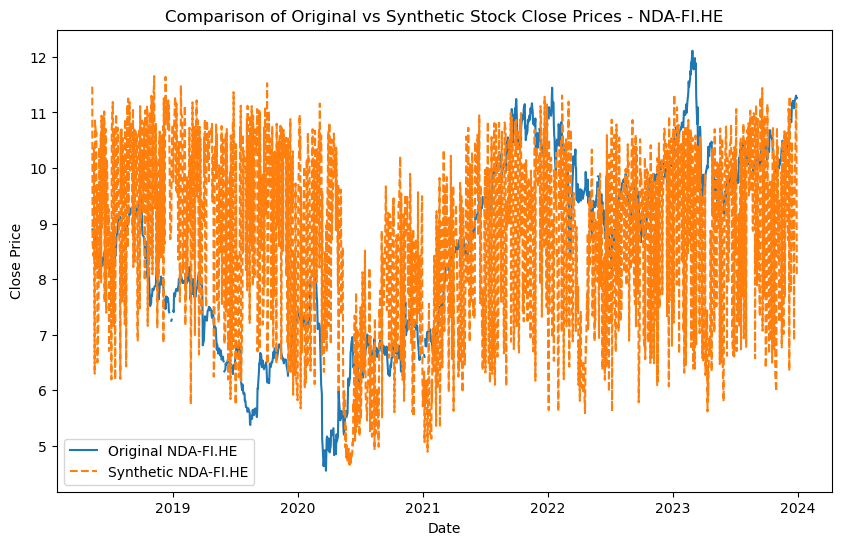

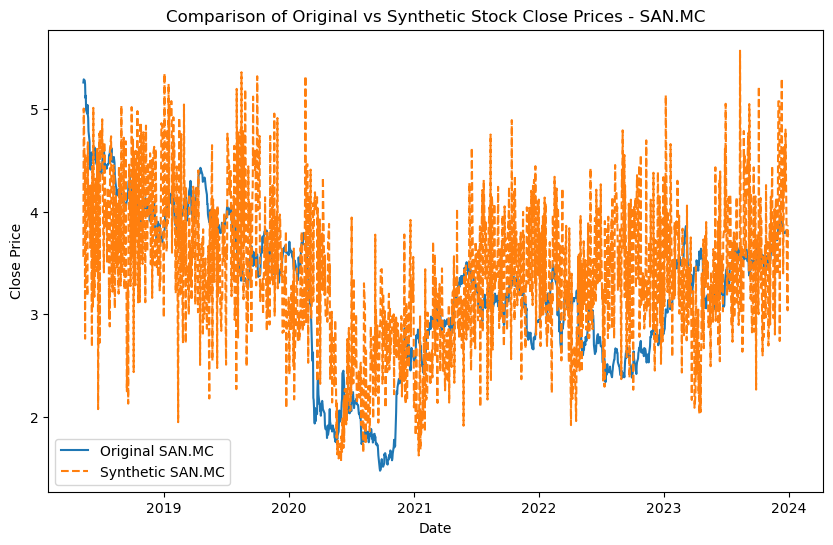

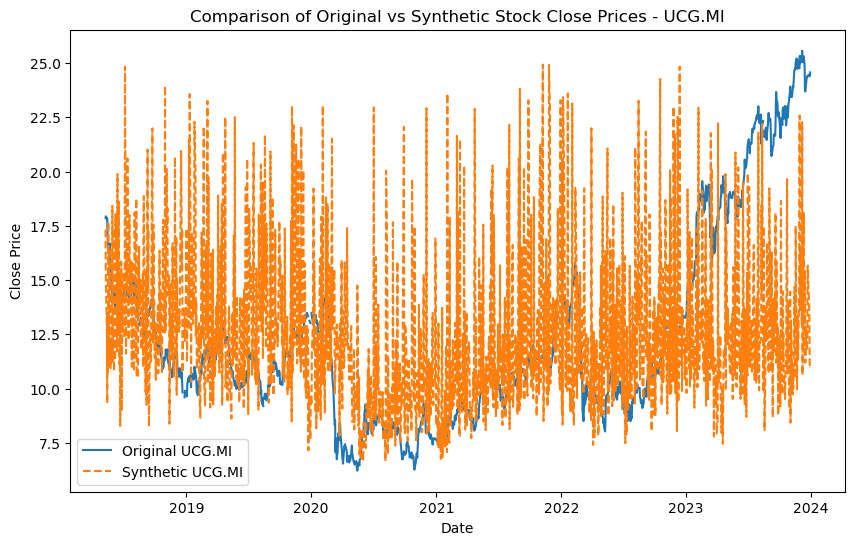


Original Data Statistics:
Ticker      BBVA.MC       BNP.PA      INGA.AS       ISP.MI    NDA-FI.HE  \
count   1535.000000  1538.000000  1537.000000  1525.000000  1508.000000   
mean       5.235834    50.046756    10.614514     2.204081     8.567712   
std        1.325613     9.141552     2.339620     0.374683     1.630310   
min        2.160000    24.670000     4.300500     1.320000     4.550000   
25%        4.608250    43.807500     9.396000     1.940000     7.116250   
50%        5.170000    51.400002    10.804000     2.232000     8.748000   
75%        6.048000    56.707500    12.332000     2.429500     9.955000   
max        8.696000    68.349998    16.666000     3.210000    12.112000   

Ticker       SAN.MC       UCG.MI  
count   1535.000000  1525.000000  
mean       3.334309    12.677489  
std        0.859539     4.432713  
min        1.473533     6.213000  
25%        2.790250     9.627000  
50%        3.318000    11.426000  
75%        3.832615    14.538000  
max        5.8228

C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:176: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_avg, label='Original Average', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:177: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_avg, label='Synthetic Average', shade=True)


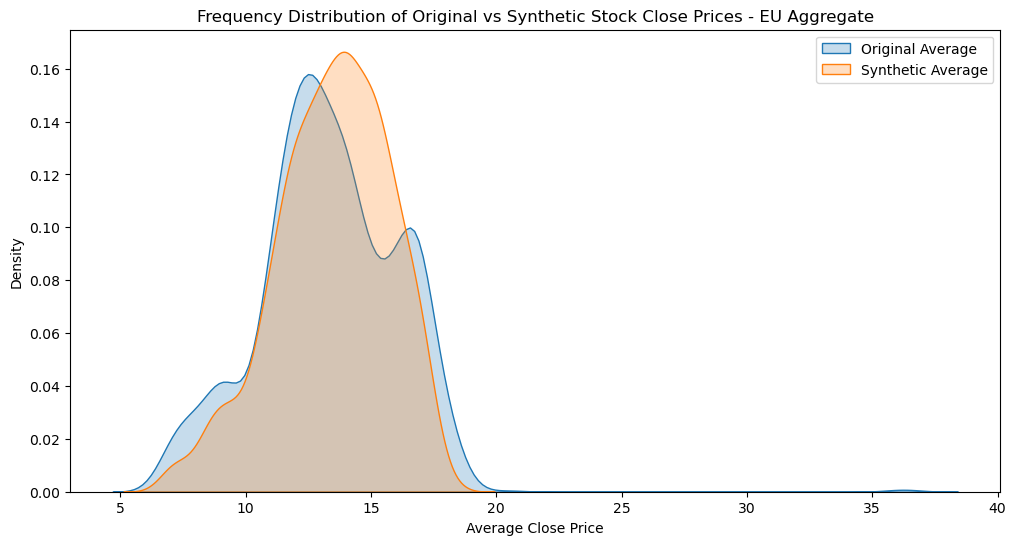

C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


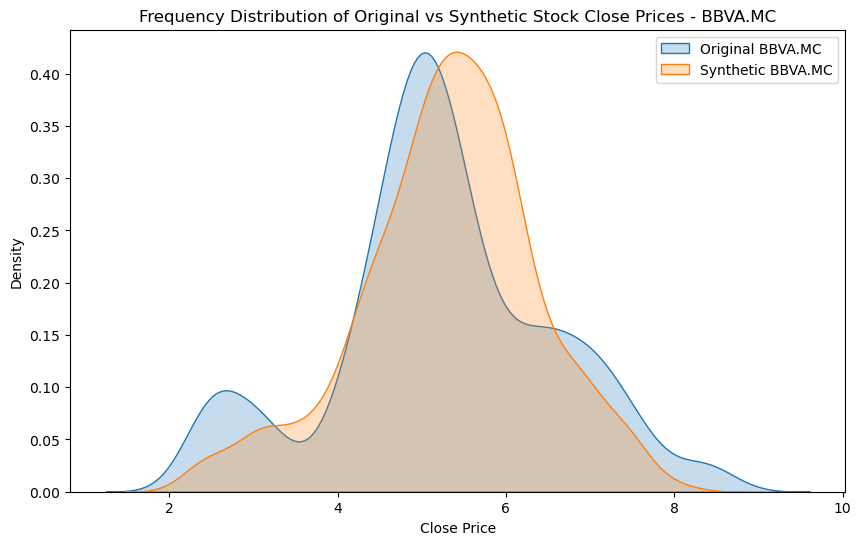

C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


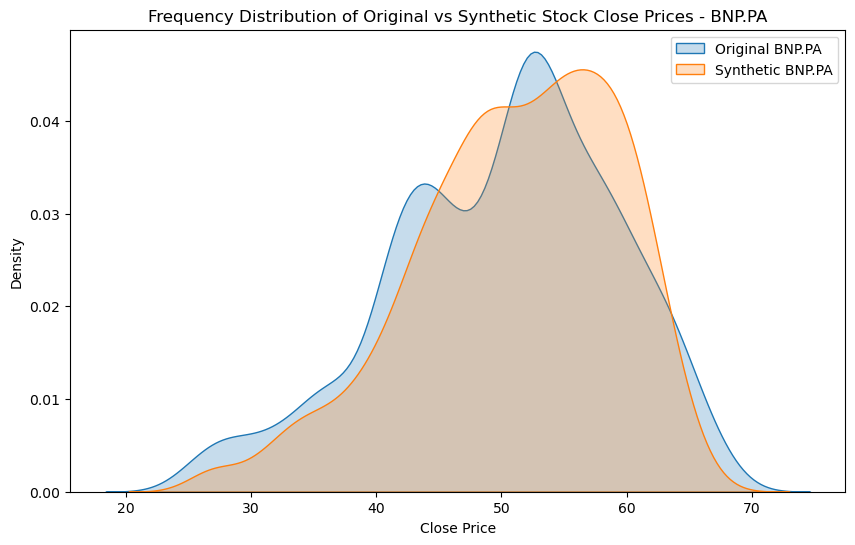

C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


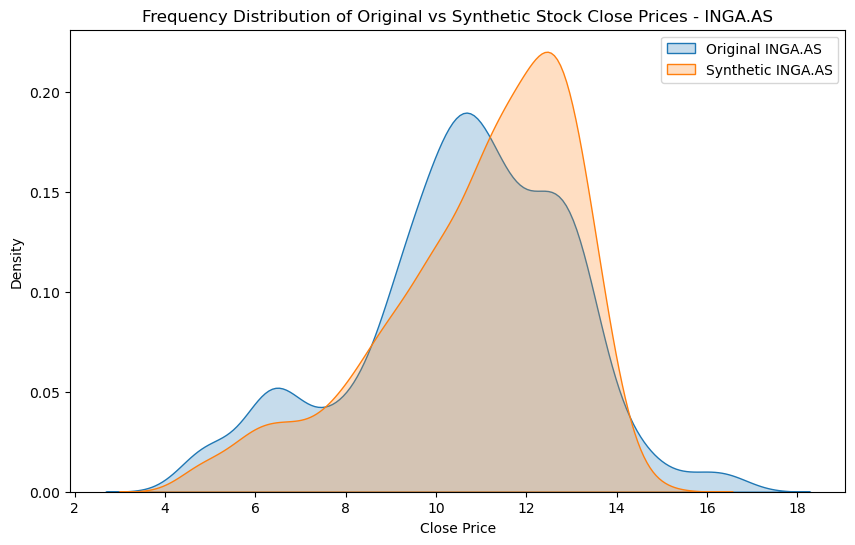

C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


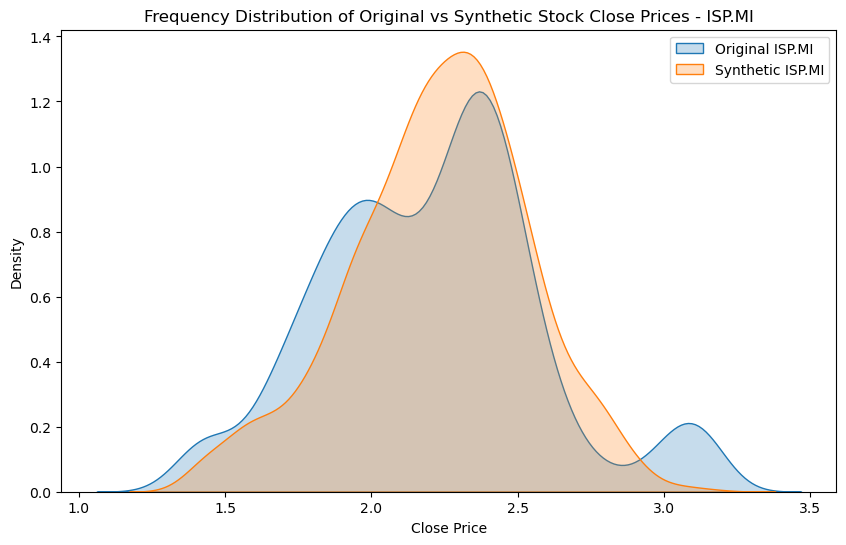

C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


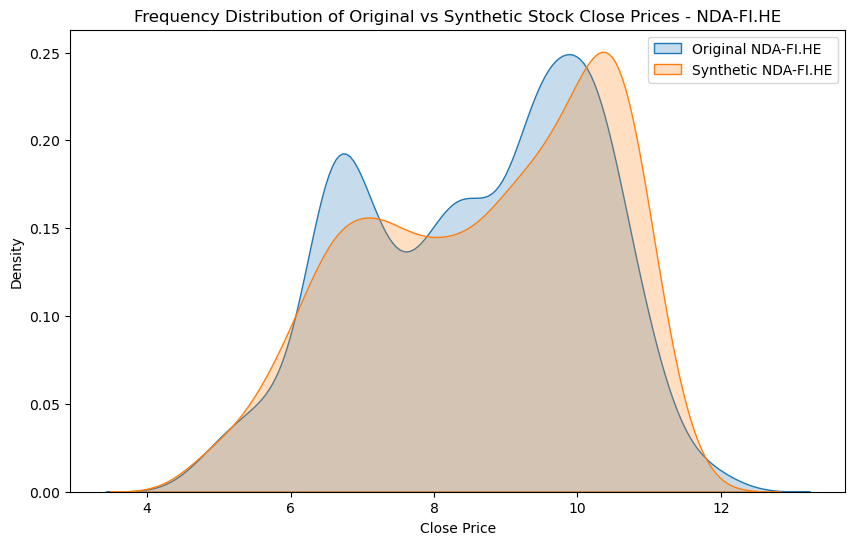

C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


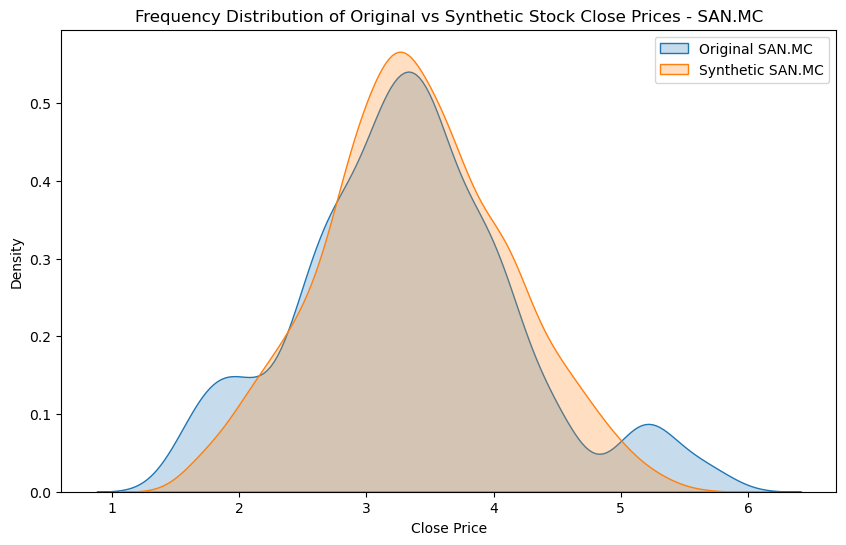

C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_31608\3987990264.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


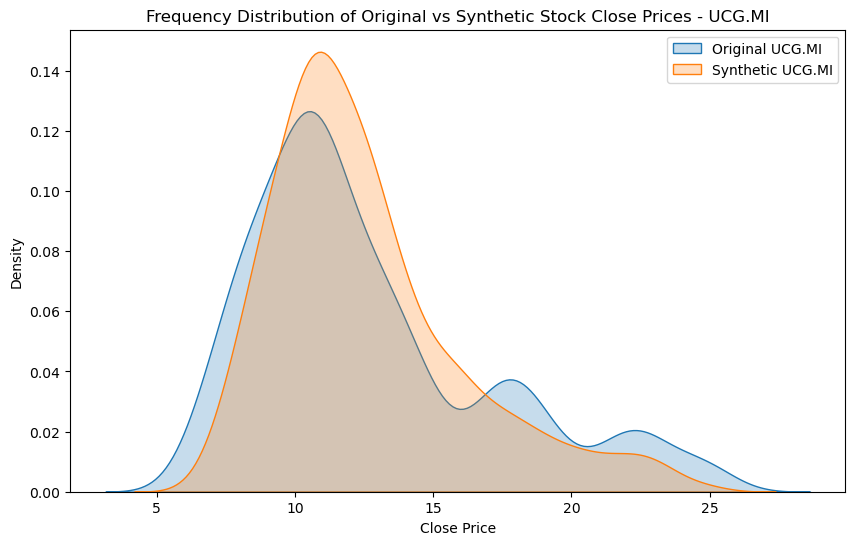

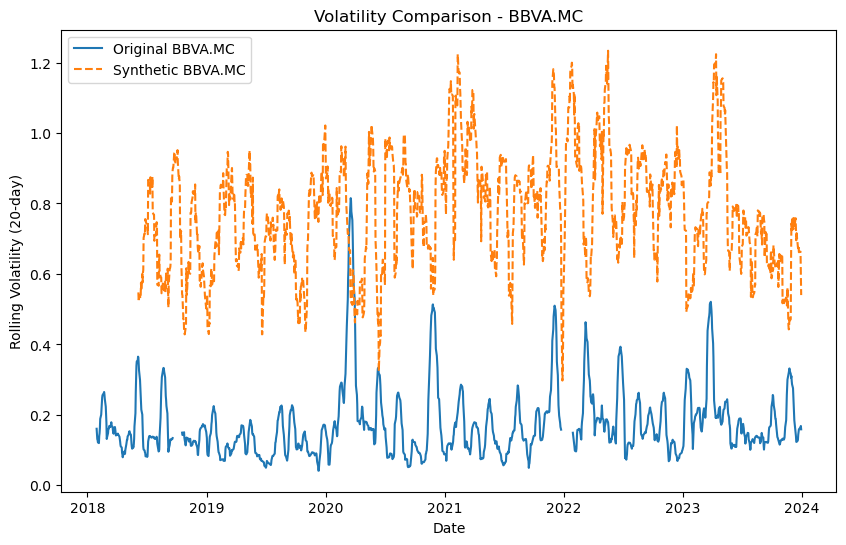


Volatility Statistics for BBVA.MC:
Original Volatility:
count    1474.000000
mean        0.174290
std         0.101456
min         0.041592
25%         0.112780
50%         0.146586
75%         0.206042
max         0.815126
Name: BBVA.MC, dtype: float64

Synthetic Volatility:
count    1430.000000
mean        0.775183
std         0.163922
min         0.297495
25%         0.652414
50%         0.775983
75%         0.886054
max         1.233583
Name: BBVA.MC, dtype: float64


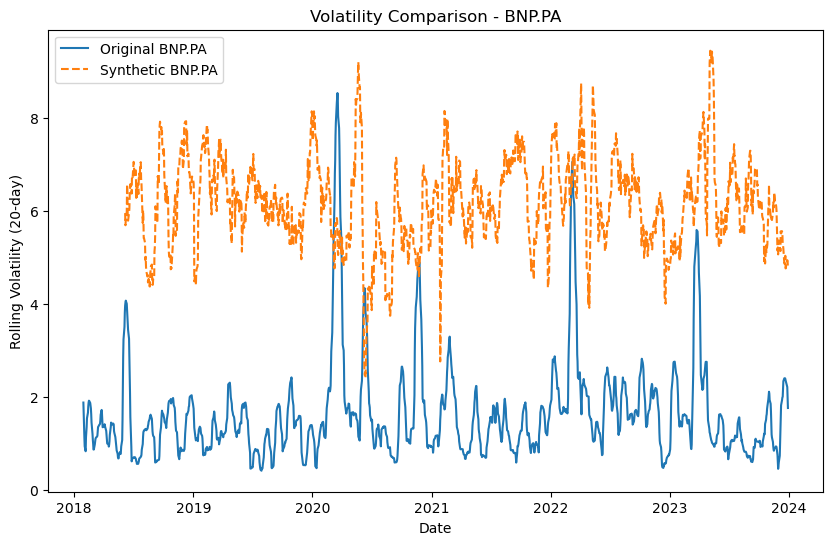


Volatility Statistics for BNP.PA:
Original Volatility:
count    1519.000000
mean        1.625057
std         1.078112
min         0.404629
25%         0.989592
50%         1.386672
75%         1.852764
max         8.537476
Name: BNP.PA, dtype: float64

Synthetic Volatility:
count    1430.000000
mean        6.167086
std         0.962029
min         2.415474
25%         5.529893
50%         6.170807
75%         6.748842
max         9.448948
Name: BNP.PA, dtype: float64


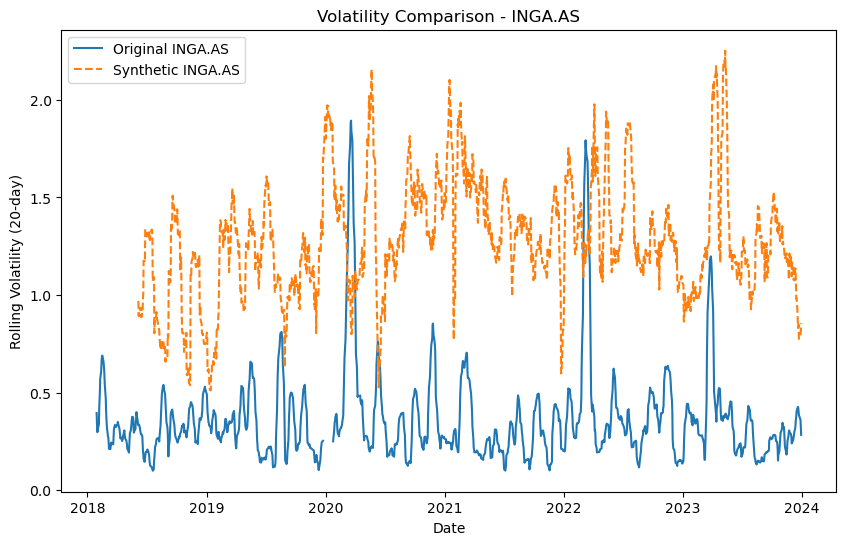


Volatility Statistics for INGA.AS:
Original Volatility:
count    1499.000000
mean        0.361826
std         0.240632
min         0.099462
25%         0.223091
50%         0.306016
75%         0.413586
max         1.893765
Name: INGA.AS, dtype: float64

Synthetic Volatility:
count    1430.000000
mean        1.281548
std         0.298472
min         0.511251
25%         1.100060
50%         1.261804
75%         1.446443
max         2.252116
Name: INGA.AS, dtype: float64


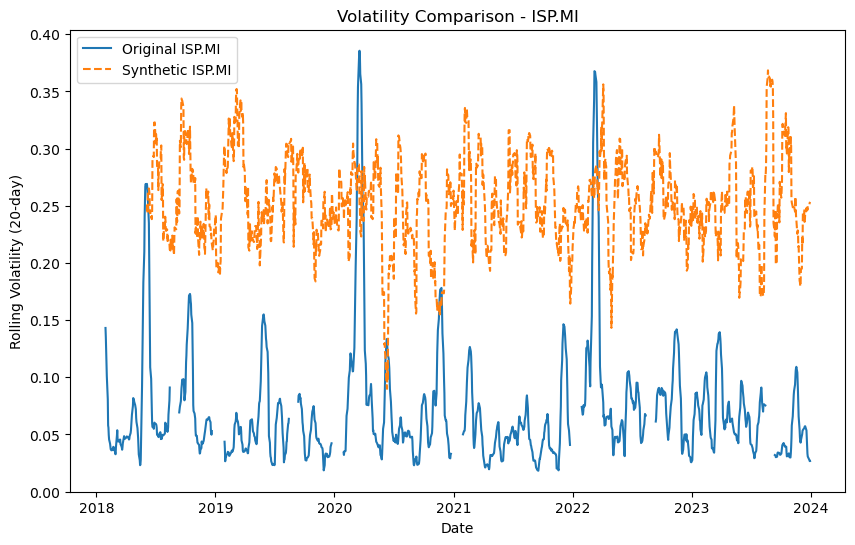


Volatility Statistics for ISP.MI:
Original Volatility:
count    1343.000000
mean        0.071638
std         0.053252
min         0.018242
25%         0.041663
50%         0.056547
75%         0.081819
max         0.385663
Name: ISP.MI, dtype: float64

Synthetic Volatility:
count    1430.000000
mean        0.252565
std         0.039554
min         0.089865
25%         0.228495
50%         0.249603
75%         0.279127
max         0.368493
Name: ISP.MI, dtype: float64


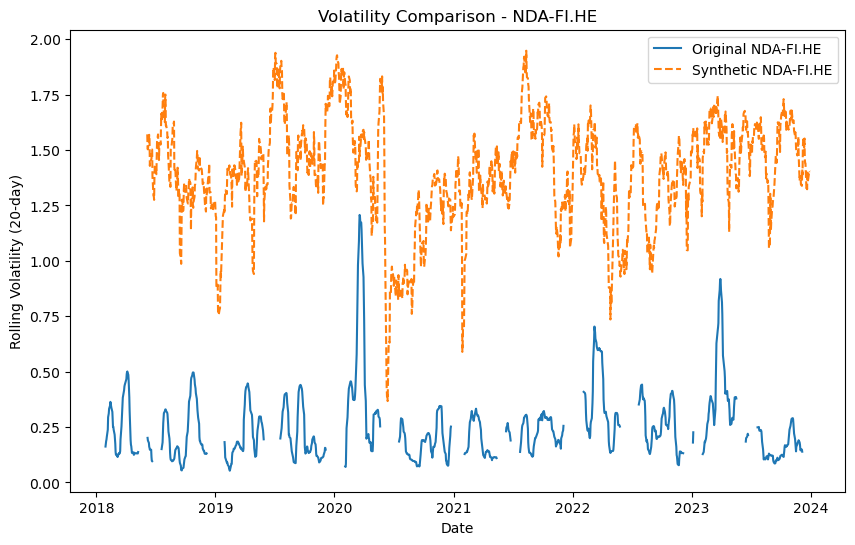


Volatility Statistics for NDA-FI.HE:
Original Volatility:
count    1083.000000
mean        0.252688
std         0.163843
min         0.052679
25%         0.139717
50%         0.210350
75%         0.313020
max         1.207434
Name: NDA-FI.HE, dtype: float64

Synthetic Volatility:
count    1430.000000
mean        1.397954
std         0.243444
min         0.367086
25%         1.275003
50%         1.413494
75%         1.564825
max         1.948569
Name: NDA-FI.HE, dtype: float64


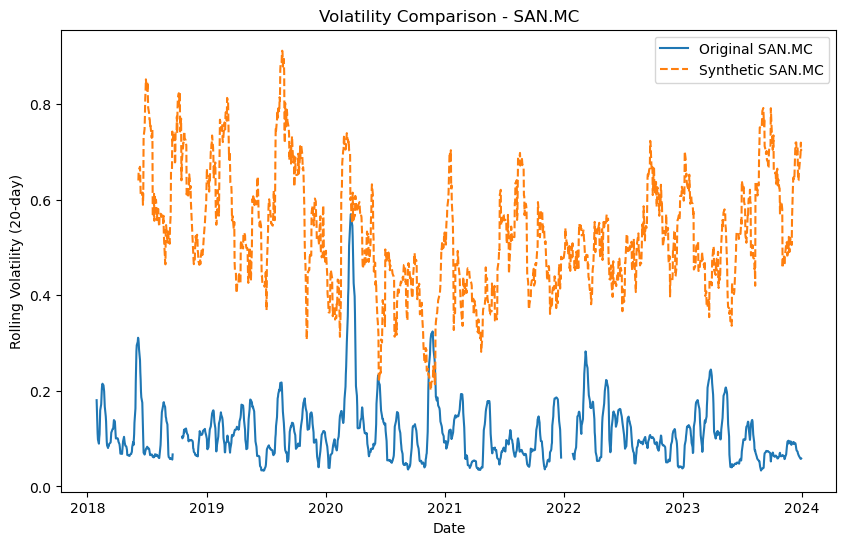


Volatility Statistics for SAN.MC:
Original Volatility:
count    1474.000000
mean        0.112221
std         0.065984
min         0.032983
25%         0.069565
50%         0.096850
75%         0.137171
max         0.569753
Name: SAN.MC, dtype: float64

Synthetic Volatility:
count    1430.000000
mean        0.528285
std         0.125364
min         0.201082
25%         0.440859
50%         0.513139
75%         0.609338
max         0.911918
Name: SAN.MC, dtype: float64


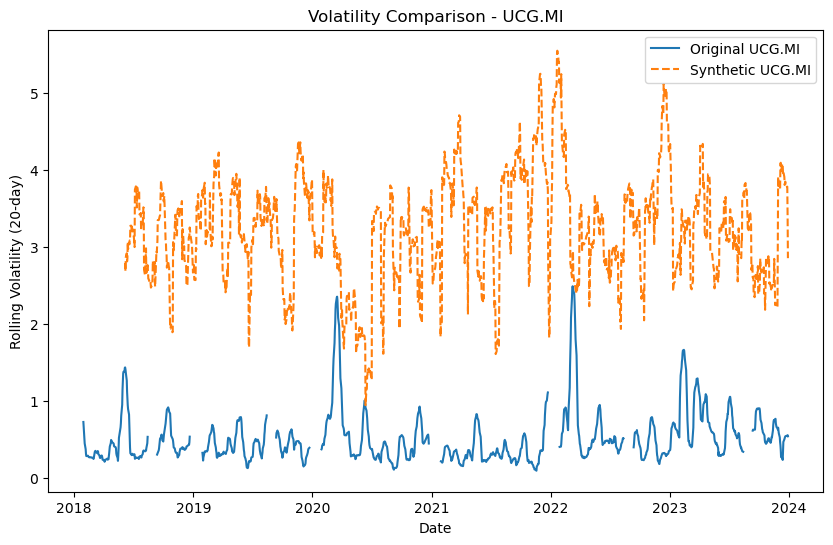


Volatility Statistics for UCG.MI:
Original Volatility:
count    1343.000000
mean        0.515049
std         0.348854
min         0.090916
25%         0.294770
50%         0.421812
75%         0.605190
max         2.487588
Name: UCG.MI, dtype: float64

Synthetic Volatility:
count    1430.000000
mean        3.229635
std         0.707860
min         0.943127
25%         2.756408
50%         3.250799
75%         3.679595
max         5.547981
Name: UCG.MI, dtype: float64

Risk Metrics for BBVA.MC:
Original Data:
VaR: -0.0349
CVaR: -0.0531

Synthetic Data:
VaR: -0.2873
CVaR: -0.3476

Risk Metrics for BNP.PA:
Original Data:
VaR: -0.0326
CVaR: -0.0511

Synthetic Data:
VaR: -0.2358
CVaR: -0.2793

Risk Metrics for INGA.AS:
Original Data:
VaR: -0.0336
CVaR: -0.0549

Synthetic Data:
VaR: -0.2376
CVaR: -0.2936

Risk Metrics for ISP.MI:
Original Data:
VaR: -0.0300
CVaR: -0.0489

Synthetic Data:
VaR: -0.2218
CVaR: -0.2819

Risk Metrics for NDA-FI.HE:
Original Data:
VaR: -0.0257
CVaR: -0.0446

Synth

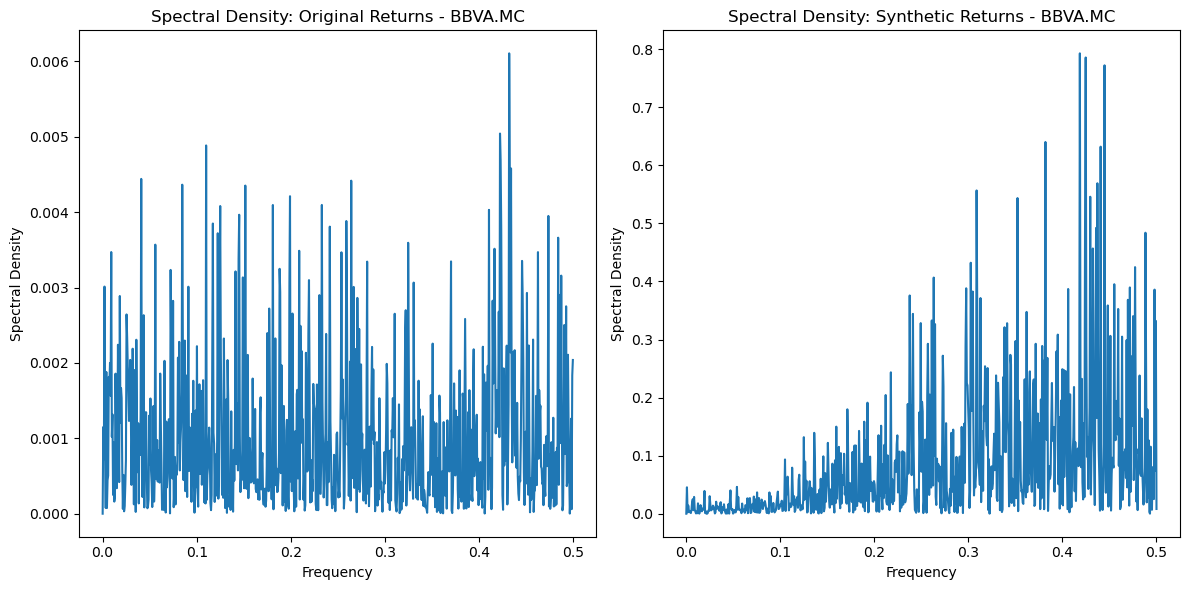


Spectral Analysis for BBVA.MC:
Original Returns - Spectral Density Statistics:
Max: 0.00611
Min: 0.00000
Mean: 0.00103
Standard Deviation: 0.00099

Synthetic Returns - Spectral Density Statistics:
Max: 0.79289
Min: 0.00000
Mean: 0.08686
Standard Deviation: 0.11392


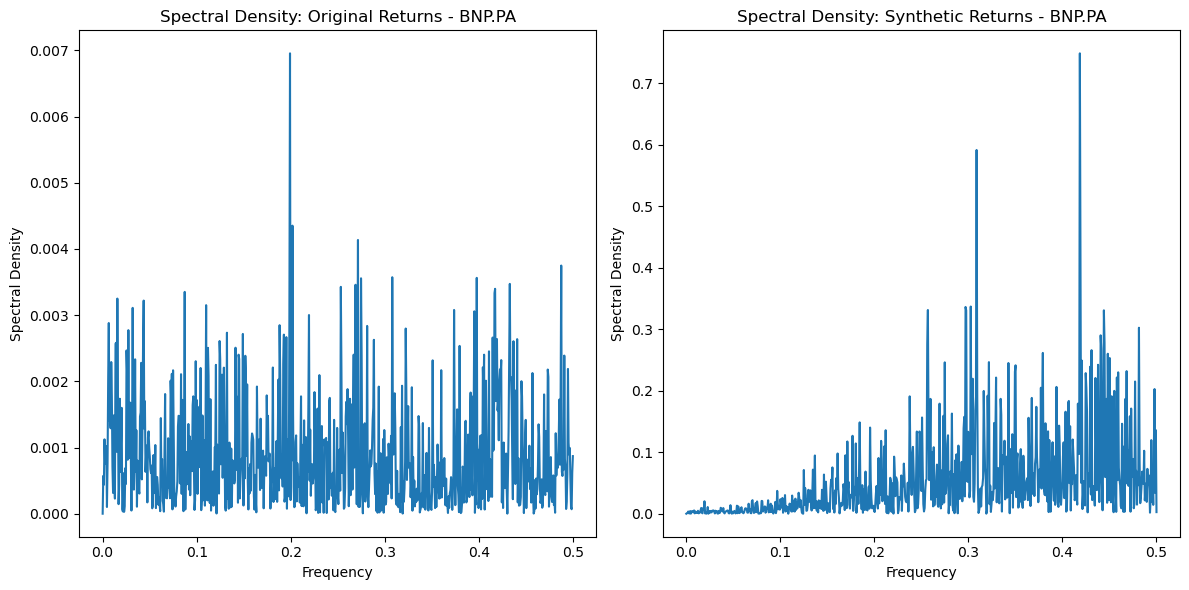


Spectral Analysis for BNP.PA:
Original Returns - Spectral Density Statistics:
Max: 0.00696
Min: 0.00000
Mean: 0.00089
Standard Deviation: 0.00083

Synthetic Returns - Spectral Density Statistics:
Max: 0.74825
Min: 0.00000
Mean: 0.05390
Standard Deviation: 0.07309


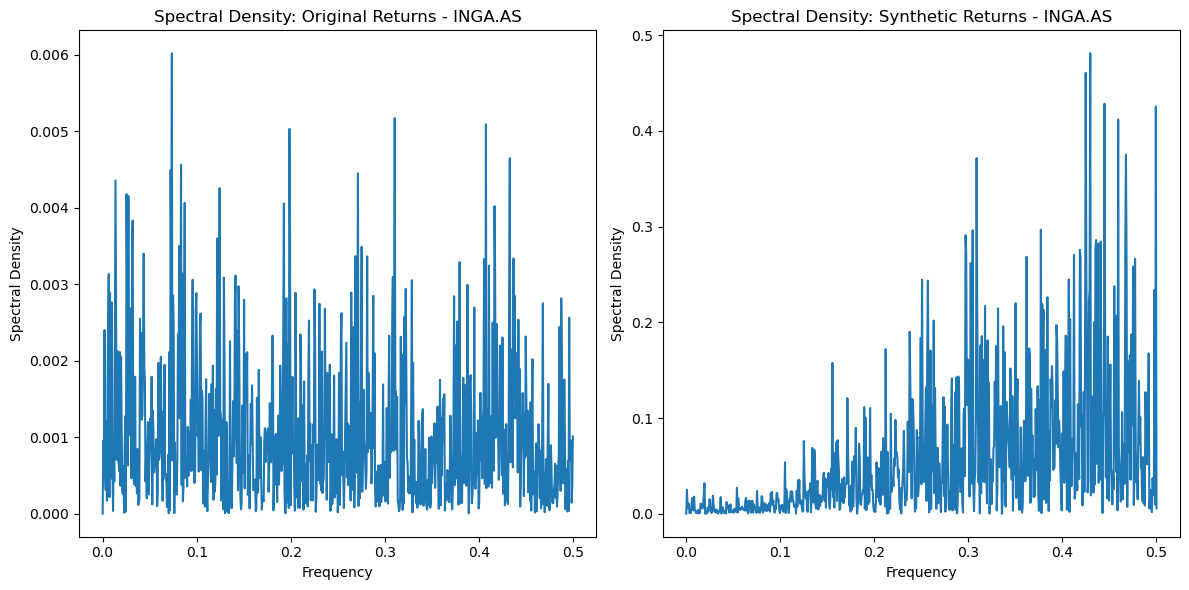


Spectral Analysis for INGA.AS:
Original Returns - Spectral Density Statistics:
Max: 0.00602
Min: 0.00000
Mean: 0.00105
Standard Deviation: 0.00097

Synthetic Returns - Spectral Density Statistics:
Max: 0.48114
Min: 0.00000
Mean: 0.05702
Standard Deviation: 0.07402


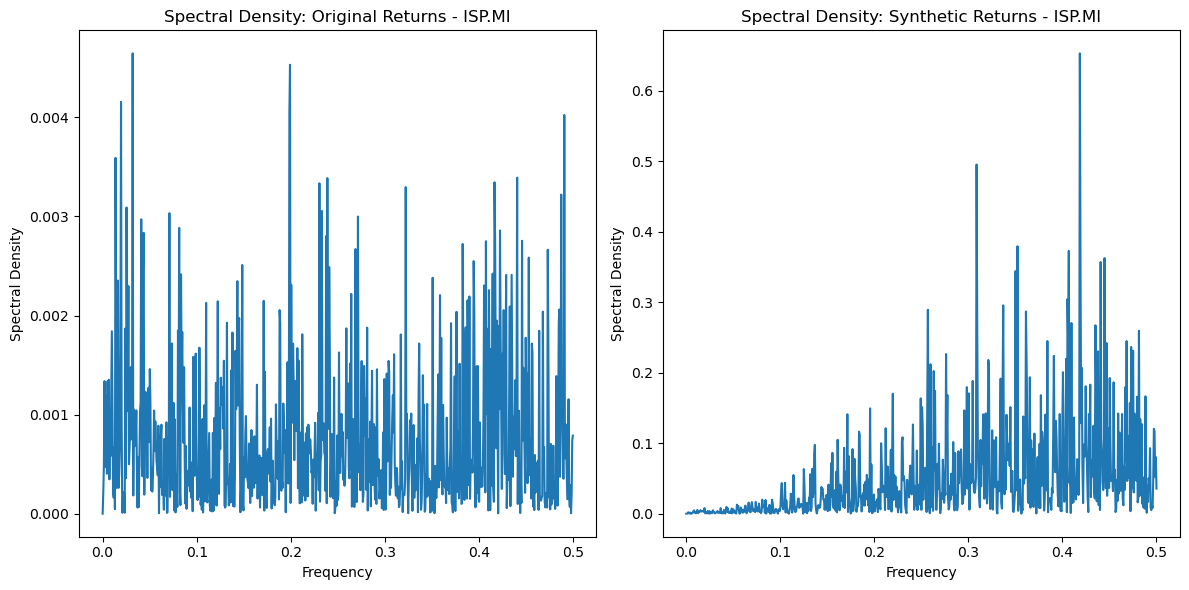


Spectral Analysis for ISP.MI:
Original Returns - Spectral Density Statistics:
Max: 0.00465
Min: 0.00000
Mean: 0.00077
Standard Deviation: 0.00075

Synthetic Returns - Spectral Density Statistics:
Max: 0.65324
Min: 0.00000
Mean: 0.04990
Standard Deviation: 0.06987


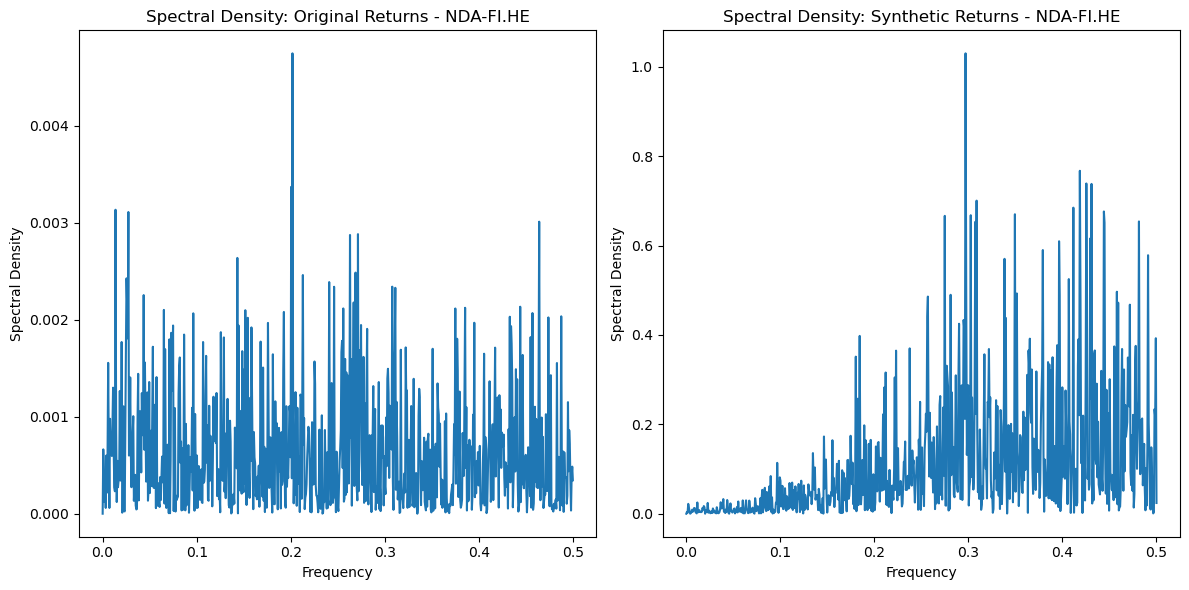


Spectral Analysis for NDA-FI.HE:
Original Returns - Spectral Density Statistics:
Max: 0.00475
Min: 0.00000
Mean: 0.00064
Standard Deviation: 0.00062

Synthetic Returns - Spectral Density Statistics:
Max: 1.02992
Min: 0.00000
Mean: 0.11097
Standard Deviation: 0.14198


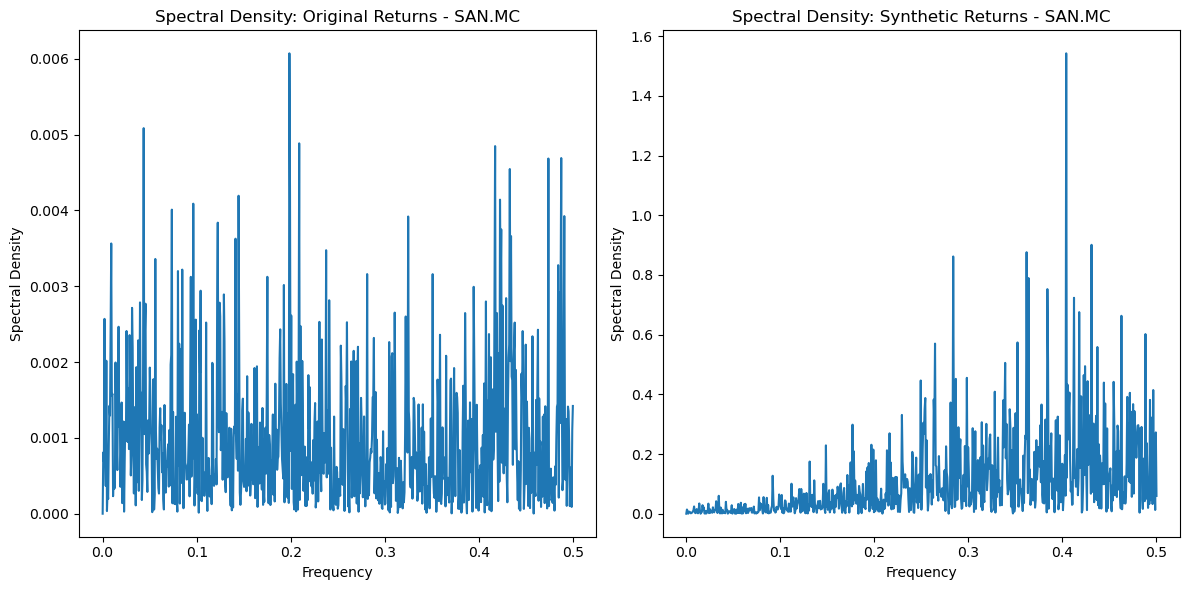


Spectral Analysis for SAN.MC:
Original Returns - Spectral Density Statistics:
Max: 0.00607
Min: 0.00000
Mean: 0.00098
Standard Deviation: 0.00092

Synthetic Returns - Spectral Density Statistics:
Max: 1.54237
Min: 0.00000
Mean: 0.10520
Standard Deviation: 0.14304


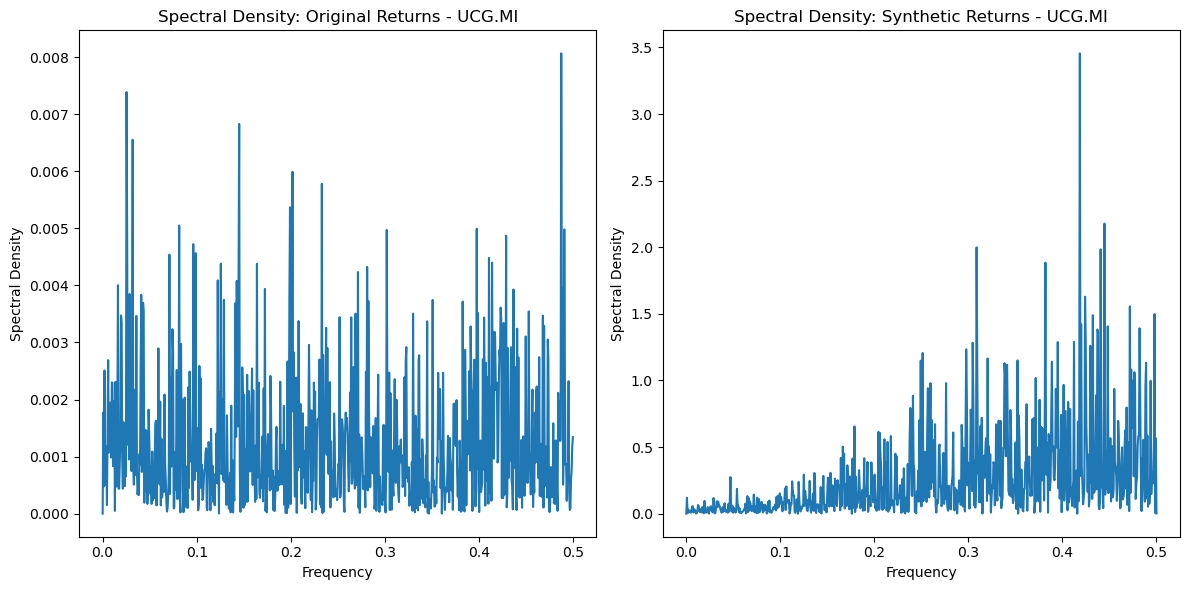


Spectral Analysis for UCG.MI:
Original Returns - Spectral Density Statistics:
Max: 0.00806
Min: 0.00000
Mean: 0.00125
Standard Deviation: 0.00119

Synthetic Returns - Spectral Density Statistics:
Max: 3.45578
Min: 0.00000
Mean: 0.26758
Standard Deviation: 0.35197

Additional Metrics for BBVA.MC:
Correlation: nan
Mean Squared Error: 1.8252
Mean Absolute Error: 1.0631

Additional Metrics for BNP.PA:
Correlation: 0.2846
Mean Squared Error: 106.4383
Mean Absolute Error: 8.1981

Additional Metrics for INGA.AS:
Correlation: nan
Mean Squared Error: 5.0855
Mean Absolute Error: 1.7574

Additional Metrics for ISP.MI:
Correlation: nan
Mean Squared Error: 0.1418
Mean Absolute Error: 0.2964

Additional Metrics for NDA-FI.HE:
Correlation: nan
Mean Squared Error: 4.7880
Mean Absolute Error: 1.7366

Additional Metrics for SAN.MC:
Correlation: nan
Mean Squared Error: 0.6042
Mean Absolute Error: 0.6178

Additional Metrics for UCG.MI:
Correlation: nan
Mean Squared Error: 27.2518
Mean Absolute Error: 3.8

In [16]:
# Cell 8: Analyze results
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, skew, kurtosis
from scipy.signal import periodogram

def plot_comparison(original_data, synthetic_data, title):
    common_index = original_data.index.intersection(synthetic_data.index)
    aligned_original = original_data.loc[common_index]
    aligned_synthetic = synthetic_data.loc[common_index]

    for column in aligned_original.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(aligned_original.index, aligned_original[column], label=f'Original {column}')
        plt.plot(aligned_synthetic.index, aligned_synthetic[column], label=f'Synthetic {column}', linestyle='dashed')
        plt.title(f"{title} - {column}")
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()

def compute_statistics(data):
    return data.describe()

def plot_distribution(original_data, synthetic_data, title):
    for column in original_data.columns:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
        sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)
        plt.title(f"{title} - {column}")
        plt.xlabel('Close Price')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

def analyze_volatility(original_data, synthetic_data, window=20):
    for column in original_data.columns:
        original_volatility = original_data[column].rolling(window=window).std()
        synthetic_volatility = synthetic_data[column].rolling(window=window).std()
        
        plt.figure(figsize=(10, 6))
        plt.plot(original_volatility.index, original_volatility, label=f'Original {column}')
        plt.plot(synthetic_volatility.index, synthetic_volatility, label=f'Synthetic {column}', linestyle='dashed')
        plt.title(f'Volatility Comparison - {column}')
        plt.xlabel('Date')
        plt.ylabel(f'Rolling Volatility ({window}-day)')
        plt.legend()
        plt.show()
        
        print(f"\nVolatility Statistics for {column}:")
        print("Original Volatility:")
        print(original_volatility.describe())
        print("\nSynthetic Volatility:")
        print(synthetic_volatility.describe())

def compute_var_cvar(returns, alpha=0.05):
    sorted_returns = returns.sort_values()
    var = sorted_returns.quantile(alpha)
    cvar = sorted_returns[sorted_returns <= var].mean()
    return var, cvar

def analyze_risk_metrics(original_data, synthetic_data):
    for column in original_data.columns:
        original_returns = original_data[column].pct_change().dropna()
        synthetic_returns = synthetic_data[column].pct_change().dropna()
        
        original_var, original_cvar = compute_var_cvar(original_returns)
        synthetic_var, synthetic_cvar = compute_var_cvar(synthetic_returns)
        
        print(f"\nRisk Metrics for {column}:")
        print("Original Data:")
        print(f"VaR: {original_var:.4f}")
        print(f"CVaR: {original_cvar:.4f}")
        print("\nSynthetic Data:")
        print(f"VaR: {synthetic_var:.4f}")
        print(f"CVaR: {synthetic_cvar:.4f}")

def analyze_distribution(original_data, synthetic_data):
    for column in original_data.columns:
        original_returns = original_data[column].pct_change().dropna()
        synthetic_returns = synthetic_data[column].pct_change().dropna()
        
        ks_statistic, ks_pvalue = ks_2samp(original_returns, synthetic_returns)
        original_skewness = skew(original_returns)
        synthetic_skewness = skew(synthetic_returns)
        original_kurtosis = kurtosis(original_returns)
        synthetic_kurtosis = kurtosis(synthetic_returns)
        
        print(f"\nDistribution Analysis for {column}:")
        print(f"K-S Statistic: {ks_statistic:.4f}")
        print(f"K-S P-value: {ks_pvalue:.4f}")
        print(f"Original Skewness: {original_skewness:.4f}")
        print(f"Synthetic Skewness: {synthetic_skewness:.4f}")
        print(f"Original Kurtosis: {original_kurtosis:.4f}")
        print(f"Synthetic Kurtosis: {synthetic_kurtosis:.4f}")

def analyze_spectrum(original_data, synthetic_data):
    for column in original_data.columns:
        original_returns = original_data[column].pct_change().dropna()
        synthetic_returns = synthetic_data[column].pct_change().dropna()
        
        f_original, Pxx_original = periodogram(original_returns)
        f_synthetic, Pxx_synthetic = periodogram(synthetic_returns)
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(f_original, Pxx_original)
        plt.title(f'Spectral Density: Original Returns - {column}')
        plt.xlabel('Frequency')
        plt.ylabel('Spectral Density')
        
        plt.subplot(1, 2, 2)
        plt.plot(f_synthetic, Pxx_synthetic)
        plt.title(f'Spectral Density: Synthetic Returns - {column}')
        plt.xlabel('Frequency')
        plt.ylabel('Spectral Density')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nSpectral Analysis for {column}:")
        print("Original Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_original):.5f}")
        print(f"Min: {np.min(Pxx_original):.5f}")
        print(f"Mean: {np.mean(Pxx_original):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_original):.5f}")
        
        print("\nSynthetic Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_synthetic):.5f}")
        print(f"Min: {np.min(Pxx_synthetic):.5f}")
        print(f"Mean: {np.mean(Pxx_synthetic):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_synthetic):.5f}")

def calculate_additional_metrics(original_data, synthetic_data):
    # Ensure both datasets have the same index
    common_index = original_data.index.intersection(synthetic_data.index)
    aligned_original = original_data.loc[common_index]
    aligned_synthetic = synthetic_data.loc[common_index]

    for column in aligned_original.columns:
        correlation = np.corrcoef(aligned_original[column], aligned_synthetic[column])[0, 1]
        mse = np.mean((aligned_original[column] - aligned_synthetic[column]) ** 2)
        mae = np.mean(np.abs(aligned_original[column] - aligned_synthetic[column]))
        
        print(f"\nAdditional Metrics for {column}:")
        print(f"Correlation: {correlation:.4f}")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Mean Absolute Error: {mae:.4f}")
        
def plot_aggregate_comparison(original_data, synthetic_data, title):
    common_index = original_data.index.intersection(synthetic_data.index)
    aligned_original = original_data.loc[common_index]
    aligned_synthetic = synthetic_data.loc[common_index]

    # Calculate average across all stocks
    original_avg = aligned_original.mean(axis=1)
    synthetic_avg = aligned_synthetic.mean(axis=1)

    plt.figure(figsize=(12, 6))
    plt.plot(common_index, original_avg, label='Original Average')
    plt.plot(common_index, synthetic_avg, label='Synthetic Average', linestyle='dashed')
    plt.title(f"{title} - EU Aggregate")
    plt.xlabel('Date')
    plt.ylabel('Average Close Price')
    plt.legend()
    plt.show()

def plot_aggregate_distribution(original_data, synthetic_data, title):
    # Calculate average across all stocks
    original_avg = original_data.mean(axis=1)
    synthetic_avg = synthetic_data.mean(axis=1)

    plt.figure(figsize=(12, 6))
    sns.kdeplot(original_avg, label='Original Average', shade=True)
    sns.kdeplot(synthetic_avg, label='Synthetic Average', shade=True)
    plt.title(f"{title} - EU Aggregate")
    plt.xlabel('Average Close Price')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


# Main execution
plot_aggregate_comparison(stock_data, rescaled_synthetic_data, "Comparison of Original vs Synthetic Stock Close Prices")
plot_comparison(stock_data, rescaled_synthetic_data, "Comparison of Original vs Synthetic Stock Close Prices")

print("\nOriginal Data Statistics:")
print(compute_statistics(stock_data))
print("\nSynthetic Data Statistics:")
print(compute_statistics(rescaled_synthetic_data))

print(compute_statistics(rescaled_synthetic_data))
plot_aggregate_distribution(stock_data, rescaled_synthetic_data, "Frequency Distribution of Original vs Synthetic Stock Close Prices")
plot_distribution(stock_data, rescaled_synthetic_data, "Frequency Distribution of Original vs Synthetic Stock Close Prices")
analyze_volatility(stock_data, rescaled_synthetic_data)
analyze_risk_metrics(stock_data, rescaled_synthetic_data)
analyze_distribution(stock_data, rescaled_synthetic_data)
analyze_spectrum(stock_data, rescaled_synthetic_data)
calculate_additional_metrics(stock_data, rescaled_synthetic_data)

# Risk Metric Analysis

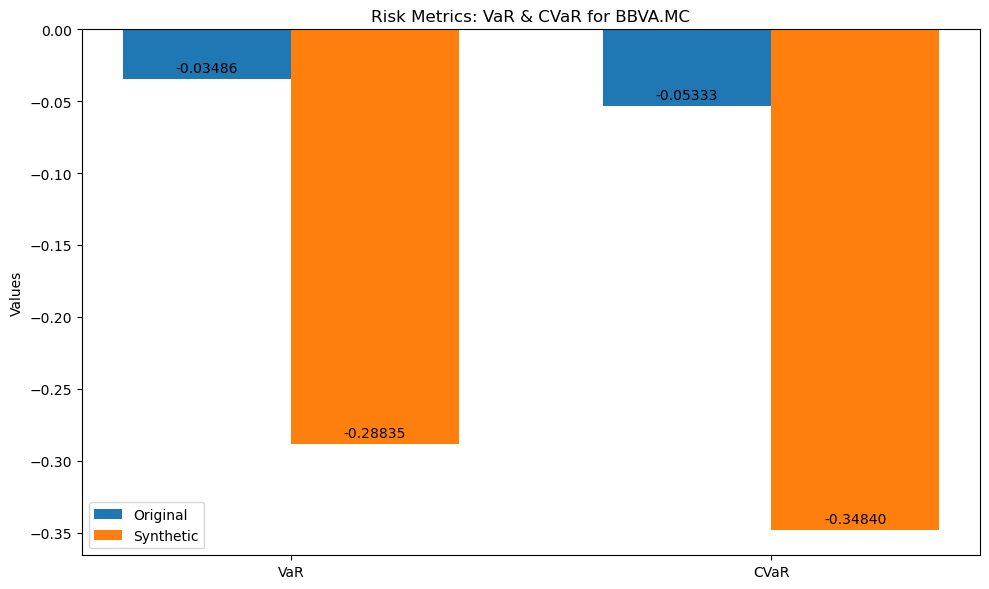


Risk Metrics for BBVA.MC:
Original Data Metrics:
VaR: -0.03486
CVaR: -0.05333

Synthetic Data Metrics:
VaR: -0.28835
CVaR: -0.34840


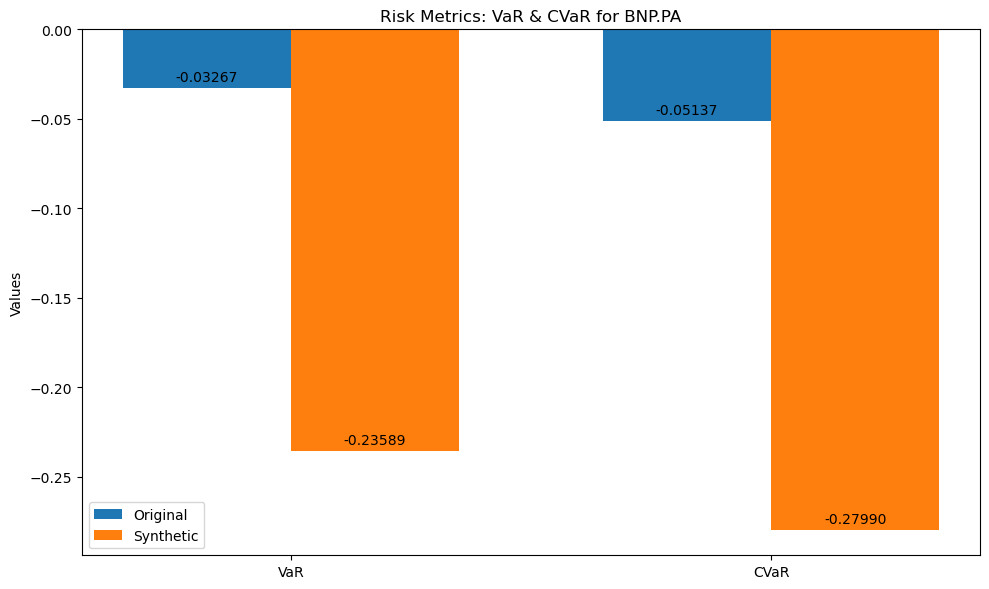


Risk Metrics for BNP.PA:
Original Data Metrics:
VaR: -0.03267
CVaR: -0.05137

Synthetic Data Metrics:
VaR: -0.23589
CVaR: -0.27990


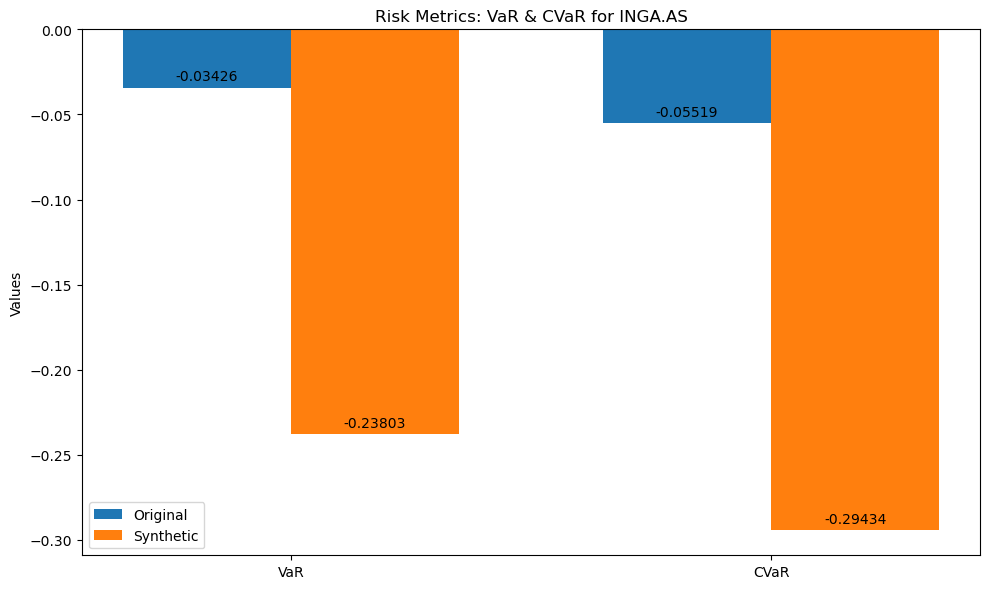


Risk Metrics for INGA.AS:
Original Data Metrics:
VaR: -0.03426
CVaR: -0.05519

Synthetic Data Metrics:
VaR: -0.23803
CVaR: -0.29434


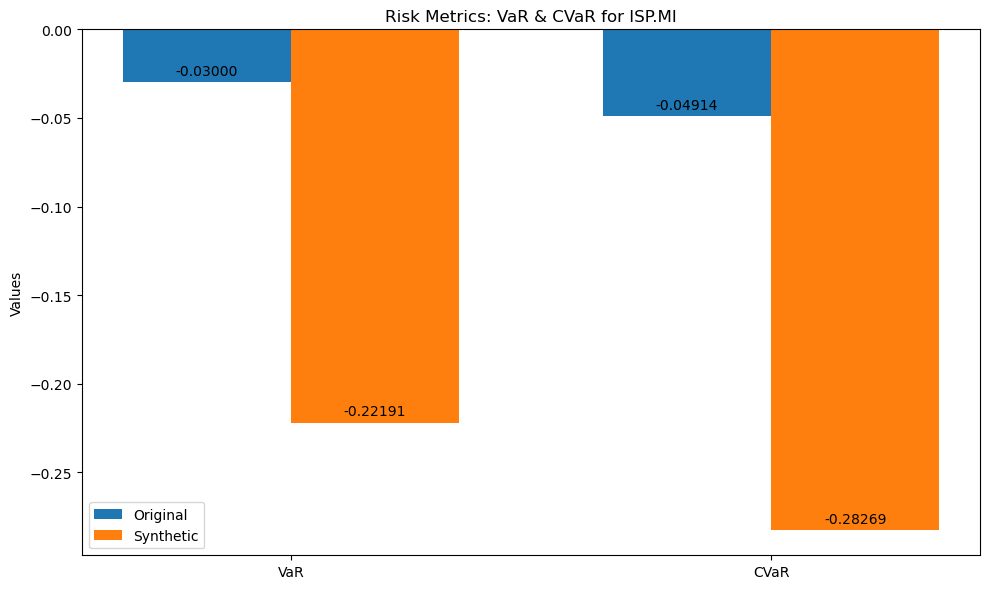


Risk Metrics for ISP.MI:
Original Data Metrics:
VaR: -0.03000
CVaR: -0.04914

Synthetic Data Metrics:
VaR: -0.22191
CVaR: -0.28269


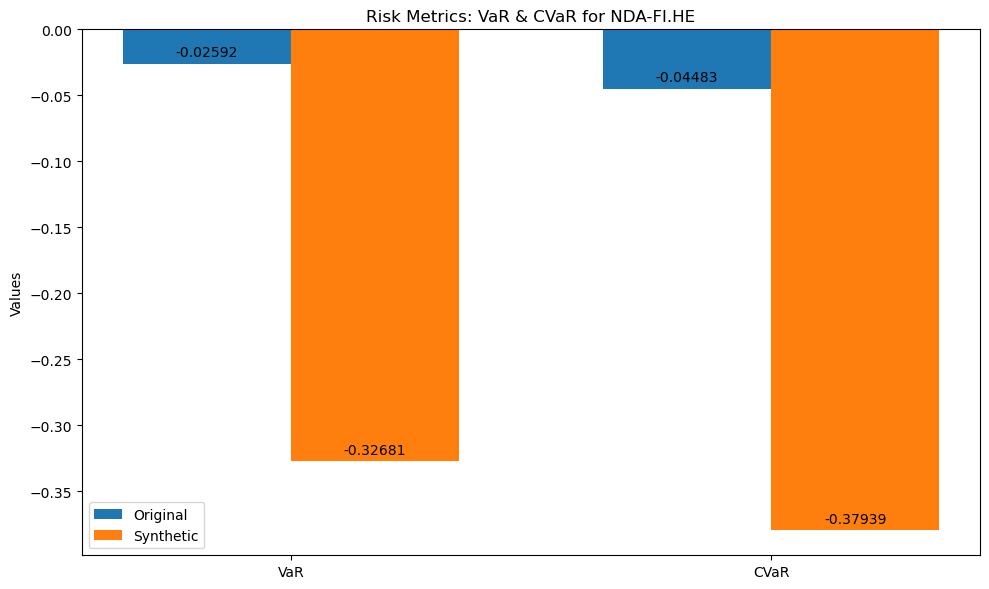


Risk Metrics for NDA-FI.HE:
Original Data Metrics:
VaR: -0.02592
CVaR: -0.04483

Synthetic Data Metrics:
VaR: -0.32681
CVaR: -0.37939


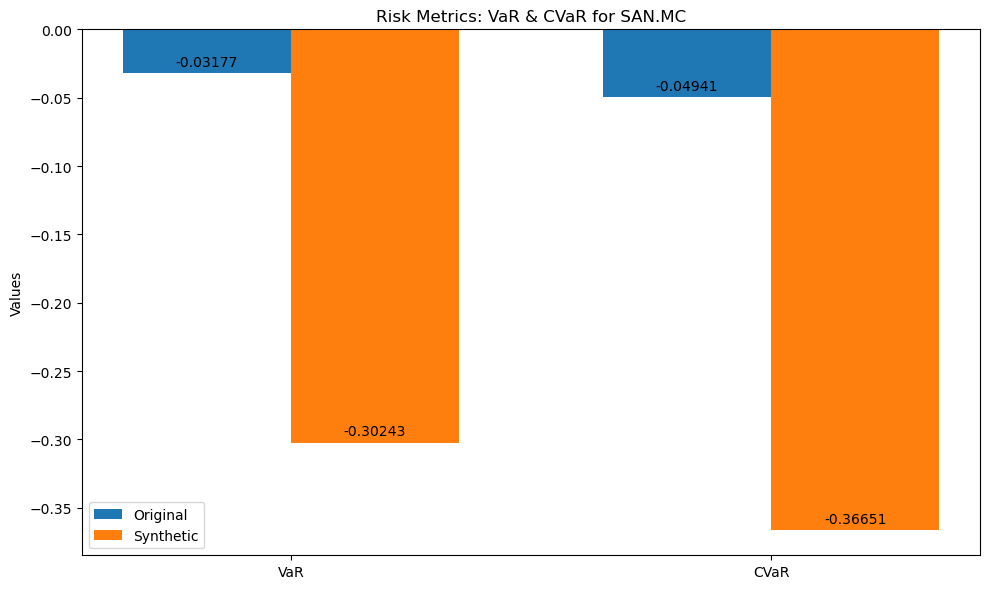


Risk Metrics for SAN.MC:
Original Data Metrics:
VaR: -0.03177
CVaR: -0.04941

Synthetic Data Metrics:
VaR: -0.30243
CVaR: -0.36651


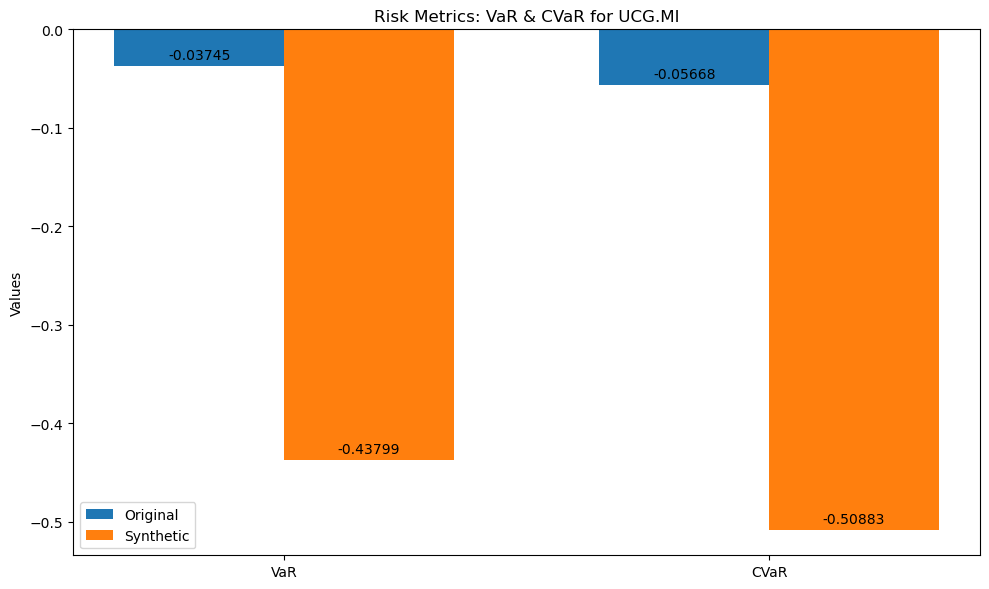


Risk Metrics for UCG.MI:
Original Data Metrics:
VaR: -0.03745
CVaR: -0.05668

Synthetic Data Metrics:
VaR: -0.43799
CVaR: -0.50883


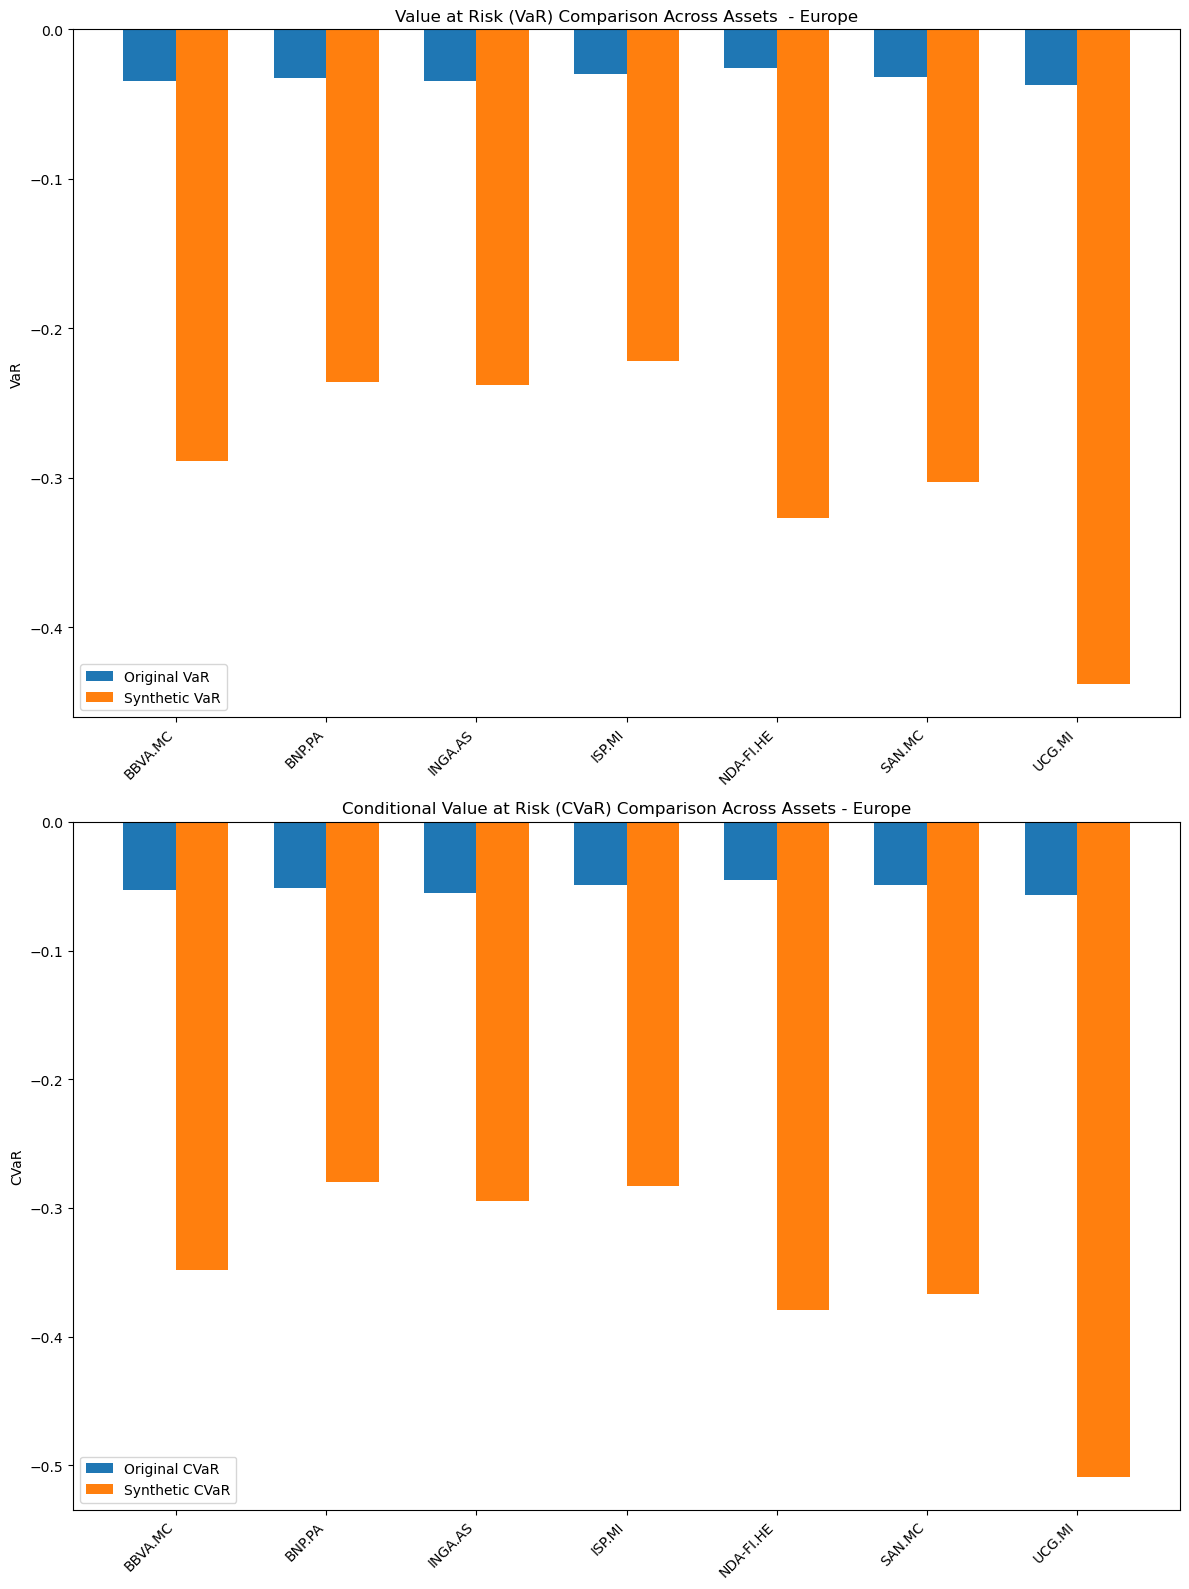


Original Portfolio:

Portfolio Risk Metrics:
VaR: -0.02664
CVaR: -0.04529

Synthetic Portfolio:

Portfolio Risk Metrics:
VaR: -0.23281
CVaR: -0.27871


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def compute_var_cvar(returns, alpha=0.05):
    """
    Compute VaR and CVaR for given returns and alpha.
    """
    sorted_returns = returns.sort_values()
    index = int(alpha * len(sorted_returns))
    VaR = sorted_returns.iloc[index]
    CVaR = sorted_returns.iloc[:index].mean()
    return VaR, CVaR

def analyze_risk_metrics(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()

    original_vars = []
    original_cvars = []
    synthetic_vars = []
    synthetic_cvars = []
    assets = []

    for column in original_returns.columns:
        original_var, original_cvar = compute_var_cvar(original_returns[column])
        synthetic_var, synthetic_cvar = compute_var_cvar(synthetic_returns[column])

        original_vars.append(original_var)
        original_cvars.append(original_cvar)
        synthetic_vars.append(synthetic_var)
        synthetic_cvars.append(synthetic_cvar)
        assets.append(column)

        # Individual asset visualization (unchanged)
        labels = ['VaR', 'CVaR']
        original_metrics = [original_var, original_cvar]
        synthetic_metrics = [synthetic_var, synthetic_cvar]

        x = np.arange(len(labels))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 6))
        rects1 = ax.bar(x - width/2, original_metrics, width, label='Original')
        rects2 = ax.bar(x + width/2, synthetic_metrics, width, label='Synthetic')

        ax.set_ylabel('Values')
        ax.set_title(f'Risk Metrics: VaR & CVaR for {column}')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.5f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        plt.tight_layout()
        plt.show()

        # Display the VaR and CVaR for both datasets
        print(f"\nRisk Metrics for {column}:")
        print("Original Data Metrics:")
        print(f"VaR: {original_var:.5f}")
        print(f"CVaR: {original_cvar:.5f}")

        print("\nSynthetic Data Metrics:")
        print(f"VaR: {synthetic_var:.5f}")
        print(f"CVaR: {synthetic_cvar:.5f}")

    # Aggregate chart for all assets
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    x = np.arange(len(assets))
    width = 0.35

    # VaR comparison
    ax1.bar(x - width/2, original_vars, width, label='Original VaR')
    ax1.bar(x + width/2, synthetic_vars, width, label='Synthetic VaR')
    ax1.set_ylabel('VaR')
    ax1.set_title('Value at Risk (VaR) Comparison Across Assets  - Europe')
    ax1.set_xticks(x)
    ax1.set_xticklabels(assets, rotation=45, ha='right')
    ax1.legend()

    # CVaR comparison
    ax2.bar(x - width/2, original_cvars, width, label='Original CVaR')
    ax2.bar(x + width/2, synthetic_cvars, width, label='Synthetic CVaR')
    ax2.set_ylabel('CVaR')
    ax2.set_title('Conditional Value at Risk (CVaR) Comparison Across Assets - Europe')
    ax2.set_xticks(x)
    ax2.set_xticklabels(assets, rotation=45, ha='right')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def analyze_portfolio_risk(data, weights=None):
    if weights is None:
        weights = np.ones(len(data.columns)) / len(data.columns)  # Equal weights if not provided
    
    portfolio_returns = (data.pct_change().dropna() * weights).sum(axis=1)
    var, cvar = compute_var_cvar(portfolio_returns)
    
    print("\nPortfolio Risk Metrics:")
    print(f"VaR: {var:.5f}")
    print(f"CVaR: {cvar:.5f}")

# Assuming stock_data and rescaled_synthetic_data are available
# If they're not, you might need to load or recreate them here

# Perform the risk metric analysis
analyze_risk_metrics(stock_data, rescaled_synthetic_data)

print("\nOriginal Portfolio:")
analyze_portfolio_risk(stock_data)

print("\nSynthetic Portfolio:")
analyze_portfolio_risk(rescaled_synthetic_data)

# Distributional Analysis


Distributional Analysis for BBVA.MC:
K-S Statistic: 0.3719
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	0.0123		0.9978
Kurtosis:	7.4423		2.8662


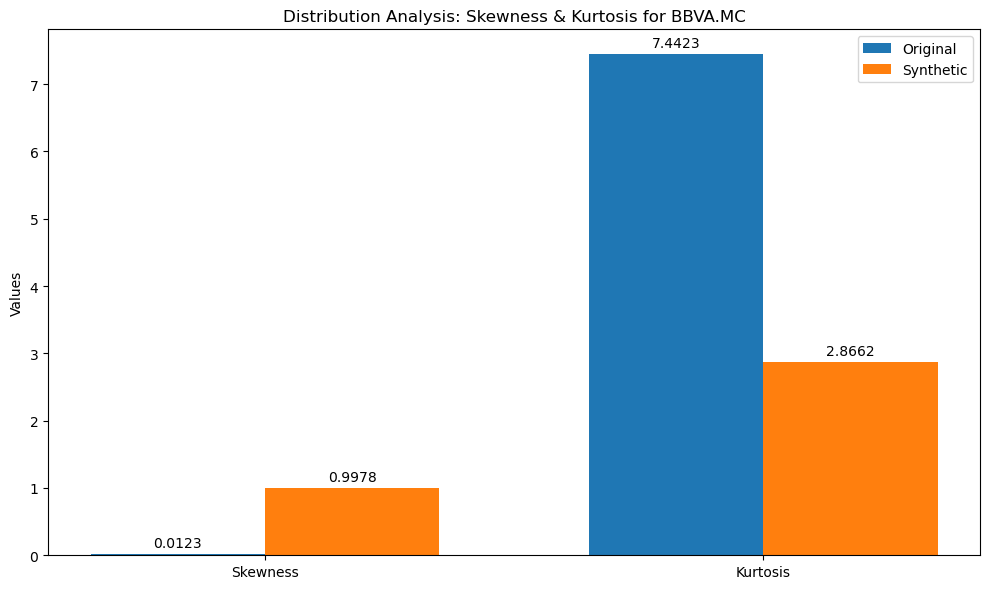

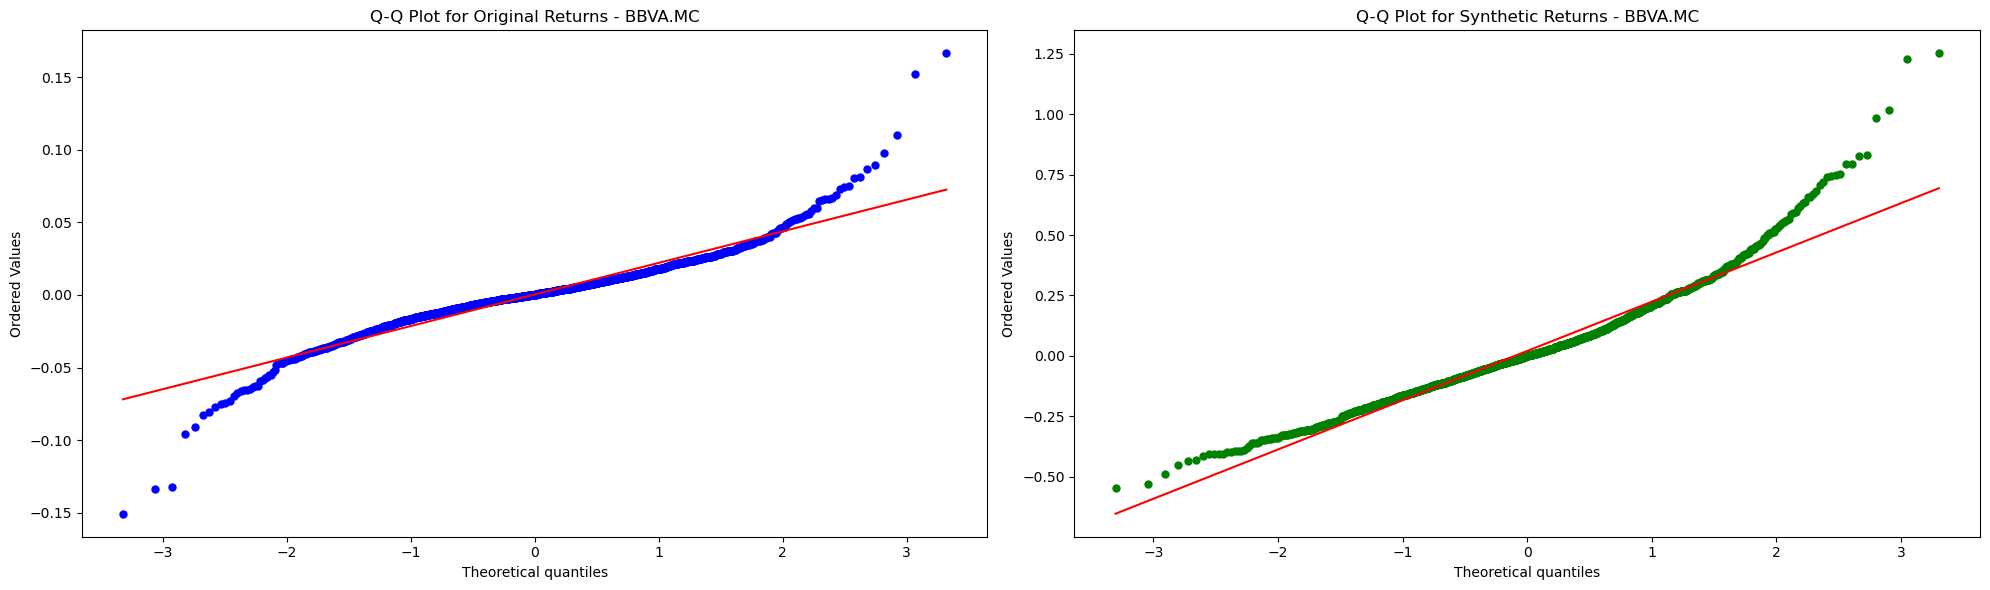


Distributional Analysis for BNP.PA:
K-S Statistic: 0.3792
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	-0.0749		0.4256
Kurtosis:	8.0936		0.0406


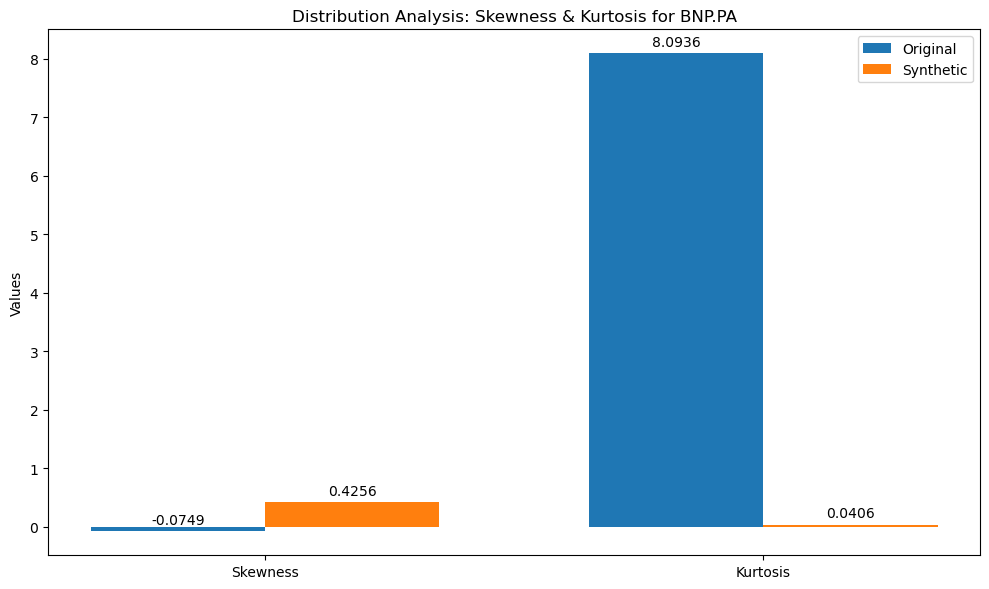

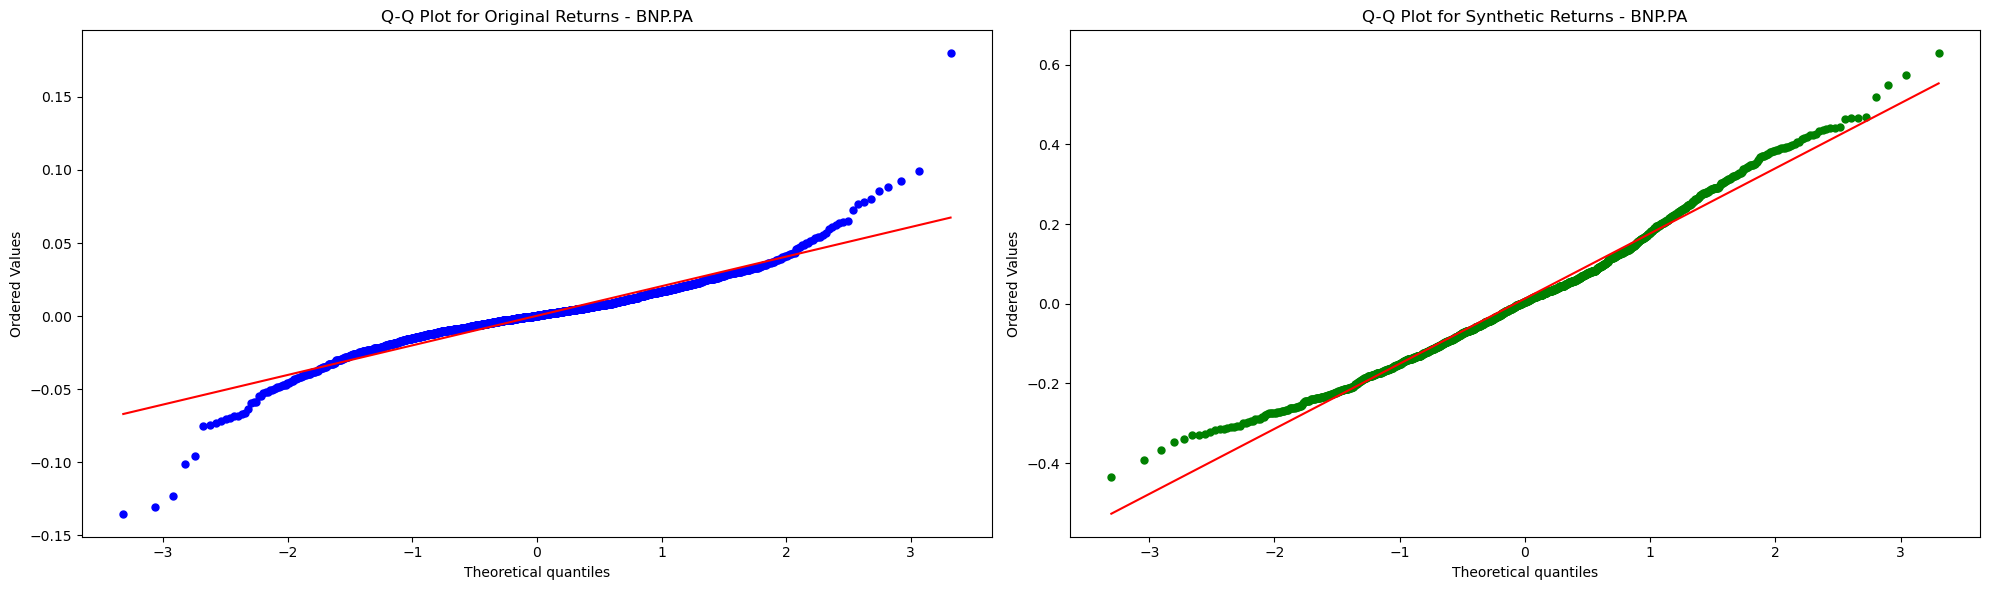


Distributional Analysis for INGA.AS:
K-S Statistic: 0.3608
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	-0.0127		0.6123
Kurtosis:	11.8990		1.1030


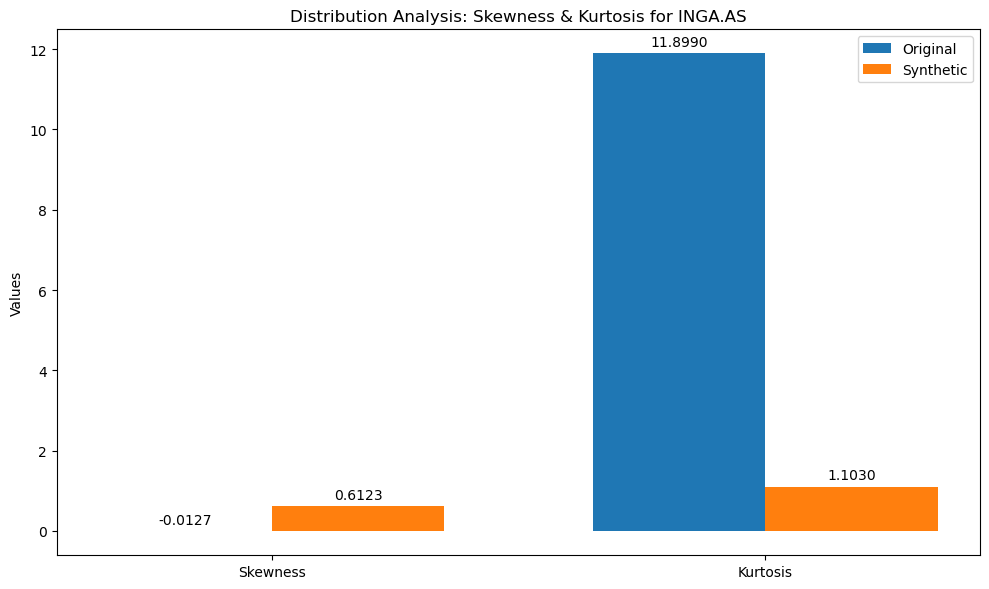

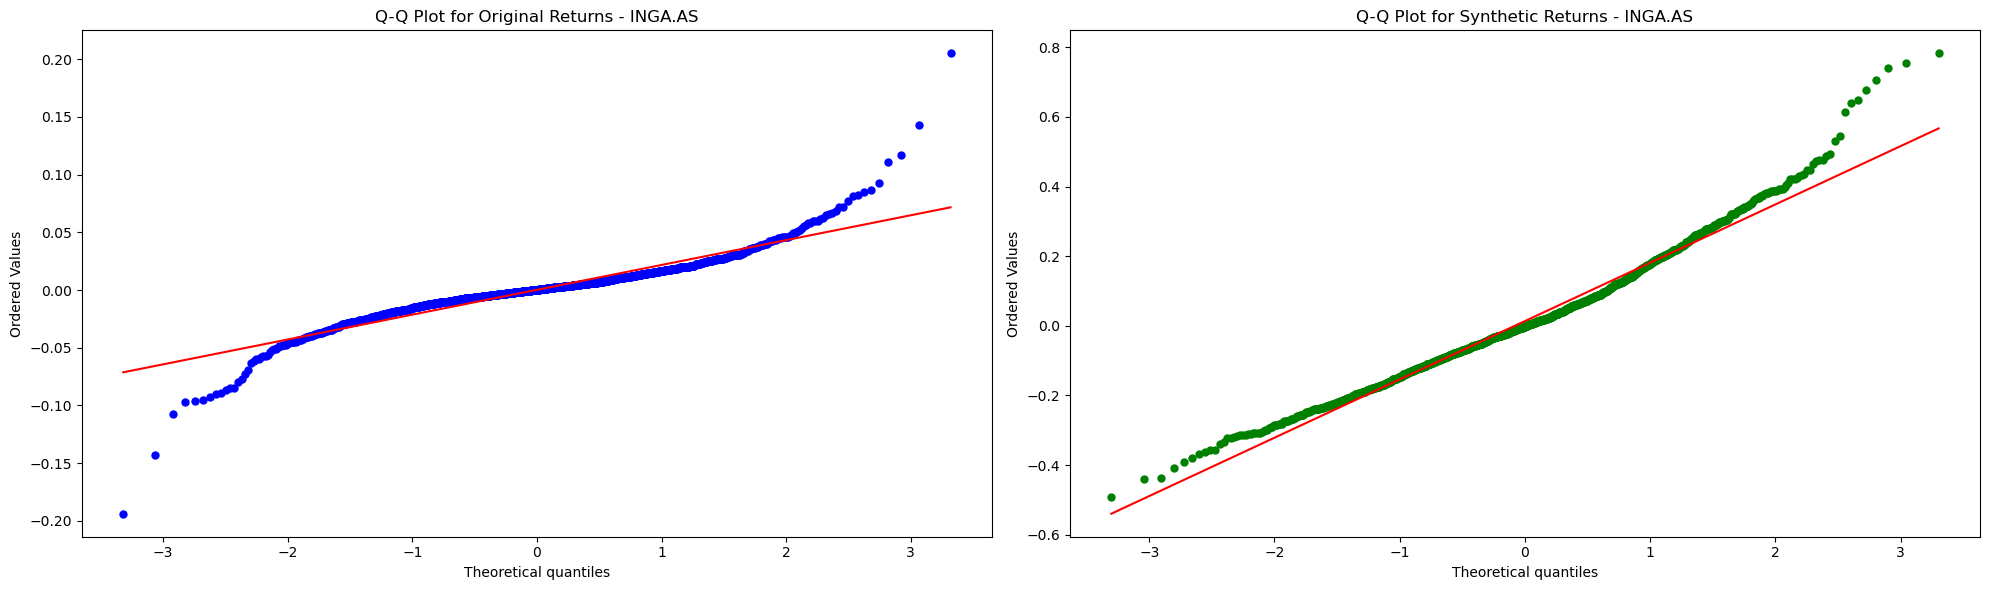


Distributional Analysis for ISP.MI:
K-S Statistic: 0.3844
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	-0.8059		0.4293
Kurtosis:	8.6975		0.4551


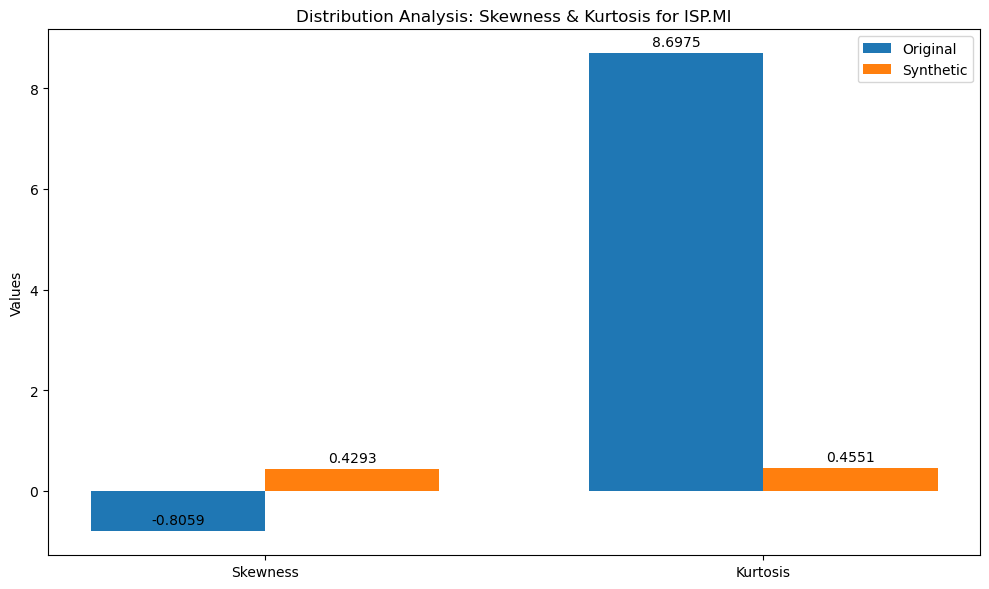

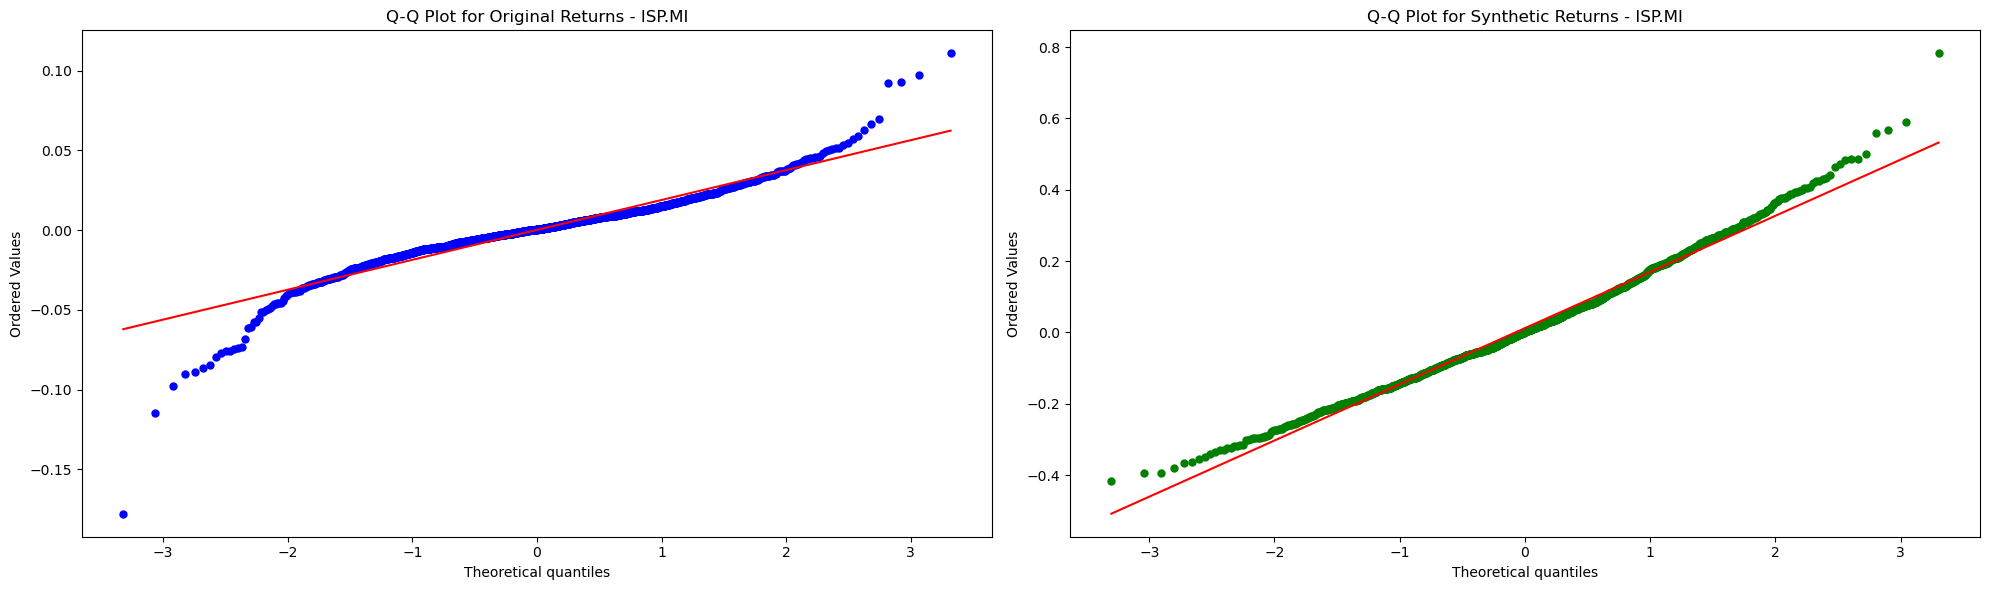


Distributional Analysis for NDA-FI.HE:
K-S Statistic: 0.3991
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	-0.7990		0.6485
Kurtosis:	7.1040		0.4886


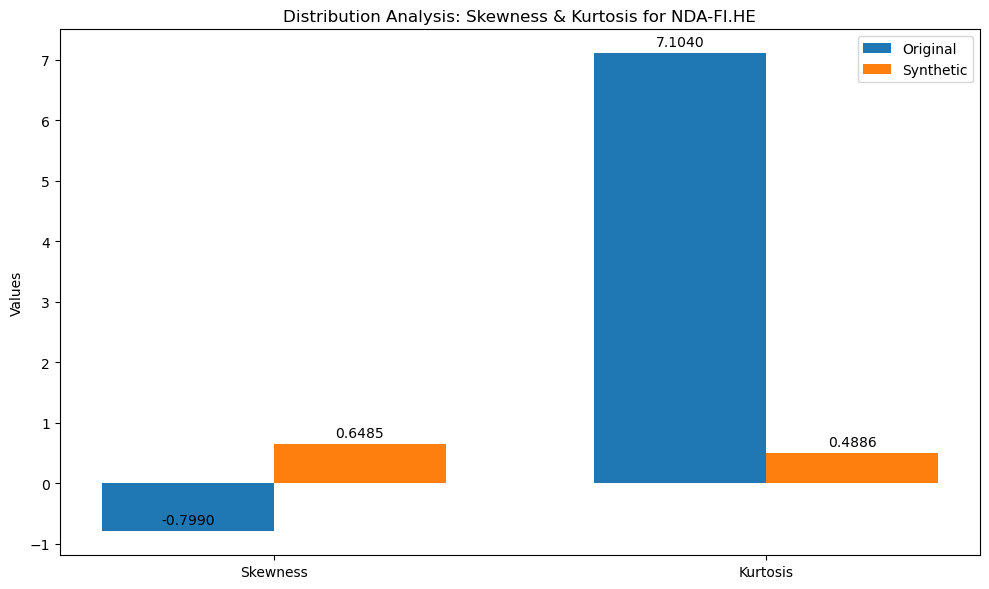

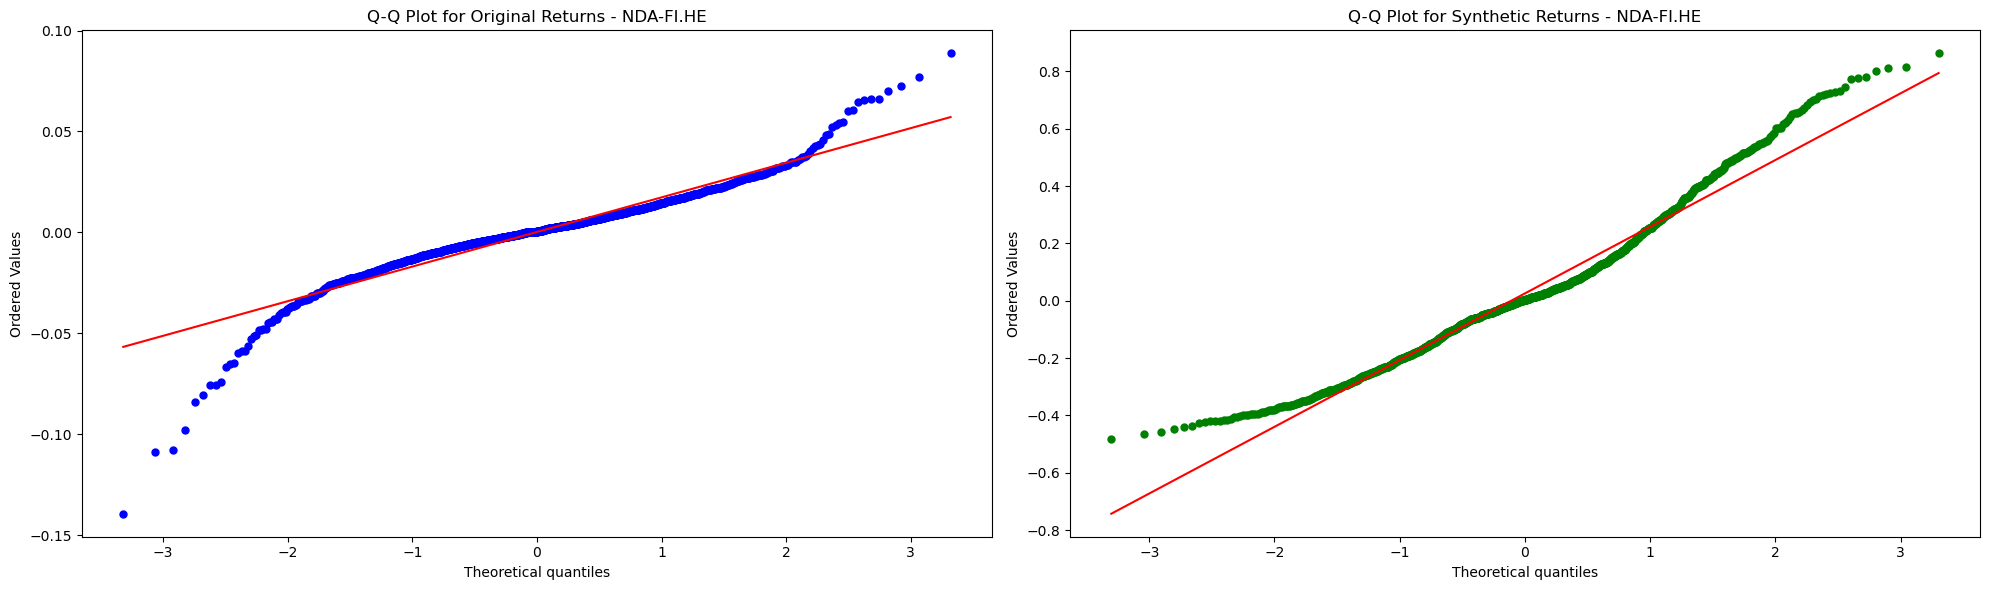


Distributional Analysis for SAN.MC:
K-S Statistic: 0.3826
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	0.1666		0.9068
Kurtosis:	8.0971		1.9530


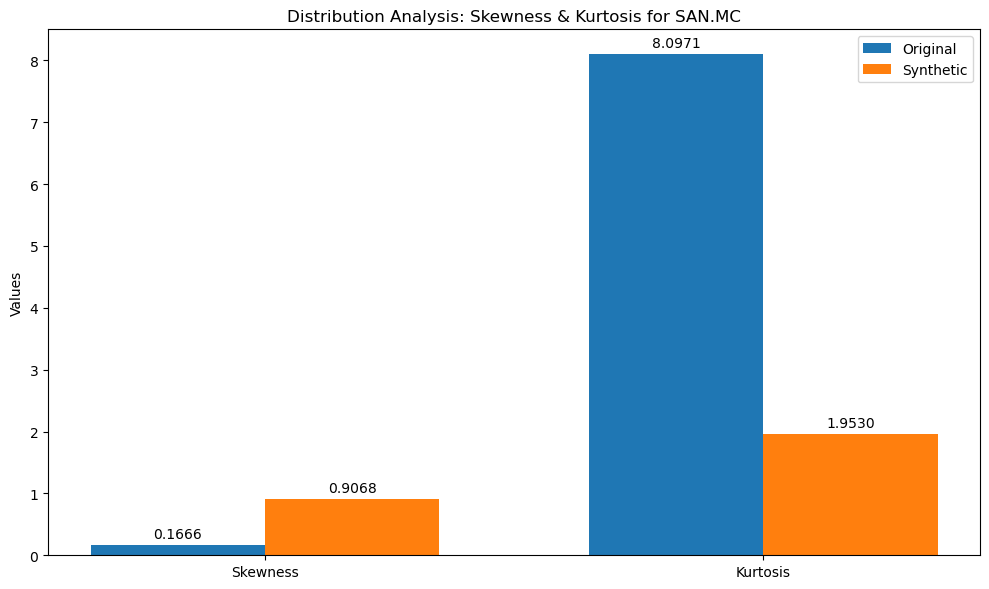

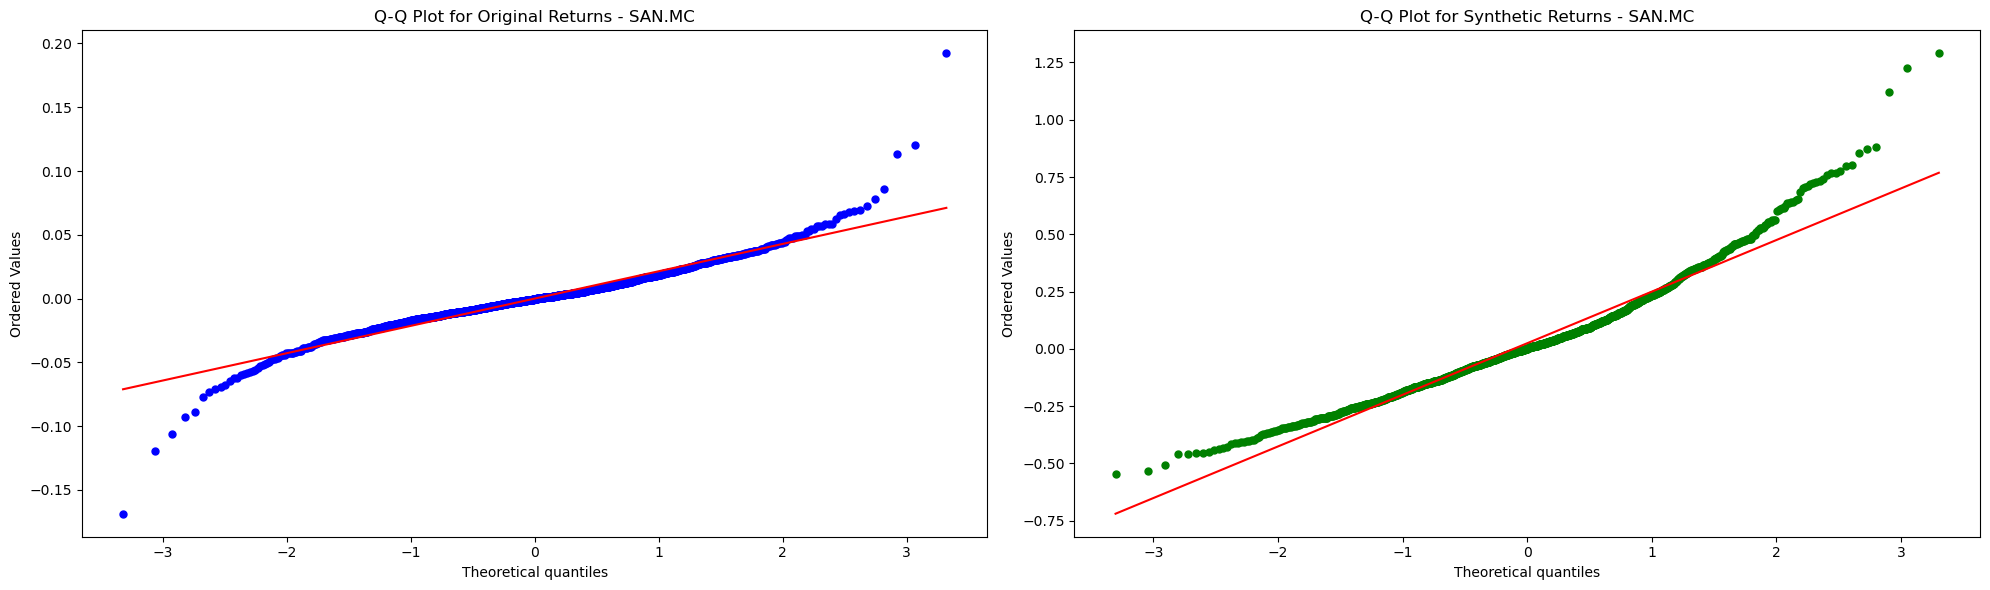


Distributional Analysis for UCG.MI:
K-S Statistic: 0.4219
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	-0.2524		1.3312
Kurtosis:	5.6164		3.3786


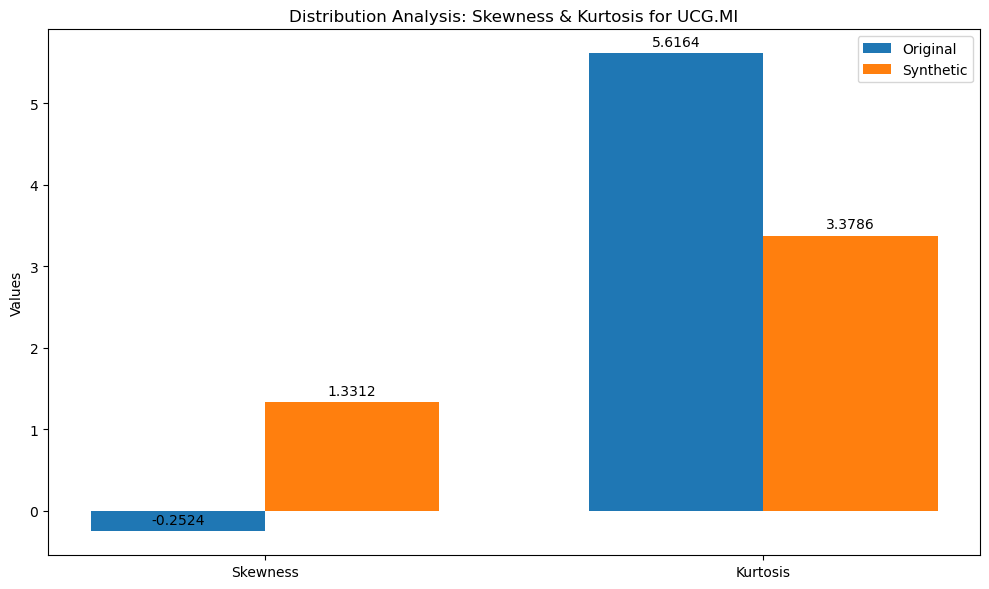

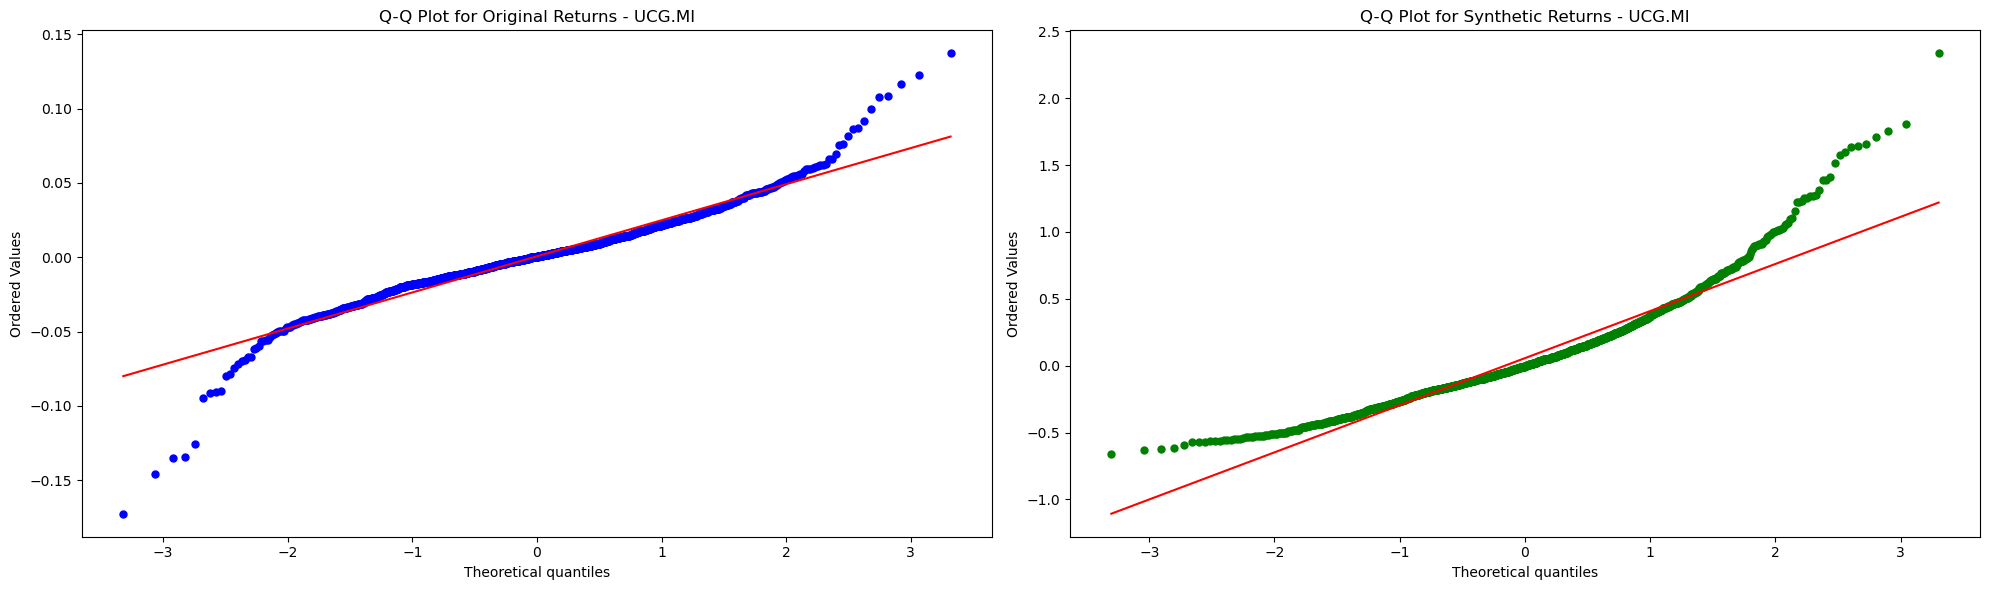

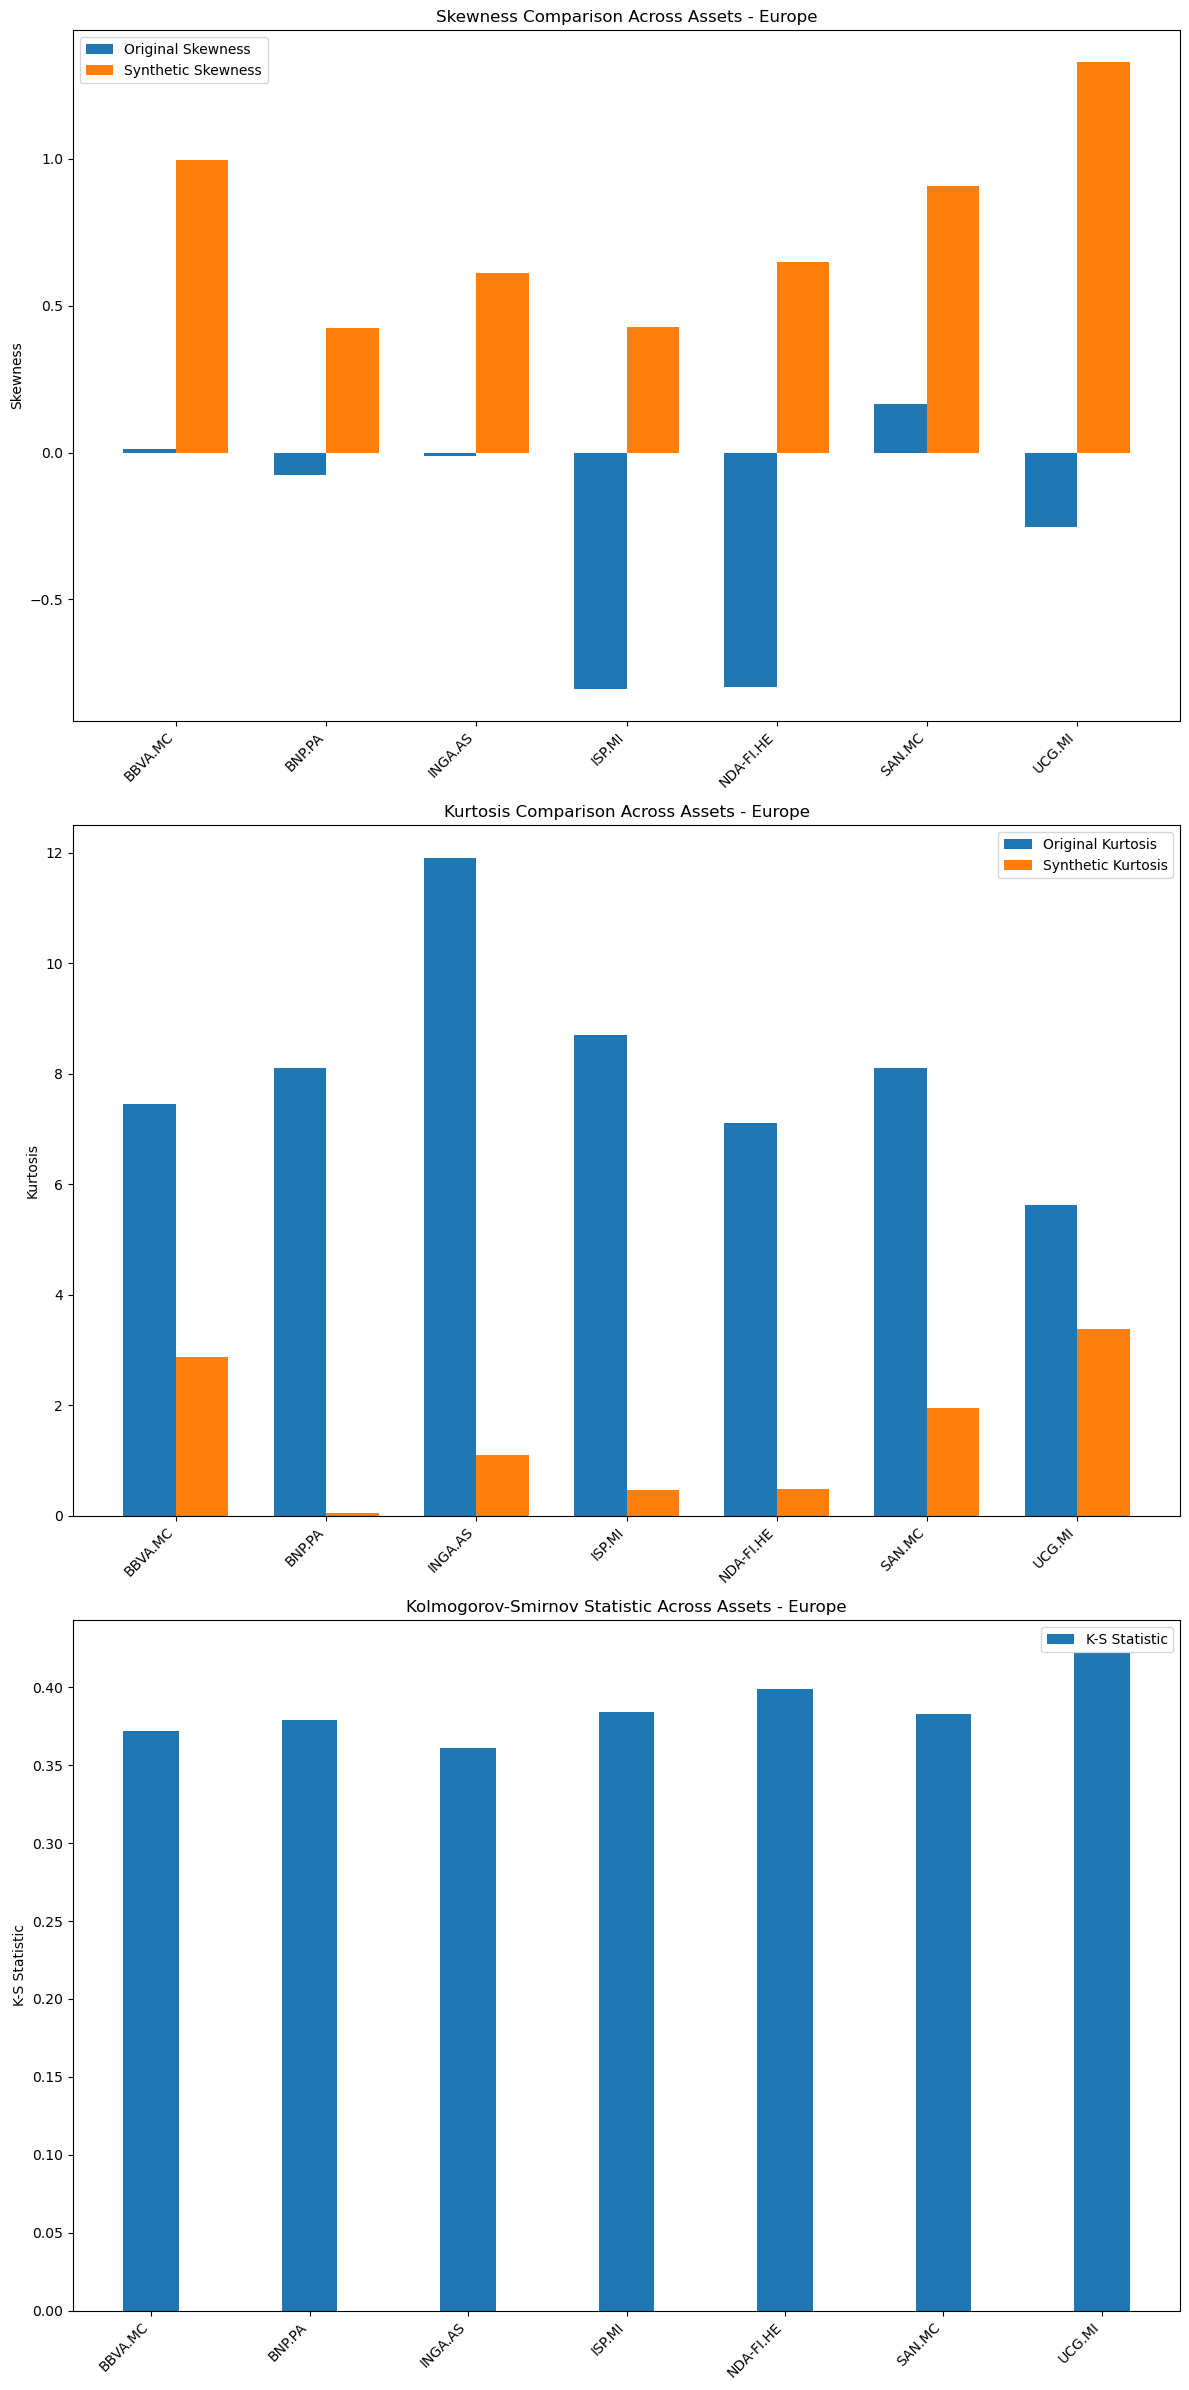


Original Portfolio:

Portfolio Distribution Metrics:
Skewness: -0.4369
Kurtosis: 9.5416


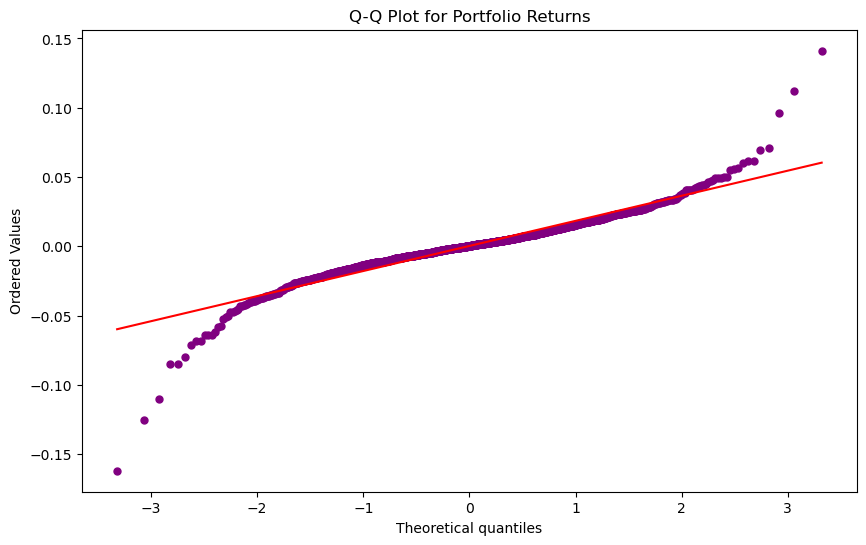


Synthetic Portfolio:

Portfolio Distribution Metrics:
Skewness: 0.6893
Kurtosis: 1.0295


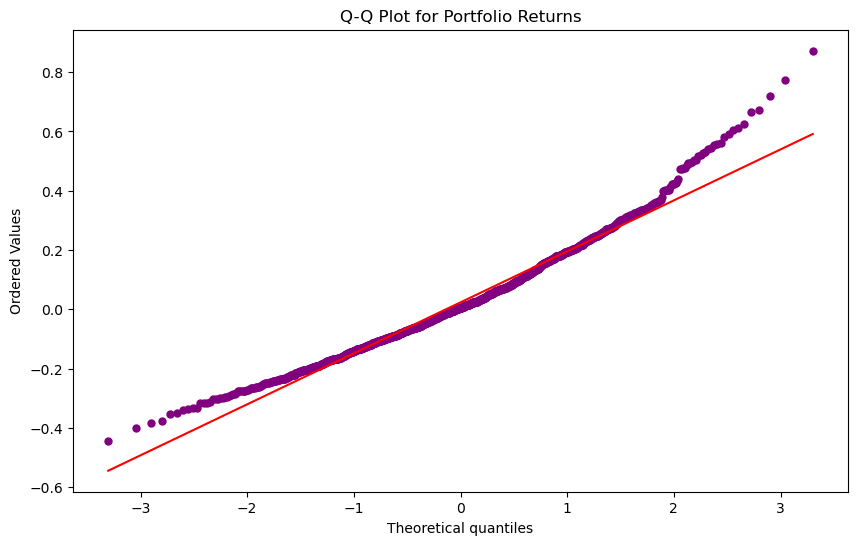

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

def analyze_distribution(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()

    # Lists to store metrics for aggregate chart
    assets = []
    original_skewness = []
    synthetic_skewness = []
    original_kurtosis = []
    synthetic_kurtosis = []
    ks_statistics = []

    for column in original_returns.columns:
        # K-S Test
        ks_statistic, ks_pvalue = stats.ks_2samp(original_returns[column], synthetic_returns[column])

        # Skewness and Kurtosis
        orig_skew = stats.skew(original_returns[column])
        synth_skew = stats.skew(synthetic_returns[column])
        orig_kurt = stats.kurtosis(original_returns[column])
        synth_kurt = stats.kurtosis(synthetic_returns[column])

        # Store metrics for aggregate chart
        assets.append(column)
        original_skewness.append(orig_skew)
        synthetic_skewness.append(synth_skew)
        original_kurtosis.append(orig_kurt)
        synthetic_kurtosis.append(synth_kurt)
        ks_statistics.append(ks_statistic)

        # Print Results
        print(f"\nDistributional Analysis for {column}:")
        print(f"K-S Statistic: {ks_statistic:.4f}")
        print(f"K-S P-value: {ks_pvalue:.4f}")
        print("\nMetrics\t\tOriginal\tSynthetic")
        print(f"Skewness:\t{orig_skew:.4f}\t\t{synth_skew:.4f}")
        print(f"Kurtosis:\t{orig_kurt:.4f}\t\t{synth_kurt:.4f}")

        # Individual asset visualization
        labels = ['Skewness', 'Kurtosis']
        original_metrics = [orig_skew, orig_kurt]
        synthetic_metrics = [synth_skew, synth_kurt]

        x = np.arange(len(labels))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 6))
        rects1 = ax.bar(x - width/2, original_metrics, width, label='Original')
        rects2 = ax.bar(x + width/2, synthetic_metrics, width, label='Synthetic')

        ax.set_ylabel('Values')
        ax.set_title(f'Distribution Analysis: Skewness & Kurtosis for {column}')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.4f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        plt.tight_layout()
        plt.show()

        # Q-Q plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        
        stats.probplot(original_returns[column], dist="norm", plot=ax1, fit=True)
        ax1.get_lines()[0].set_markerfacecolor('blue')
        ax1.get_lines()[0].set_markeredgecolor('blue')
        ax1.get_lines()[0].set_markersize(5)
        ax1.get_lines()[1].set_color('red')
        ax1.set_title(f'Q-Q Plot for Original Returns - {column}')

        stats.probplot(synthetic_returns[column], dist="norm", plot=ax2, fit=True)
        ax2.get_lines()[0].set_markerfacecolor('green')
        ax2.get_lines()[0].set_markeredgecolor('green')
        ax2.get_lines()[0].set_markersize(5)
        ax2.get_lines()[1].set_color('red')
        ax2.set_title(f'Q-Q Plot for Synthetic Returns - {column}')

        plt.tight_layout()
        plt.show()

    # Aggregate charts
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 24))
    x = np.arange(len(assets))
    width = 0.35

    # Skewness comparison
    ax1.bar(x - width/2, original_skewness, width, label='Original Skewness')
    ax1.bar(x + width/2, synthetic_skewness, width, label='Synthetic Skewness')
    ax1.set_ylabel('Skewness')
    ax1.set_title('Skewness Comparison Across Assets - Europe')
    ax1.set_xticks(x)
    ax1.set_xticklabels(assets, rotation=45, ha='right')
    ax1.legend()

    # Kurtosis comparison
    ax2.bar(x - width/2, original_kurtosis, width, label='Original Kurtosis')
    ax2.bar(x + width/2, synthetic_kurtosis, width, label='Synthetic Kurtosis')
    ax2.set_ylabel('Kurtosis')
    ax2.set_title('Kurtosis Comparison Across Assets - Europe')
    ax2.set_xticks(x)
    ax2.set_xticklabels(assets, rotation=45, ha='right')
    ax2.legend()

    # K-S statistic comparison
    ax3.bar(x, ks_statistics, width, label='K-S Statistic')
    ax3.set_ylabel('K-S Statistic')
    ax3.set_title('Kolmogorov-Smirnov Statistic Across Assets - Europe')
    ax3.set_xticks(x)
    ax3.set_xticklabels(assets, rotation=45, ha='right')
    ax3.legend()

    plt.tight_layout()
    plt.show()

def analyze_portfolio_distribution(data, weights=None):
    if weights is None:
        weights = np.ones(len(data.columns)) / len(data.columns)  # Equal weights if not provided
    
    portfolio_returns = (data.pct_change().dropna() * weights).sum(axis=1)
    
    print("\nPortfolio Distribution Metrics:")
    print(f"Skewness: {stats.skew(portfolio_returns):.4f}")
    print(f"Kurtosis: {stats.kurtosis(portfolio_returns):.4f}")
    
    # Q-Q plot for portfolio
    fig, ax = plt.subplots(figsize=(10, 6))
    stats.probplot(portfolio_returns, dist="norm", plot=ax, fit=True)
    ax.get_lines()[0].set_markerfacecolor('purple')
    ax.get_lines()[0].set_markeredgecolor('purple')
    ax.get_lines()[0].set_markersize(5)
    ax.get_lines()[1].set_color('red')
    ax.set_title('Q-Q Plot for Portfolio Returns')
    plt.show()

# Assuming stock_data and rescaled_synthetic_data are available
# If they're not, you might need to load or recreate them here

# Perform the distributional analysis
analyze_distribution(stock_data, rescaled_synthetic_data)

print("\nOriginal Portfolio:")
analyze_portfolio_distribution(stock_data)

print("\nSynthetic Portfolio:")
analyze_portfolio_distribution(rescaled_synthetic_data)

# Spectral Analysis

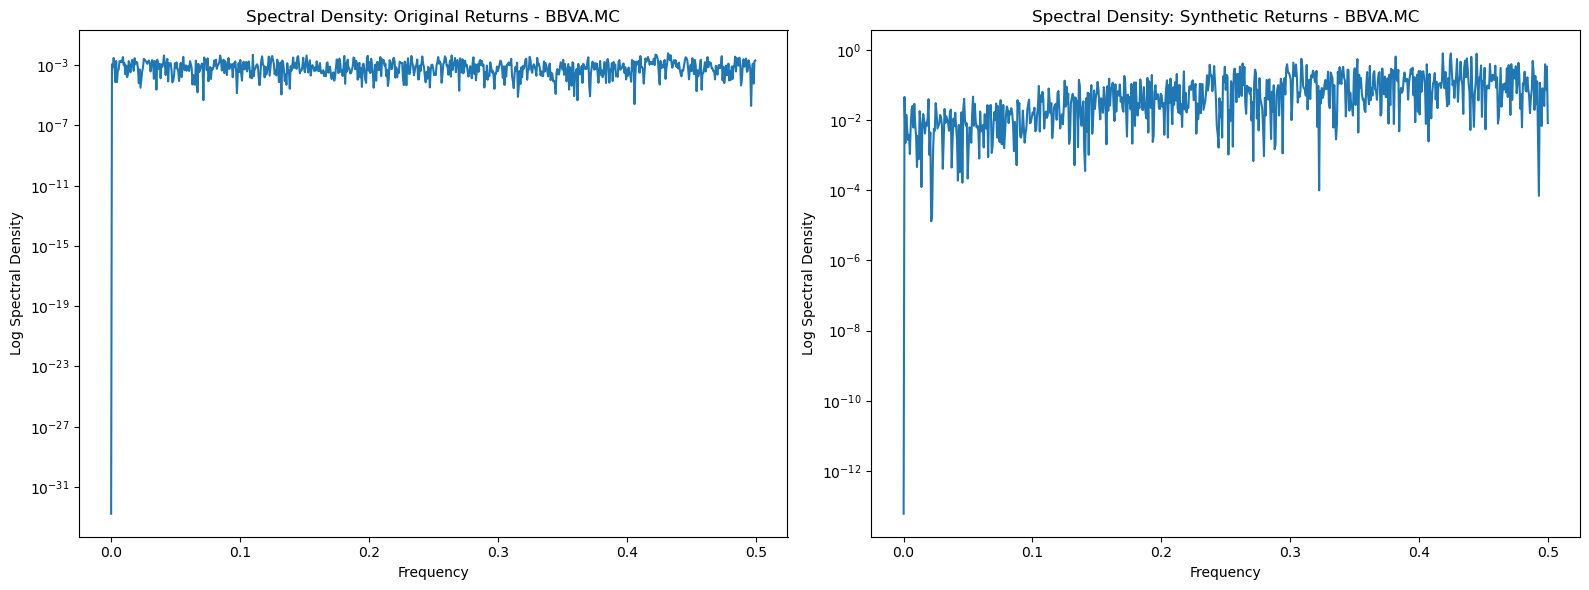


Spectral Analysis for BBVA.MC:
Original Returns - Spectral Density Statistics:
Max: 0.00611
Min: 0.00000
Mean: 0.00103
Median: 0.00074
Standard Deviation: 0.00099

Synthetic Returns - Spectral Density Statistics:
Max: 0.79289
Min: 0.00000
Mean: 0.08686
Median: 0.04140
Standard Deviation: 0.11392


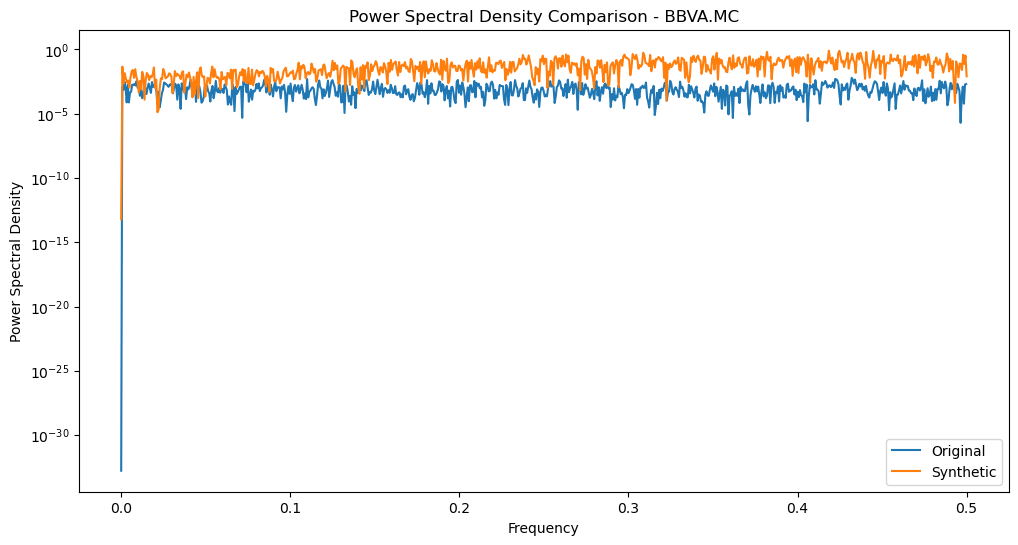

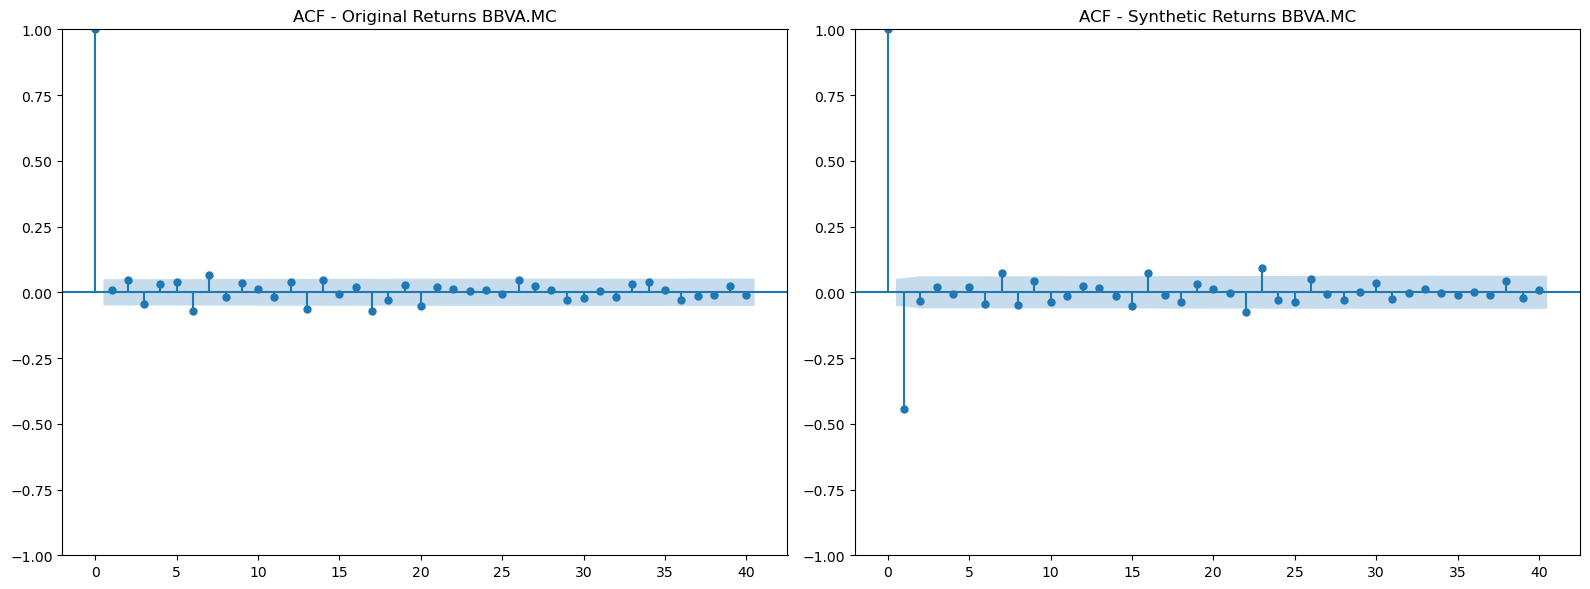

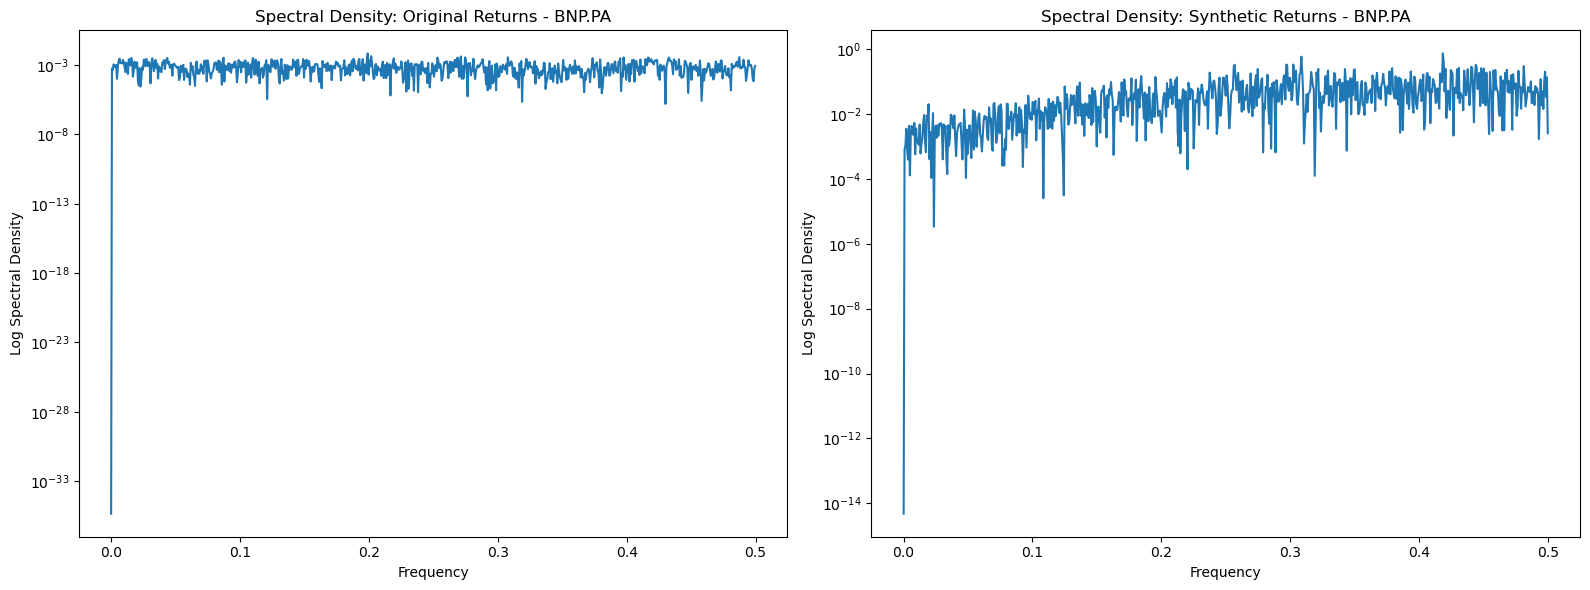


Spectral Analysis for BNP.PA:
Original Returns - Spectral Density Statistics:
Max: 0.00696
Min: 0.00000
Mean: 0.00089
Median: 0.00067
Standard Deviation: 0.00083

Synthetic Returns - Spectral Density Statistics:
Max: 0.74825
Min: 0.00000
Mean: 0.05390
Median: 0.02663
Standard Deviation: 0.07309


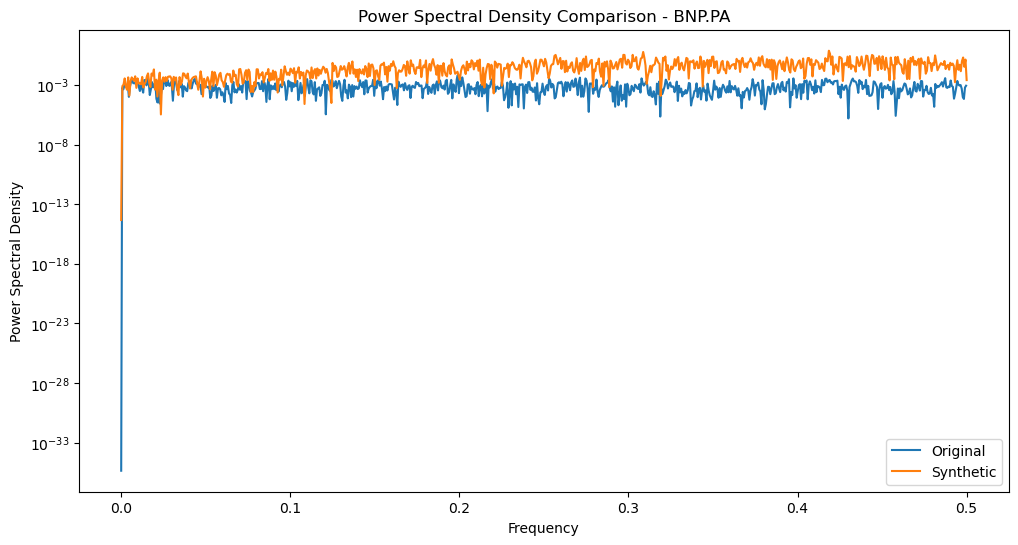

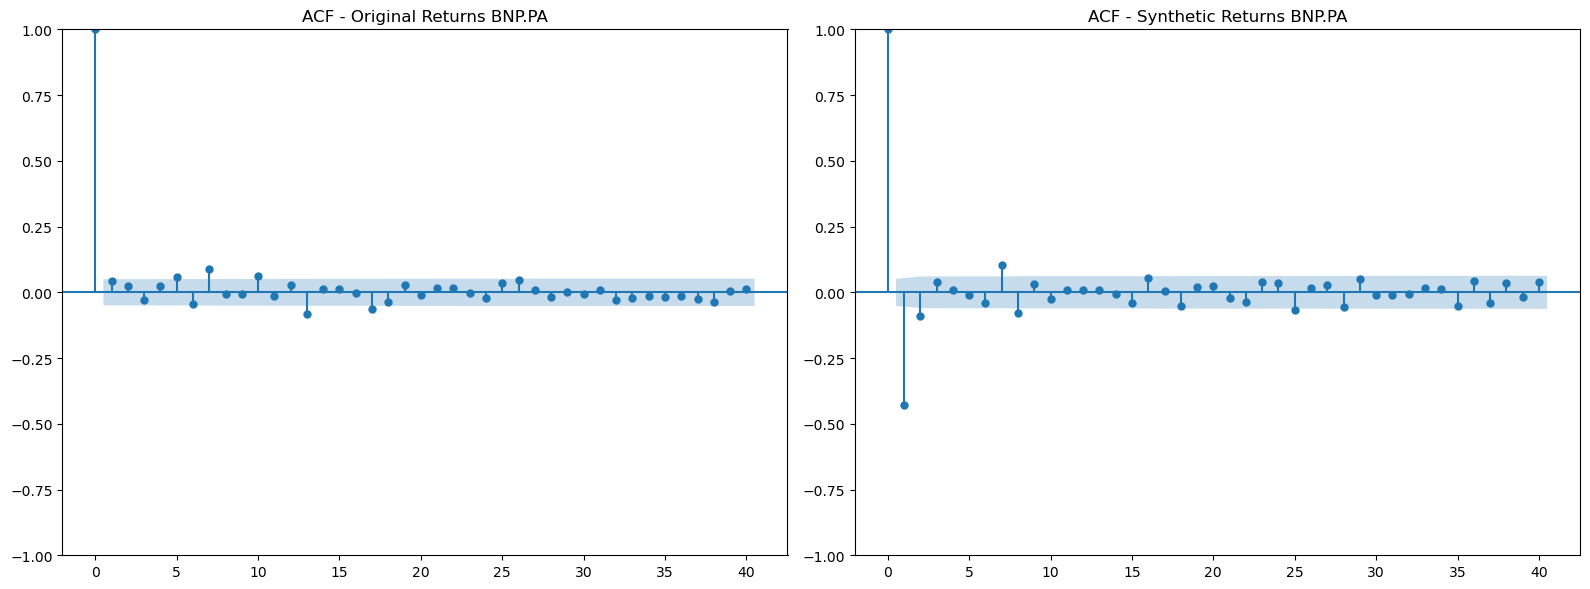

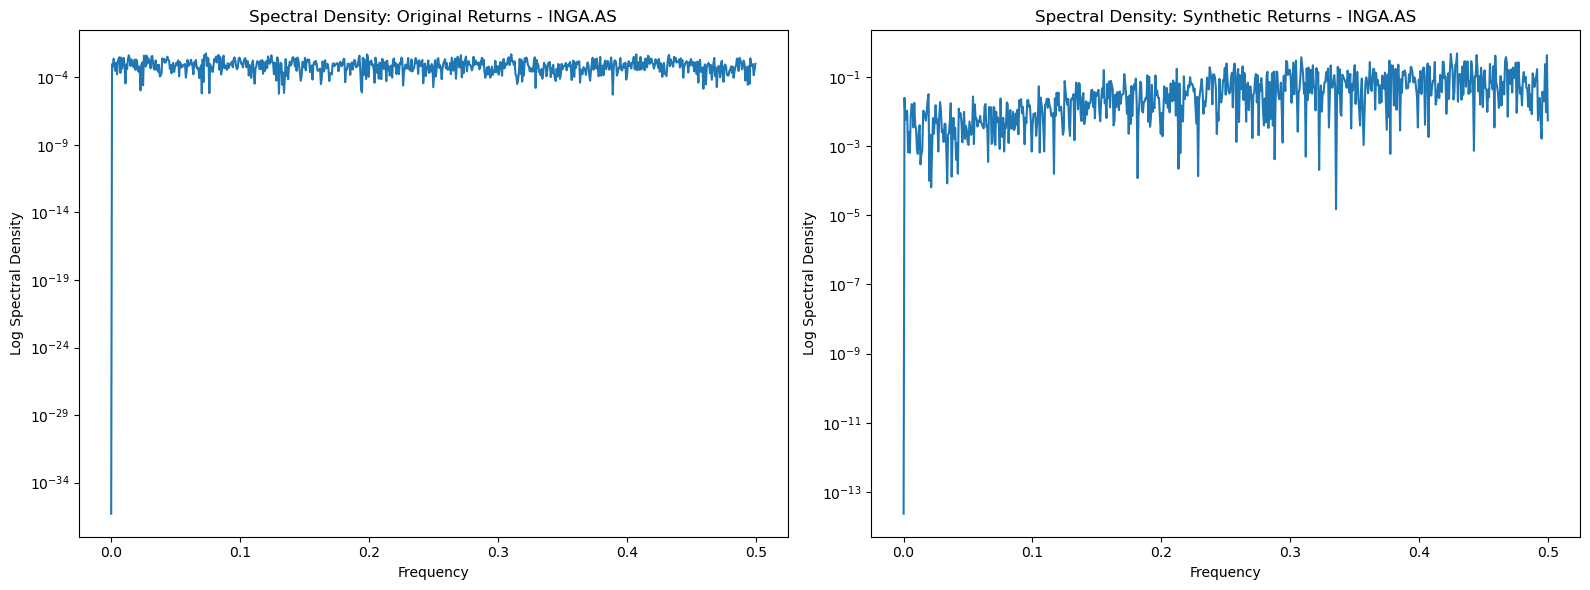


Spectral Analysis for INGA.AS:
Original Returns - Spectral Density Statistics:
Max: 0.00602
Min: 0.00000
Mean: 0.00105
Median: 0.00076
Standard Deviation: 0.00097

Synthetic Returns - Spectral Density Statistics:
Max: 0.48114
Min: 0.00000
Mean: 0.05702
Median: 0.02694
Standard Deviation: 0.07402


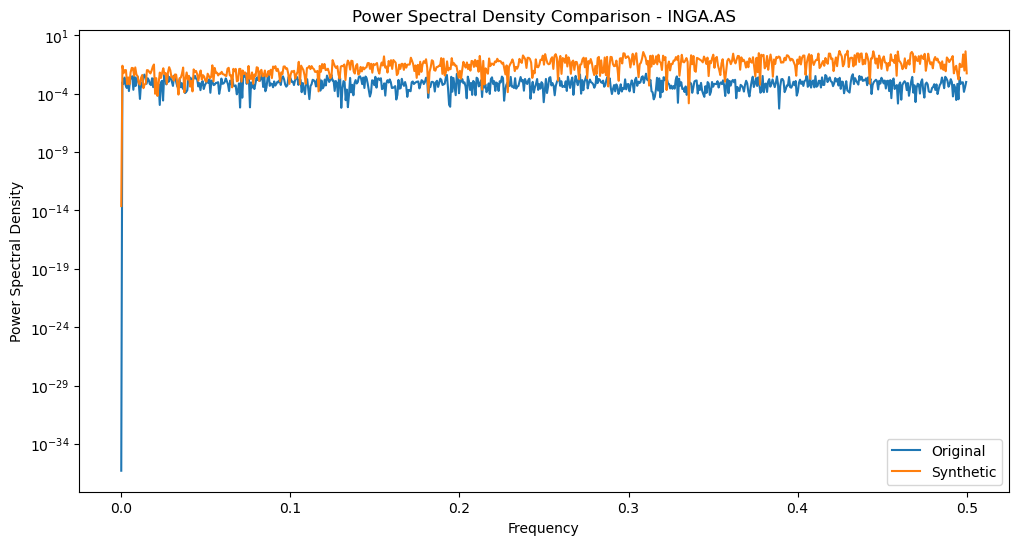

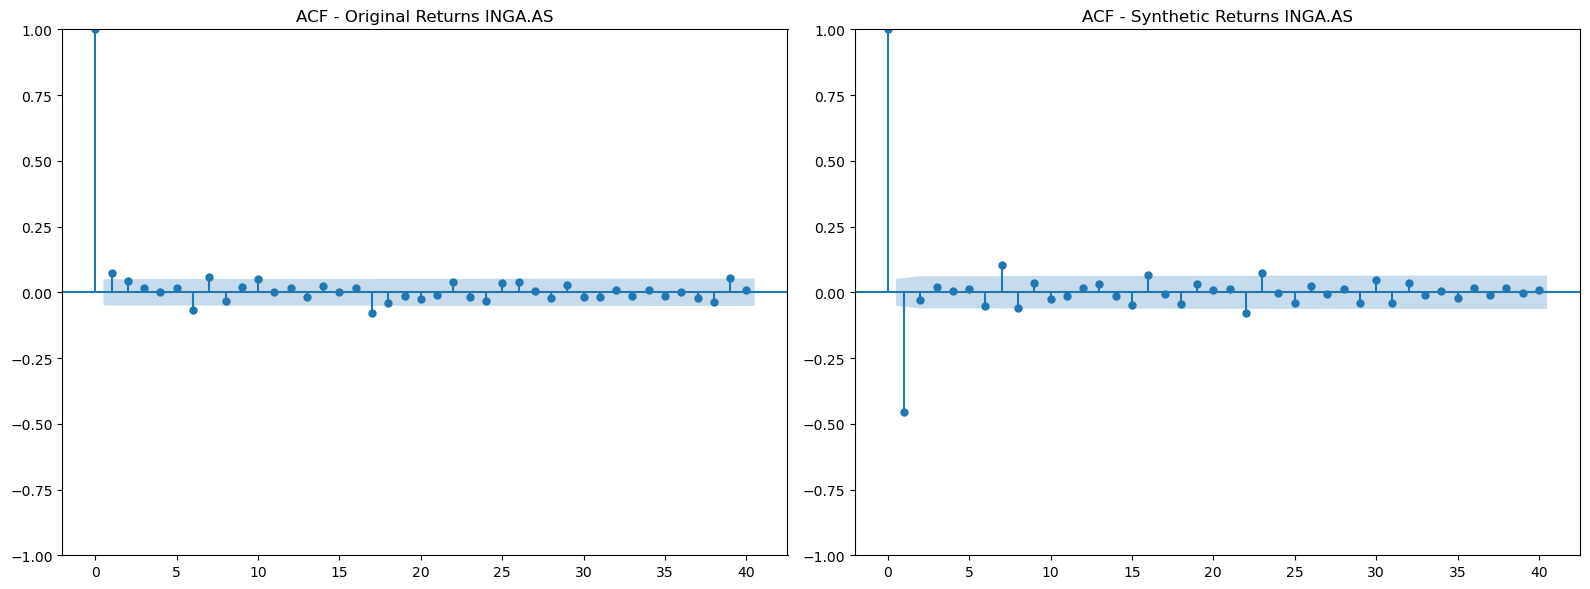

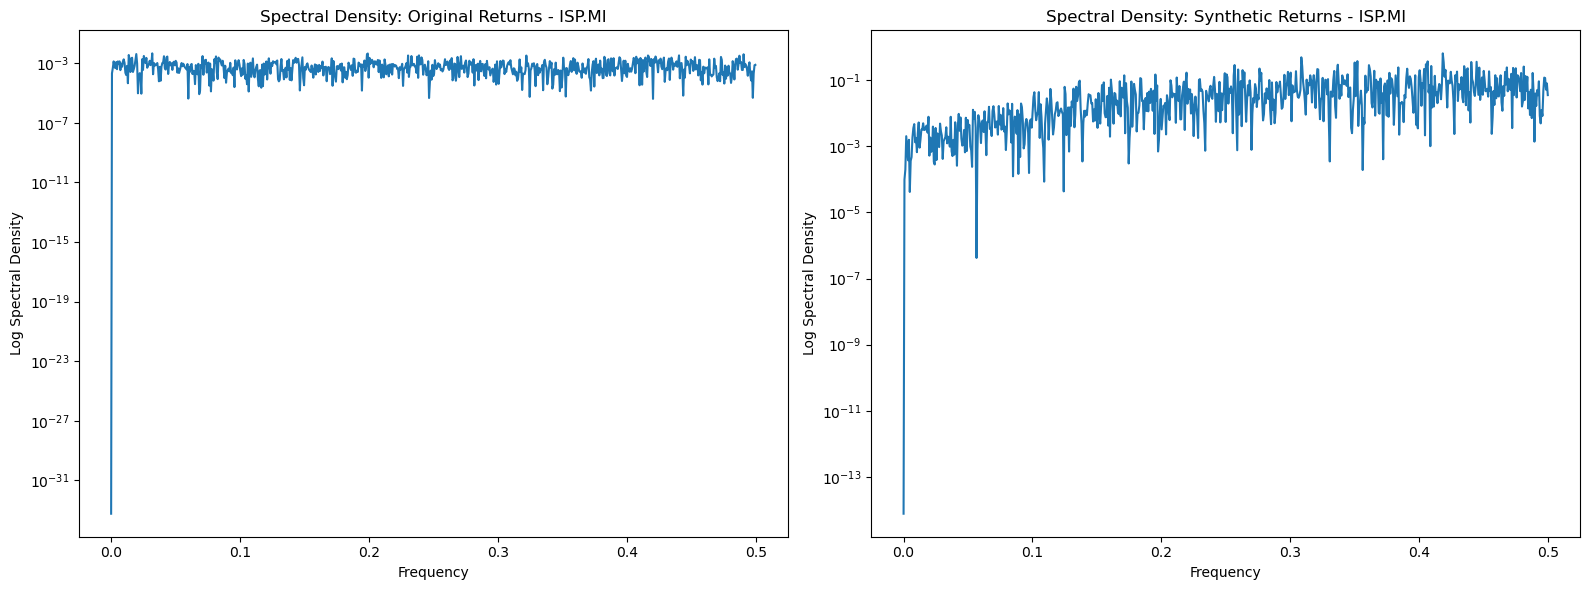


Spectral Analysis for ISP.MI:
Original Returns - Spectral Density Statistics:
Max: 0.00465
Min: 0.00000
Mean: 0.00077
Median: 0.00053
Standard Deviation: 0.00075

Synthetic Returns - Spectral Density Statistics:
Max: 0.65324
Min: 0.00000
Mean: 0.04990
Median: 0.02367
Standard Deviation: 0.06987


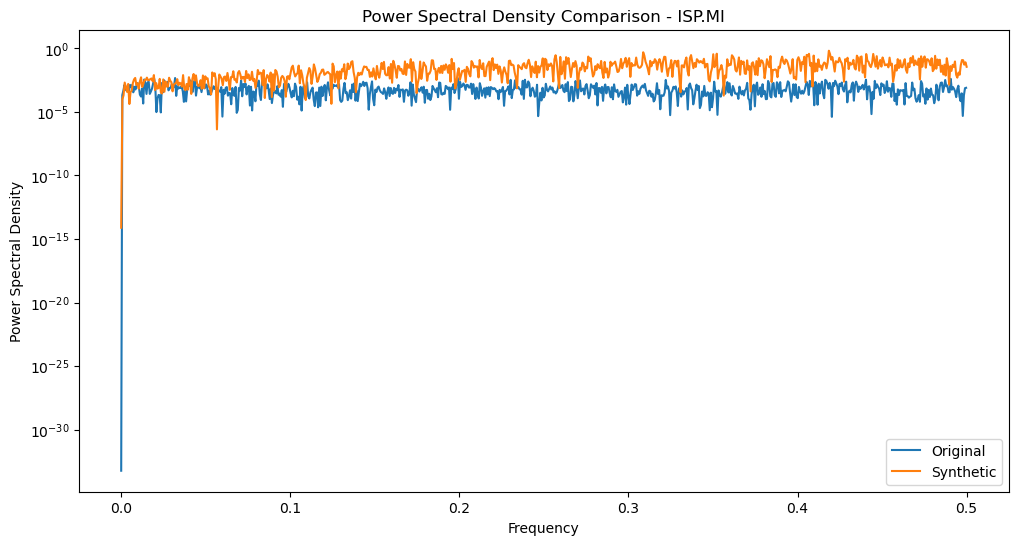

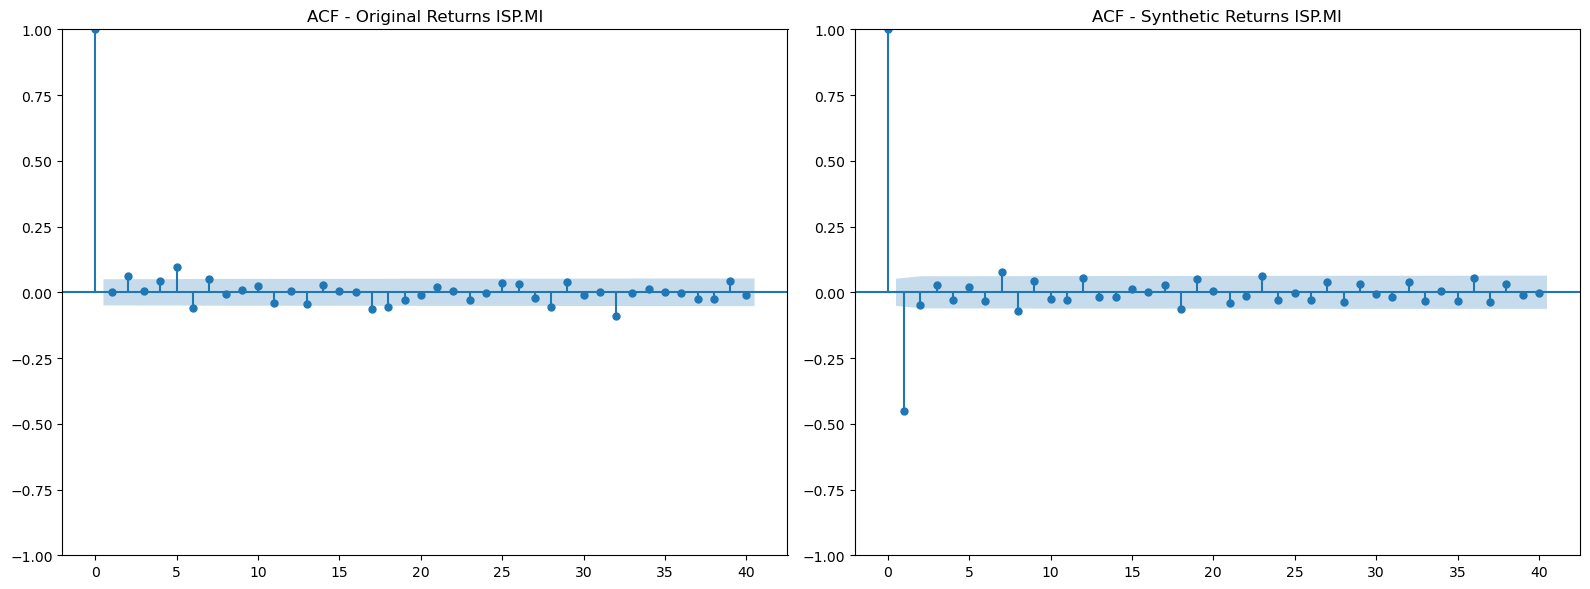

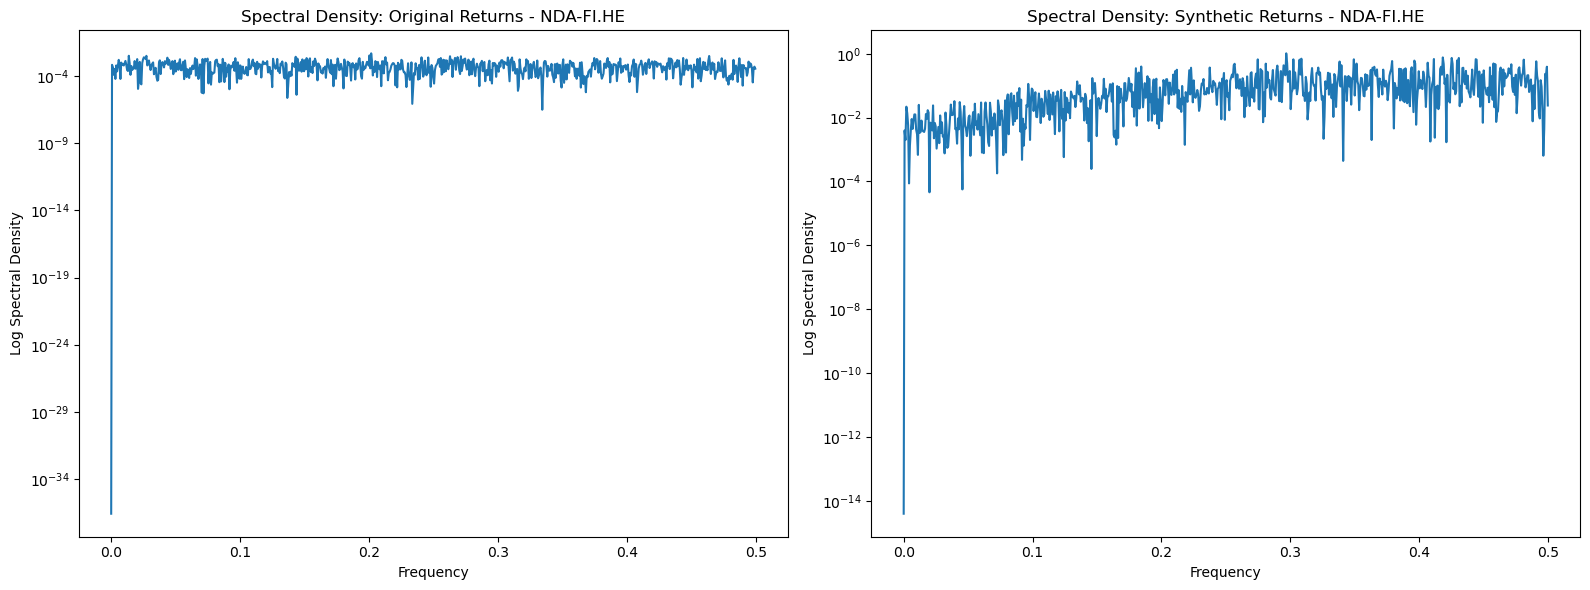


Spectral Analysis for NDA-FI.HE:
Original Returns - Spectral Density Statistics:
Max: 0.00475
Min: 0.00000
Mean: 0.00064
Median: 0.00045
Standard Deviation: 0.00062

Synthetic Returns - Spectral Density Statistics:
Max: 1.02992
Min: 0.00000
Mean: 0.11097
Median: 0.05535
Standard Deviation: 0.14198


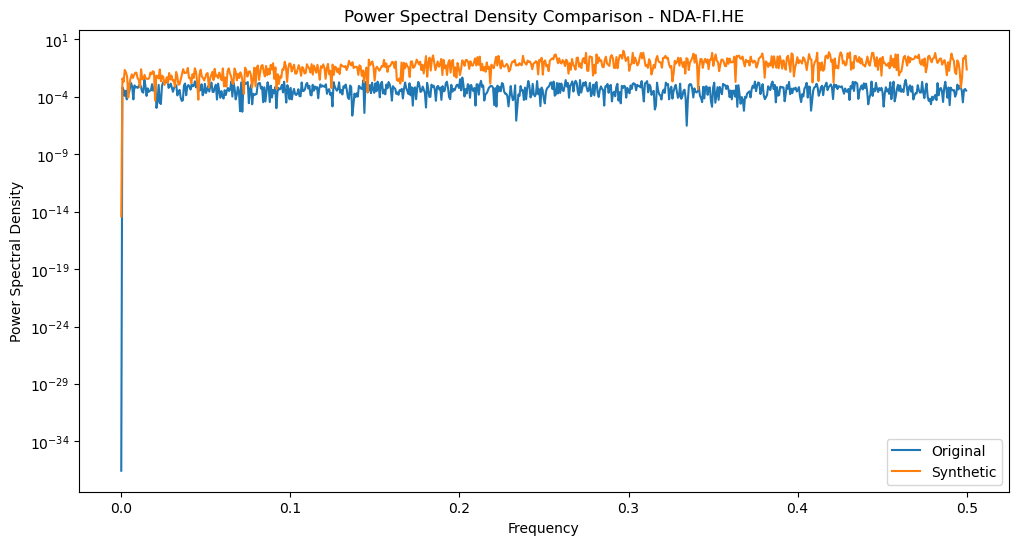

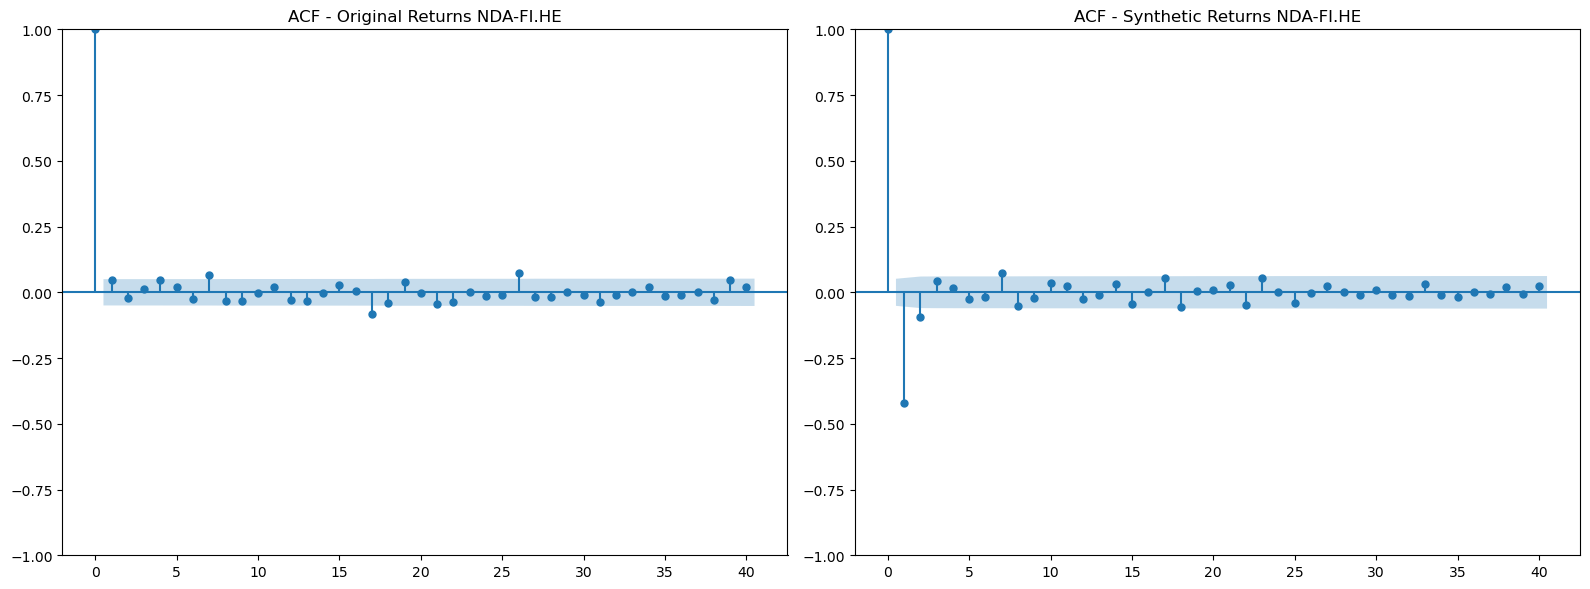

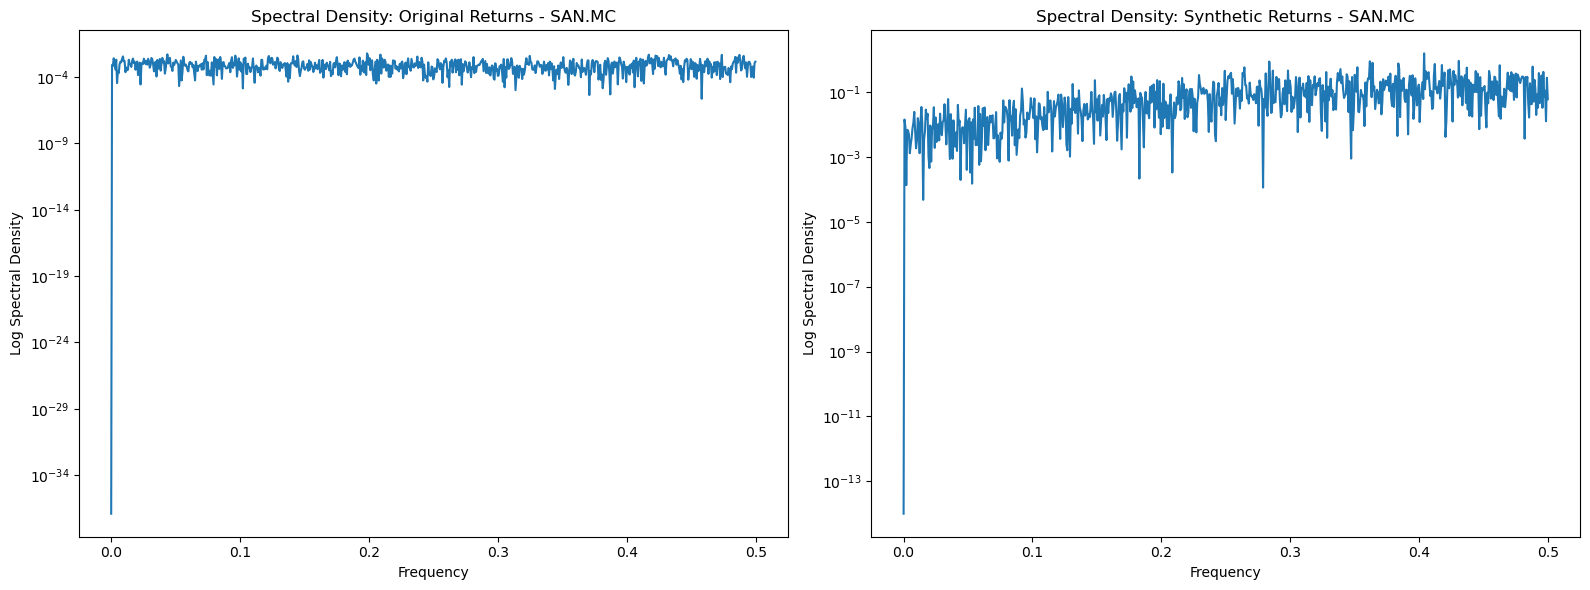


Spectral Analysis for SAN.MC:
Original Returns - Spectral Density Statistics:
Max: 0.00607
Min: 0.00000
Mean: 0.00098
Median: 0.00072
Standard Deviation: 0.00092

Synthetic Returns - Spectral Density Statistics:
Max: 1.54237
Min: 0.00000
Mean: 0.10520
Median: 0.05211
Standard Deviation: 0.14304


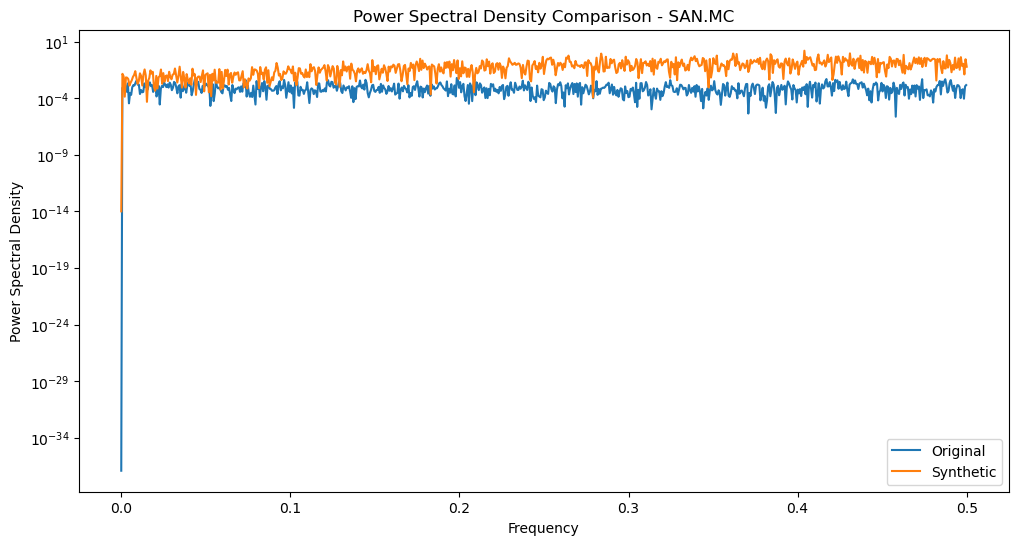

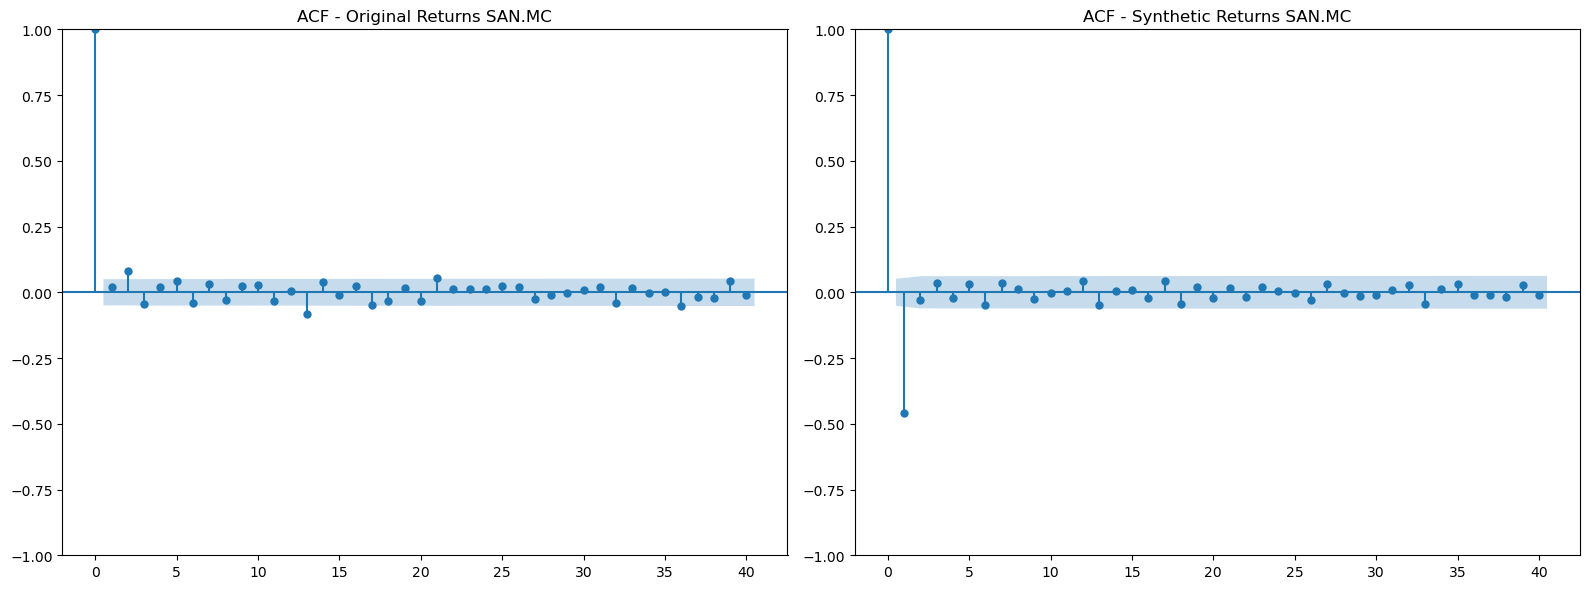

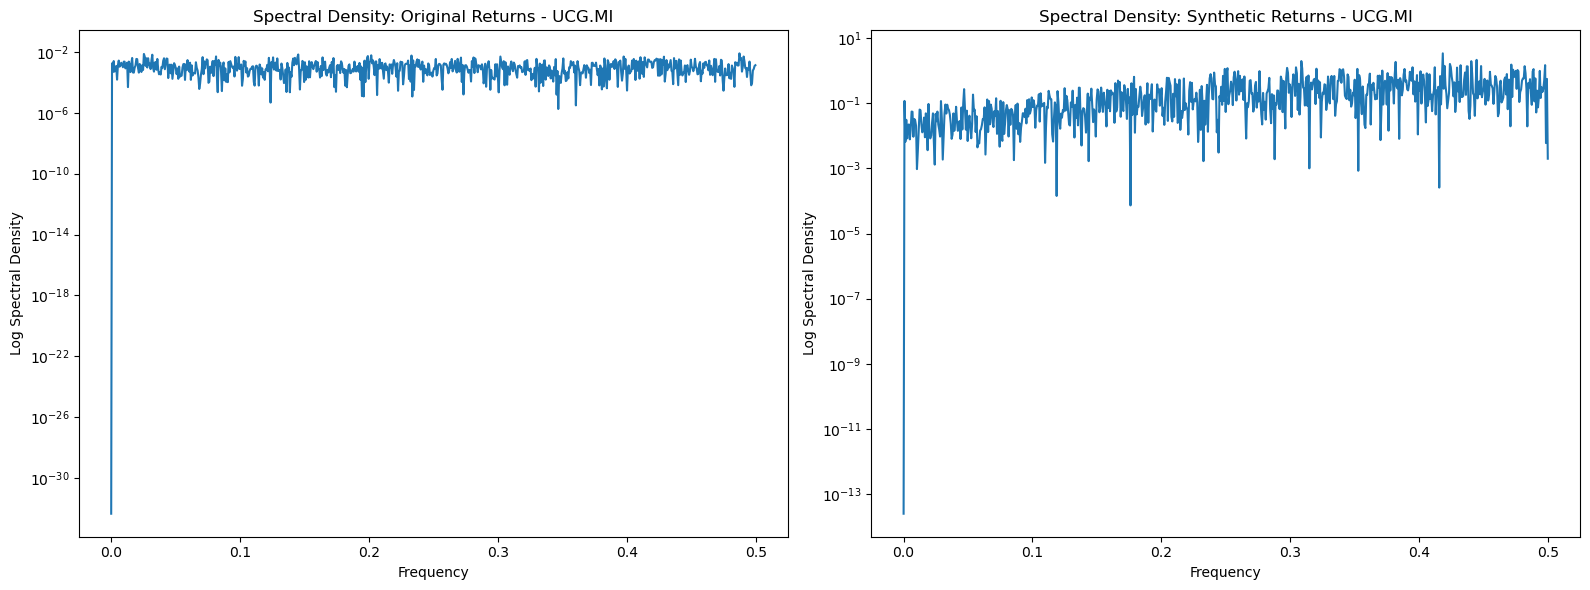


Spectral Analysis for UCG.MI:
Original Returns - Spectral Density Statistics:
Max: 0.00806
Min: 0.00000
Mean: 0.00125
Median: 0.00089
Standard Deviation: 0.00119

Synthetic Returns - Spectral Density Statistics:
Max: 3.45578
Min: 0.00000
Mean: 0.26758
Median: 0.12604
Standard Deviation: 0.35197


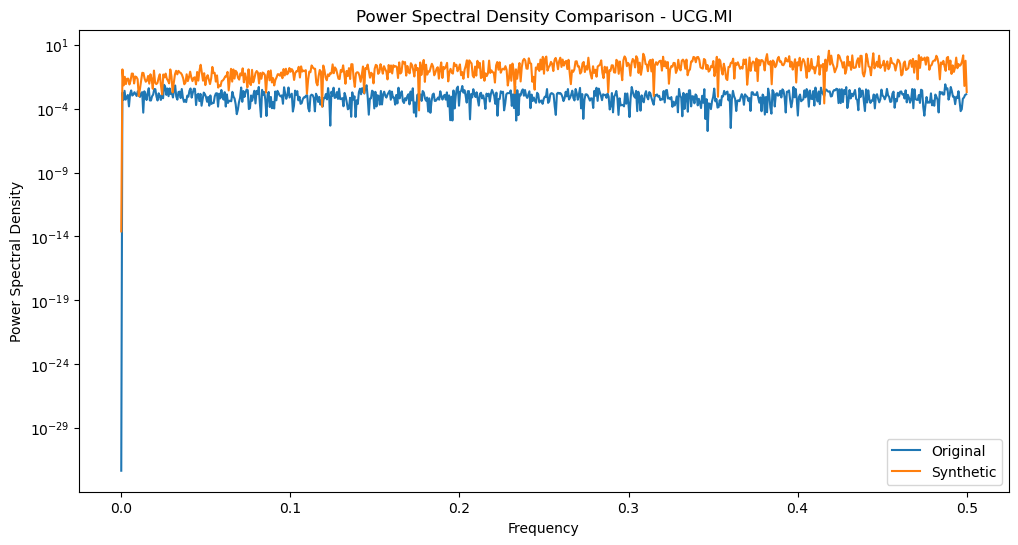

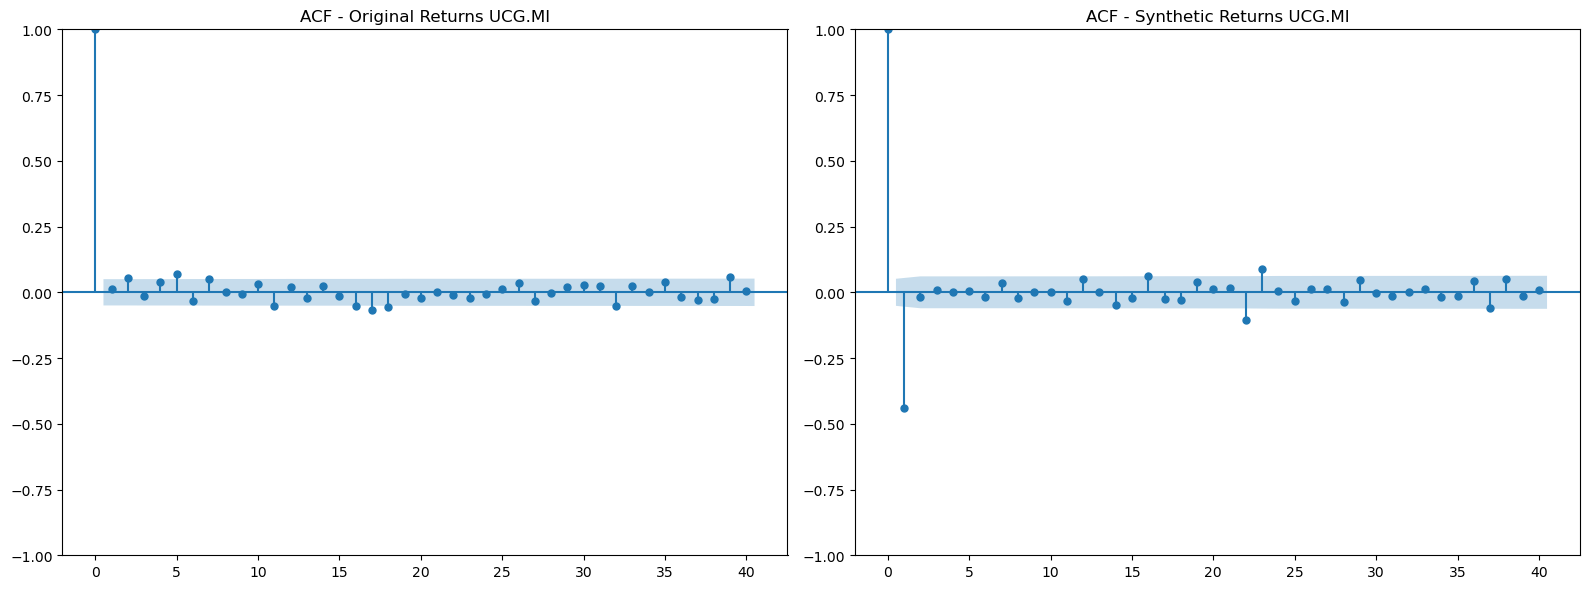

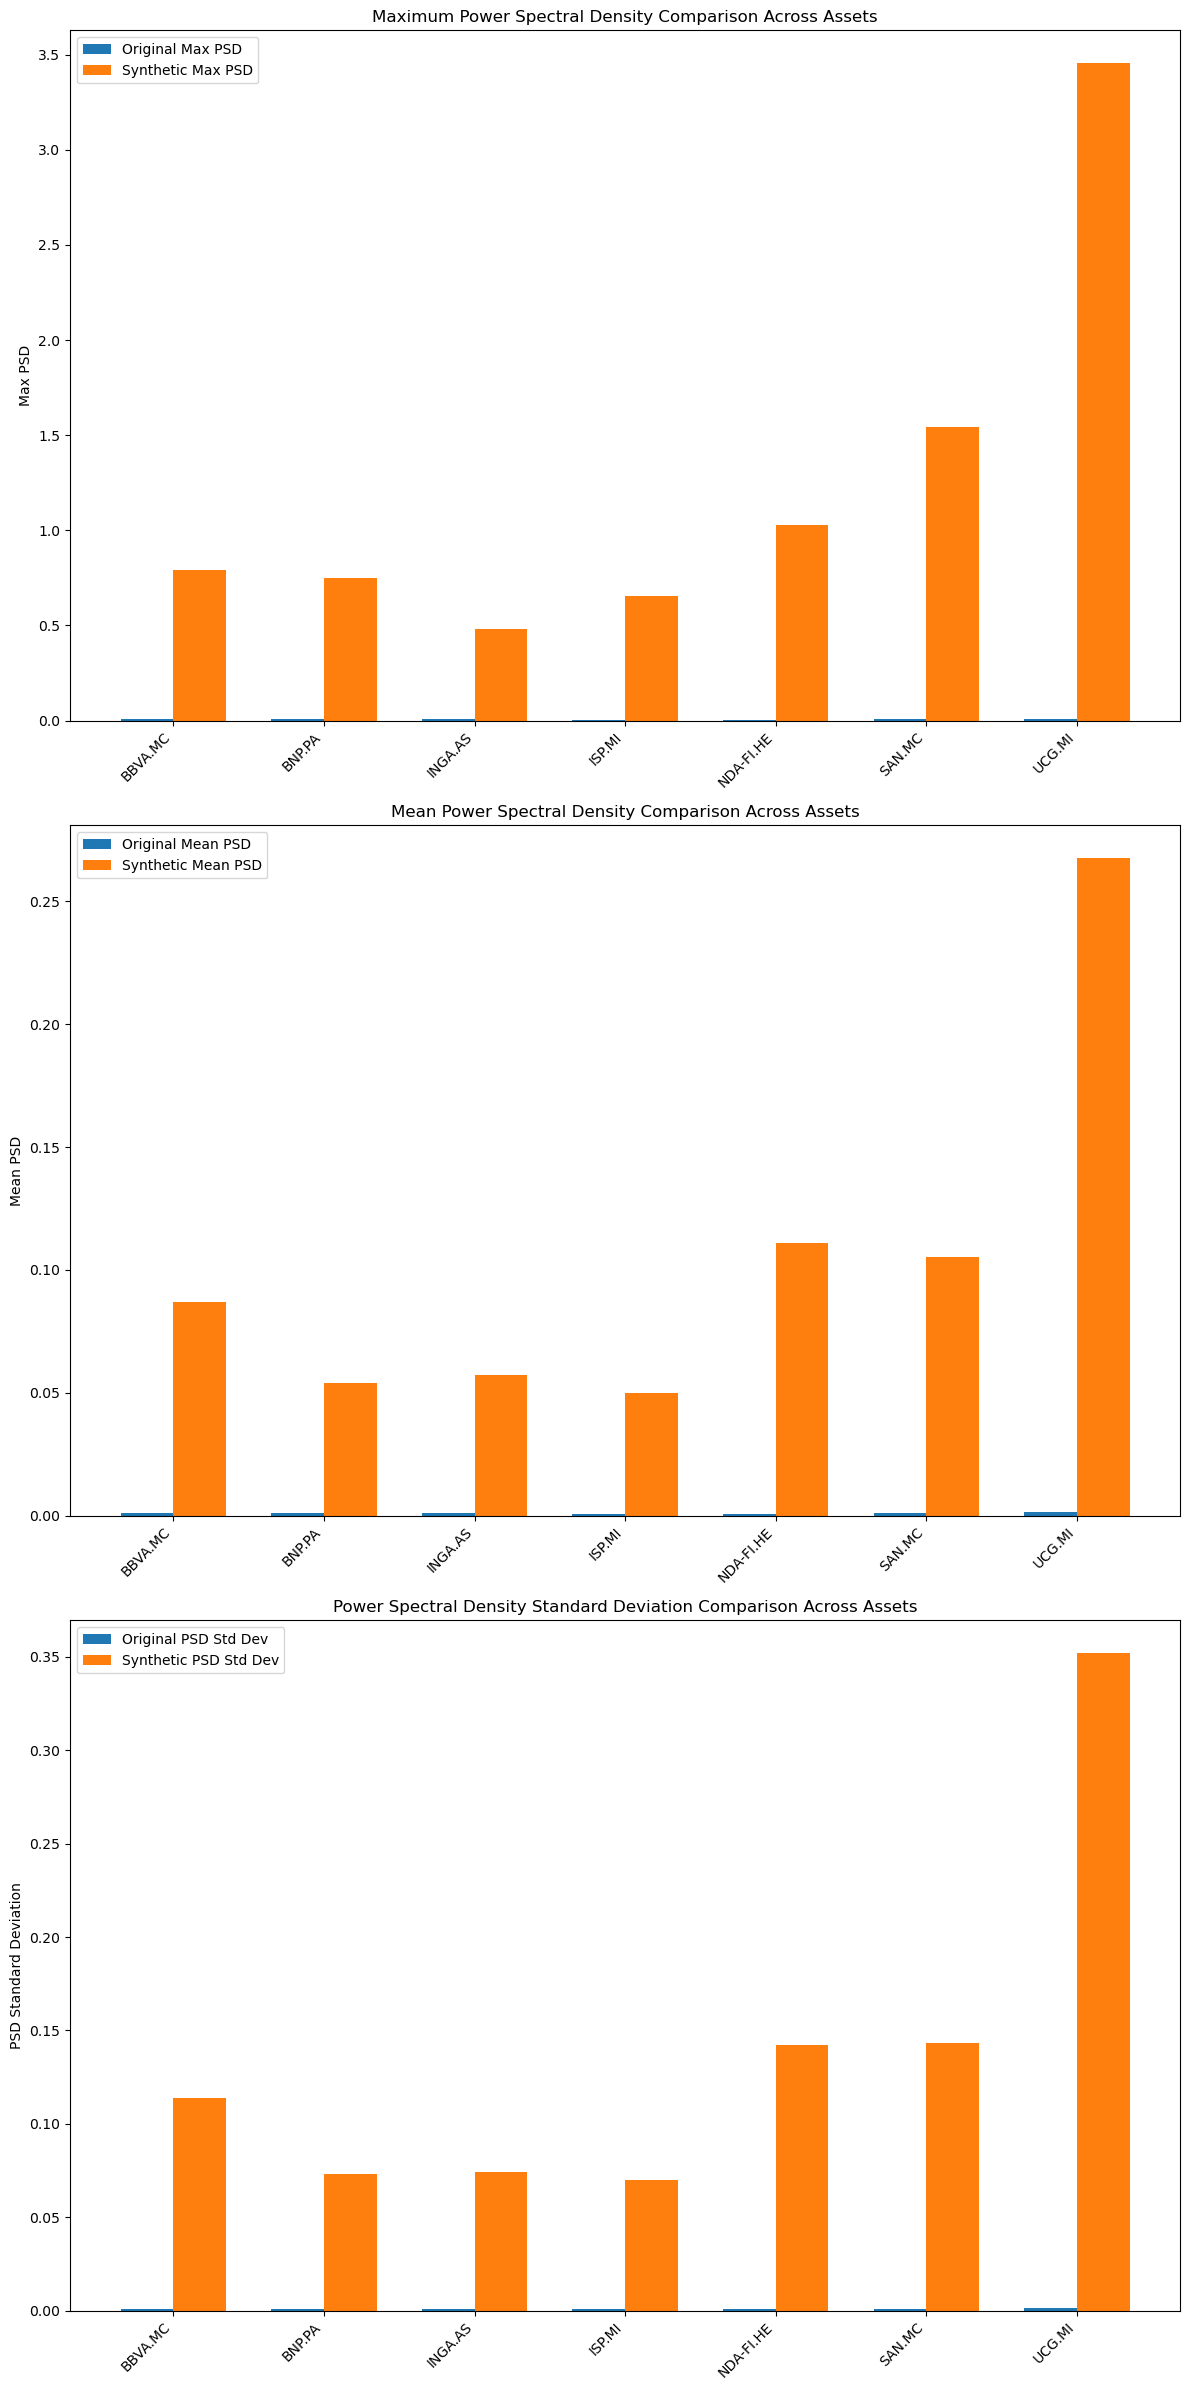


Original Portfolio:


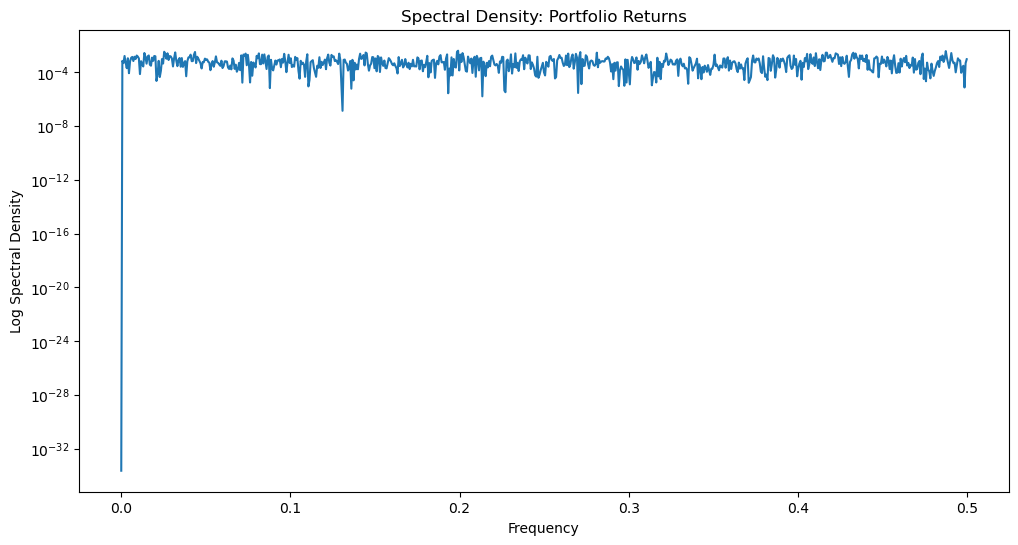


Portfolio Spectral Density Statistics:
Max: 0.00395
Min: 0.00000
Mean: 0.00072
Median: 0.00051
Standard Deviation: 0.00067


<Figure size 1200x600 with 0 Axes>

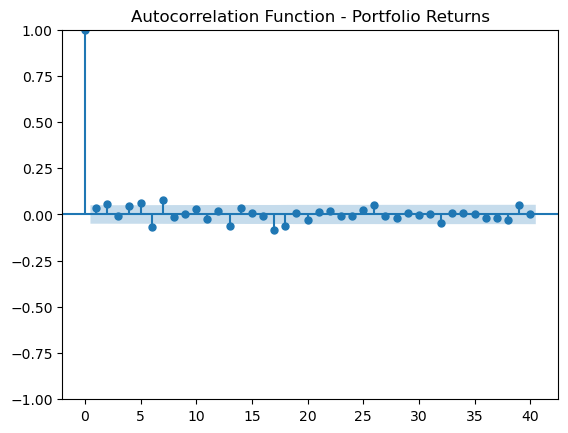


Synthetic Portfolio:


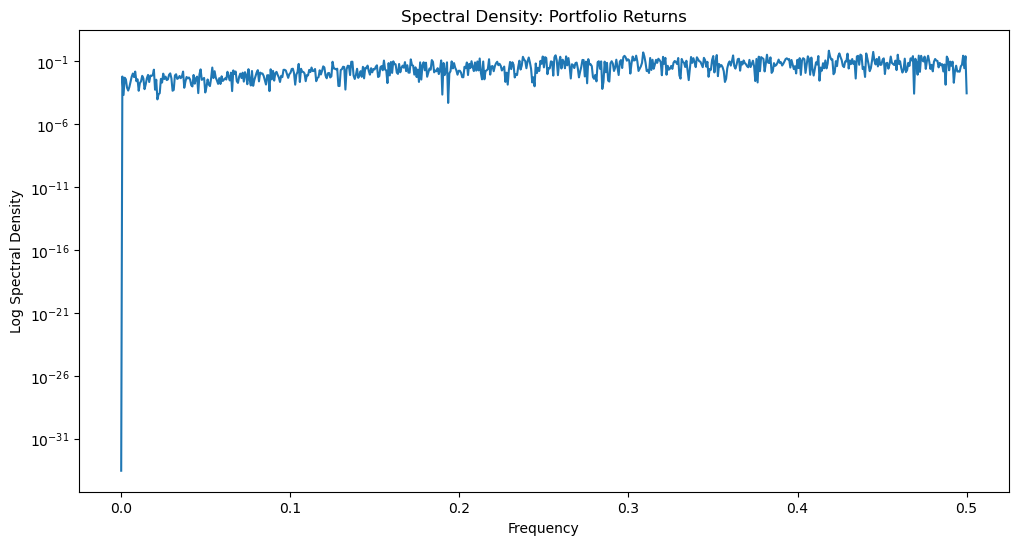


Portfolio Spectral Density Statistics:
Max: 0.70174
Min: 0.00000
Mean: 0.06029
Median: 0.02710
Standard Deviation: 0.08020


<Figure size 1200x600 with 0 Axes>

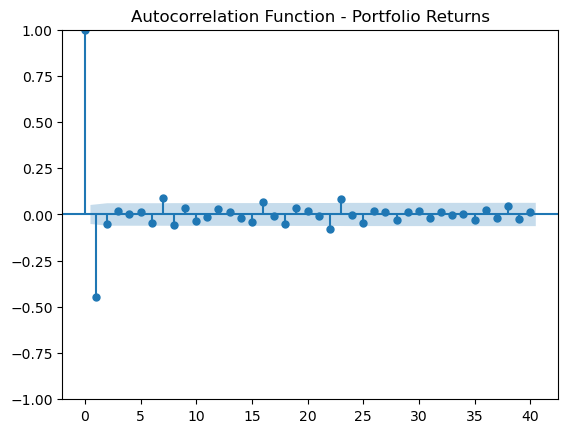

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import periodogram
import statsmodels.api as sm

def analyze_spectrum(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()

    # Lists to store metrics for aggregate chart
    assets = []
    original_max_psd = []
    synthetic_max_psd = []
    original_mean_psd = []
    synthetic_mean_psd = []
    original_std_psd = []
    synthetic_std_psd = []

    for column in original_returns.columns:
        # Compute periodogram
        f_original, Pxx_original = periodogram(original_returns[column])
        f_synthetic, Pxx_synthetic = periodogram(synthetic_returns[column])

        # Store metrics for aggregate chart
        assets.append(column)
        original_max_psd.append(np.max(Pxx_original))
        synthetic_max_psd.append(np.max(Pxx_synthetic))
        original_mean_psd.append(np.mean(Pxx_original))
        synthetic_mean_psd.append(np.mean(Pxx_synthetic))
        original_std_psd.append(np.std(Pxx_original))
        synthetic_std_psd.append(np.std(Pxx_synthetic))

        # Spectral Analysis
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        # Spectral Analysis - Original
        axs[0].semilogy(f_original, Pxx_original)
        axs[0].set_title(f'Spectral Density: Original Returns - {column}')
        axs[0].set_xlabel('Frequency')
        axs[0].set_ylabel('Log Spectral Density')

        # Spectral Analysis - Synthetic
        axs[1].semilogy(f_synthetic, Pxx_synthetic)
        axs[1].set_title(f'Spectral Density: Synthetic Returns - {column}')
        axs[1].set_xlabel('Frequency')
        axs[1].set_ylabel('Log Spectral Density')

        plt.tight_layout()
        plt.show()

        # Compute and print statistics
        print(f"\nSpectral Analysis for {column}:")
        print("Original Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_original):.5f}")
        print(f"Min: {np.min(Pxx_original):.5f}")
        print(f"Mean: {np.mean(Pxx_original):.5f}")
        print(f"Median: {np.median(Pxx_original):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_original):.5f}")

        print("\nSynthetic Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_synthetic):.5f}")
        print(f"Min: {np.min(Pxx_synthetic):.5f}")
        print(f"Mean: {np.mean(Pxx_synthetic):.5f}")
        print(f"Median: {np.median(Pxx_synthetic):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_synthetic):.5f}")

        # Power Spectral Density (PSD) comparison
        plt.figure(figsize=(12, 6))
        plt.semilogy(f_original, Pxx_original, label='Original')
        plt.semilogy(f_synthetic, Pxx_synthetic, label='Synthetic')
        plt.xlabel('Frequency')
        plt.ylabel('Power Spectral Density')
        plt.title(f'Power Spectral Density Comparison - {column}')
        plt.legend()
        plt.show()

        # Autocorrelation Function
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        sm.graphics.tsa.plot_acf(original_returns[column], lags=40, alpha=0.05, title=f'ACF - Original Returns {column}', ax=ax1)
        sm.graphics.tsa.plot_acf(synthetic_returns[column], lags=40, alpha=0.05, title=f'ACF - Synthetic Returns {column}', ax=ax2)
        plt.tight_layout()
        plt.show()

    # Aggregate charts
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 24))
    x = np.arange(len(assets))
    width = 0.35

    # Max PSD comparison
    ax1.bar(x - width/2, original_max_psd, width, label='Original Max PSD')
    ax1.bar(x + width/2, synthetic_max_psd, width, label='Synthetic Max PSD')
    ax1.set_ylabel('Max PSD')
    ax1.set_title('Maximum Power Spectral Density Comparison Across Assets')
    ax1.set_xticks(x)
    ax1.set_xticklabels(assets, rotation=45, ha='right')
    ax1.legend()

    # Mean PSD comparison
    ax2.bar(x - width/2, original_mean_psd, width, label='Original Mean PSD')
    ax2.bar(x + width/2, synthetic_mean_psd, width, label='Synthetic Mean PSD')
    ax2.set_ylabel('Mean PSD')
    ax2.set_title('Mean Power Spectral Density Comparison Across Assets')
    ax2.set_xticks(x)
    ax2.set_xticklabels(assets, rotation=45, ha='right')
    ax2.legend()

    # Standard Deviation of PSD comparison
    ax3.bar(x - width/2, original_std_psd, width, label='Original PSD Std Dev')
    ax3.bar(x + width/2, synthetic_std_psd, width, label='Synthetic PSD Std Dev')
    ax3.set_ylabel('PSD Standard Deviation')
    ax3.set_title('Power Spectral Density Standard Deviation Comparison Across Assets')
    ax3.set_xticks(x)
    ax3.set_xticklabels(assets, rotation=45, ha='right')
    ax3.legend()

    plt.tight_layout()
    plt.show()

def analyze_portfolio_spectrum(data, weights=None):
    if weights is None:
        weights = np.ones(len(data.columns)) / len(data.columns)  # Equal weights if not provided
    
    portfolio_returns = (data.pct_change().dropna() * weights).sum(axis=1)
    
    f, Pxx = periodogram(portfolio_returns)
    
    plt.figure(figsize=(12, 6))
    plt.semilogy(f, Pxx)
    plt.title('Spectral Density: Portfolio Returns')
    plt.xlabel('Frequency')
    plt.ylabel('Log Spectral Density')
    plt.show()
    
    print("\nPortfolio Spectral Density Statistics:")
    print(f"Max: {np.max(Pxx):.5f}")
    print(f"Min: {np.min(Pxx):.5f}")
    print(f"Mean: {np.mean(Pxx):.5f}")
    print(f"Median: {np.median(Pxx):.5f}")
    print(f"Standard Deviation: {np.std(Pxx):.5f}")

    # Autocorrelation Function for portfolio returns
    plt.figure(figsize=(12, 6))
    sm.graphics.tsa.plot_acf(portfolio_returns, lags=40, alpha=0.05, title='Autocorrelation Function - Portfolio Returns')
    plt.show()

# Assuming stock_data and rescaled_synthetic_data are available
# If they're not, you might need to load or recreate them here

# Perform the spectral analysis
analyze_spectrum(stock_data, rescaled_synthetic_data)

print("\nOriginal Portfolio:")
analyze_portfolio_spectrum(stock_data)

print("\nSynthetic Portfolio:")
analyze_portfolio_spectrum(rescaled_synthetic_data)